## Import packages

In [190]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import copy
import sys
import random
import h5py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

## Cell name

In [191]:
# cell_name = 'CL075_230228'
# run_num = ['1', '2', '3']

# cell_name = 'CL079_230324'
# run_num = ['1', '2', '3']

# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']

## Read fluorescence structure data

In [192]:
# # The code below is used to see whether a trial's post 2s is same as another trial's pre 2s.
# # However, no finding that a trial's post 2s is same as another trial's pre 2s, because the
# # post 2s periods are processed to make them more close to the baseline.

# # Here, use dFF data. Changing mat_data['Master_dFF'] to mat_data['Master_f'] to check F data.

# root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"

# i = 1
# path_ = os.path.join(root_path, cell_name, cell_name + 'red_dFFStructuresrun' + run_num[i] + '.mat')
# mat_data = scipy.io.loadmat(path_)
# fluo_runx = mat_data['Master_dFF']

# conca_runx = np.empty((0,fluo_runx[0,0].shape[2]))
# index_record = []
# action = True
# while action:
#     action = False
#     for index, value in np.ndenumerate(fluo_dFF_runx):
#         value = np.squeeze(value)
#         # print(value.shape)
#         # print(value[-31:, :].shape)
#         if conca_runx.shape[0] == 0:
#             conca_runx = np.concatenate((conca_runx, value), axis=0)
#             index_record = index_record + [index]
#             action = True
#             break
#         if np.array_equal(conca_runx[:31, :], value[-31:, :]):
#             conca_runx = np.concatenate((value[:-31, :], conca_runx), axis=0)
#             index_record = [index] + index_record
#             action = True
#             break
#         if np.array_equal(conca_runx[-31:, :], value[:31, :]):
#             fluo_dFconca_dFF_runxF_runx = np.concatenate((conca_runx, value[31:, :]), axis=0)
#             index_record = index_record + [index]
#             action = True
#             break
# print(conca_runx.shape)
# # a shape (93, 10) means no found.

### Functions

In [193]:
def read_conca_fluo_data(cell_name = 'CL090_230515',
             run_num = ['4', '5', '6'],
             color = 'red',
             datatype = 'F',
             root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"):
    '''
    This fuction is used to concatenate dFF or F data from different pieces of
    red/green structure data.
    color = 'red' or 'green'
    type = 'F' or 'dFF'
    if len(run_num) is 3, the output is <class 'numpy.ndarray'> with shape (3, 48),
    and its elements are <class 'numpy.ndarray'> with shape (93, 1, 10) for red
    and shape (93, 281, 10) for green (281 is the number of components, 10 is
    the number of repeats and 93 is 6 seconds; the 2p imaging frequency is
    15.63 Hz so roughly 93 frames for 6 seconds).
    '''

    conca_fluo_data = np.empty((0, 48))

    for i in range(len(run_num)):
        path_ = os.path.join(root_path, cell_name, cell_name + color + '_dFFStructuresrun' + run_num[i] + '.mat')
        mat_data = scipy.io.loadmat(path_)
        if datatype == 'dFF':
            fluo_data_runx = mat_data['Master_dFF']
        elif datatype == 'F':
            fluo_data_runx = mat_data['Master_f']
        fluo_data_runx = fluo_data_runx[:, :-1] # delete the last column (49th)
        # print(type(fluo_data_runx))
        # print(fluo_data_runx.shape)
        # print(fluo_data_runx[0,0].shape)

        conca_fluo_data = np.concatenate((conca_fluo_data, fluo_data_runx), axis=0) # like np.vsatck

    return conca_fluo_data

def plot_all_trials(conca_fluo_data,
           cell_name = 'CL090_230515',
           run_num = ['4', '5', '6'],
           color = 'red',
           datatype = 'F',
           component = 1):
    '''
    This function draws the figures based on the conca_fluo_data generated by
    the function read_conca_fluo_data.
    color = 'red' or 'green'
    type = 'F' or 'dFF'
    component is for 'green'; it is from 1 to the component number.
    if color is 'red', it can be arbitrary value.
    '''
    runs_string = ' '.join(run_num)
    color_name = 'Red' if color == 'red' else 'Green'

    # Create some sample data
    x_intervals = np.linspace(0, 6, 94) # Divide [0, 6] into 94 intervals, cuz data length of a trial is 93
    x_middle_points = (x_intervals[:-1] + x_intervals[1:]) / 2  # Calculate middle points

    # Create a figure and axis
    fig, ax = plt.subplots(nrows=48, ncols=len(run_num), figsize=(5 * len(run_num), 3 * 48), constrained_layout=True)

    # Create sf array
    sf = np.tile([0.02, 0.08, 0.32], 16)
    # Create tf array
    tf = np.tile([1, 1, 1, 4, 4, 4], 8)
    # Create orientation array
    orientation = np.repeat(np.arange(0, 360, 45), 6)

    for x in range(48):
        for y in range(3):
            if color == 'green':
                data_patch = conca_fluo_data[y, x][:,component-1,:]
            if color == 'red':
                data_patch = np.squeeze(conca_fluo_data[y, x])
            for i in range(data_patch.shape[1]):
                ax[x, y].plot(x_middle_points, data_patch[:, i])

            # Set axis labels and title
            ax[x, y].set_xlabel('Time (seconds)', fontsize=16)
            ax[x, y].set_ylabel(datatype, fontsize=16)
            # ax.set_title('dFF for a trial', fontsize=18)

            # Set tick parameters
            ax[x, y].tick_params(labelsize=16)  # Adjust tick size as needed

            ax[x, y].axvspan(2, 4, facecolor='gray', alpha=0.2)

            if y == 0:
                x_data = ax[x, y].get_xticks()
                y_data = ax[x, y].get_yticks()
                x_data_min = np.min(x_data)
                x_data_max = np.max(x_data)
                y_data_min = np.min(y_data)
                y_data_max = np.max(y_data)
                x_text = x_data_min - 0.3 * (x_data_max - x_data_min)
                y_text = 0.5 * (y_data_max + y_data_min)

        # Write the group information to the right of each row
        ax[x, 0].text(x_text, y_text, f'Ori: {orientation[x]}° \nTF: {tf[x]} \nSF: {sf[x]}', fontsize=14, va='center')
    if color == 'red':
        fig.suptitle(f'All Conditions All Rounds All Repests {color_name} {datatype} Data ({cell_name}) (Columns: run {runs_string})', fontsize=16)
        filename = f'{cell_name}_{color_name}_{datatype}.pdf'
    if color == 'green':
        fig.suptitle(f'All Conditions All Rounds All Repests {color_name} {datatype} Data ({cell_name} Component {component}) (Columns: run {runs_string})', fontsize=16)
        filename = f'{cell_name}_{color_name}_{datatype}_{component:03d}.pdf'
    plt.savefig(filename)
    plt.show()

In [194]:
# color = 'green'
# datatype = 'F'
# component = 1
# conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)
# plot_all_trials(conca_fluo_data, cell_name, run_num, color, datatype, component)

# print(type(conca_fluo_data))
# print(conca_fluo_data.shape)
# print(type(conca_fluo_data[1,1]))
# print(conca_fluo_data[1,1].shape)

### Read red and green data then plot

In [195]:
# cell_name_list = ['CL075_230228', 'CL079_230324' 'CL090_230515']
# run_num_list = [['1', '2', '3'], ['1', '2', '3'], ['4', '5', '6']]

# cell_name_list = ['CL090_230515']
# run_num_list = [['4', '5', '6']]

# for cell_name_, run_num_ in zip(cell_name_list, run_num_list):
#     for color_ in ['red', 'green']:
#         for datatype_ in ['F', 'dFF']:
#             conca_fluo_data_ = read_conca_fluo_data(cell_name_, run_num_, color_, datatype_)
#             if color_ == 'red':
#                 plot_all_trials(conca_fluo_data_, cell_name_, run_num_, color_, datatype_)
#             if color_ == 'green':
#                 for component_ in range(1, conca_fluo_data_[0,0].shape[1]+1):
#                     plot_all_trials(conca_fluo_data_, cell_name_, run_num_, color_, datatype_, component_)

In [196]:
# batch download the plotted figures
# uncomment the code below to download figures if needed

# import glob

# folder_path = '.'
# # file_prefix = 'All_Conditions_All_Rounds_All_Repeats_'
# file_prefix = 'CL'

# # Use glob to find all files with the given prefix in the folder
# matching_files = glob.glob(f"{folder_path}/{file_prefix}*")
# # print(matching_files)
# # # Print the matching file names
# # for file_path in matching_files:
# #     print(file_path)

# import zipfile

# zip_filename = 'files.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zipf:
#     # Add files to the zip file
#     for file_path in matching_files:
#         zipf.write(file_path)

# from google.colab import files
# files.download(zip_filename)

## Extract the chronological order of randomized conditions and the sequences; extract the singal traces and tran and test

### Extract the chronological order

In [197]:
def extract_chronological_order(cell_name = 'CL090_230515',
                 run_num = ['4', '5', '6'],
                 root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"):
    '''
    This function uses the frame_2p_metadata_run data to extract the the chronological
    order of randomized conditions.
    Finally, it returns
    ori_3d, tf_3d, sf_3d, all are with shape (3, 10, 48) if the length of rum_num is 3,
    3 is the number of runs (the length of run_num); 10 is the number of repeats in each
    run; 48 is the number of conditions.
    The elements in "48" dimension show the ori/tf/sf parameters in chronological order
    for a certain run and repeat.
    '''

    ori_3d = np.empty((len(run_num),10,48))
    tf_3d = np.empty((len(run_num),10,48))
    sf_3d = np.empty((len(run_num),10,48))

    for i in range(len(run_num)):
        path_ = os.path.join(root_path, cell_name, 'frame_2p_metadata_run' + run_num[i] + '.mat')
        mat_data = scipy.io.loadmat(path_)
        stim = mat_data['stim']
        # print(type(stim))
        # print(stim.shape)
        # print(type(stim[0,0]))
        # print(stim[0,0].dtype.names)
        # print(type(stim['frame']))
        # print(stim['frame'].shape)
        # print(type(stim['frame'][0,0]))
        # print(stim['frame'][0,0].dtype.names)

        ori = np.squeeze(stim['frame'][0,0]['orientation'][0,0])
        tf = np.squeeze(stim['frame'][0,0]['temporal_frequencies_hz'][0,0])
        sf = np.squeeze(stim['frame'][0,0]['sf'][0,0])
        # print(type(ori))
        # print(type(tf))
        # print(type(sf))
        # print(ori.shape)
        # print(tf.shape)
        # print(sf.shape)
        # print(len(np.nonzero(ori)[0]))
        # print(len(np.nonzero(tf)[0]))
        # print(len(np.nonzero(sf)[0]))

        indices = np.nonzero(tf)[0] # cannot use nonzero in ori, because it can be 0 degree

        unique_indices = [indices[0]]
        last_number = indices[0]
        for num in indices:
            if num - last_number > 1:
                unique_indices.append(num)
            last_number = num
        # the resulting array where continuous numbers are deleted, and only the first one is retained
        # i.e., [1,2,3,21,22,23,24,33,34,35,36,37,48,49] -> [1,21,33,48]

        # print(len(unique_indices))
        ori = ori[unique_indices].reshape(10,48)
        tf = tf[unique_indices].reshape(10,48)
        sf = sf[unique_indices].reshape(10,48)
        # print(ori.shape)
        # print(tf.shape)
        # print(sf.shape)

        ori_3d[i,:,:] = ori
        tf_3d[i,:,:] = tf
        sf_3d[i,:,:] = sf

    # print(ori_3d.shape)
    # print(tf_3d.shape)
    # print(sf_3d.shape)

    return ori_3d, tf_3d, sf_3d


def get_condition_order(ori_3d, tf_3d, sf_3d):
    '''
    This function uses ori_3d, tf_3d, sf_3d, which are generated by the function
    extract_chronological_order to calculate condition_order, where the column
    number represents the condition and they are sorted in chronological order.

    The conditions along the columns in structure data are given in a fixed order,
    following the order of vectors: orientation, tf, sf (created as follows). But they
    are temporally randomized. That is why we use this function to get the chronological
    order of the columns (conditions).

    The returned condition_order is with shape (3,10,48). For the dimension "48", 48 elements
    are column indexes in structure data, like [2, 0, 23, 24, ...], meaning in structure data
    column 2 occurs first, then column 0, ...
    '''

    # Create orientation array
    orientation = np.repeat(np.arange(0, 360, 45), 6)
    # Create tf array
    tf = np.tile([1, 1, 1, 4, 4, 4], 8)
    # Create sf array
    sf = np.tile([0.02, 0.08, 0.32], 16)

    condition_order = np.empty((3,10,48)) # the column number in chronological order

    condition_in_column_order = [np.array([x,y,z]) for x,y,z in zip(orientation, tf, sf)]

    for i in range(3):
        for j in range(10):
            conditions_in_time_order = [np.array([x,y,z]) for x,y,z in zip(ori_3d[i,j,:], tf_3d[i,j,:], sf_3d[i,j,:])]
            for ii, ele1 in enumerate(conditions_in_time_order):
                is_found = False
                for jj, ele2 in enumerate(condition_in_column_order):
                    if ele1[0] == ele2[0] and ele1[1] == ele2[1] and ele1[2] == ele2[2]:
                        condition_order[i,j,ii] = jj
                        is_found = True
                if not is_found:
                    print("An Element Not Found!!!")

    return condition_order

In [198]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']

# ori_3d, tf_3d, sf_3d = extract_chronological_order(cell_name, run_num)
# condition_order = get_condition_order(ori_3d, tf_3d, sf_3d)

### Get red/green time sequence (only for 48 conditions, in chronological oerder but not continuous)

Note: the sequences got by the following function get_time_sequence are in chronological order **but not continuous** (**so they may not be helpful or used in future algorithms**), because something between them are omitted, like there are gray screen visual stimuli trials are not in the 48 columns but inserted between the 48 trials in the experiment.

In [199]:
def get_time_sequence(conca_fluo_data, condition_order):
    '''
    This function uses conca_fluo_data and condition_order to get
    the time sequence results for red and green data.
    If red, return time_sequence with shape (3, 10, 1, 2976), where
    3 is how many runs, 10 is how many repeats each run, 1 is how many
    components (for red, only soma, it is 1), 2976=62*48 (62 points
    are 2s, 48 are the number of conditions).
    If green, return time_sequence with shape (3, 10, 281, 2976),
    where 281 is how many components, which depends on the cell.
    '''

    how_many_run = conca_fluo_data.shape[0]
    how_many_repeat = conca_fluo_data[0,0].shape[2]
    how_many_component = conca_fluo_data[0,0].shape[1] # will be 1 if red

    time_sequence = np.empty((how_many_run, how_many_repeat, how_many_component, 62*48))

    for i in range(how_many_run):
        for j in range(how_many_repeat):
            for k in range(how_many_component):
                for index, z in enumerate(condition_order[i,j,:]):
                    time_sequence[i, j, k, 62*index:62*(index+1)] = conca_fluo_data[i, int(z)][31:, k, j]

    return time_sequence


def plot_time_sequence_each_repeat(time_sequence,
            cell_name = 'CL090_230515',
            run_num = ['4', '5', '6'],
            color = 'red',
            datatype = 'F',
            run_index = 1,
            repeat = 1,
            component = 1):
    '''
    This function plots the curve of a certain repeat.
    Return the data of that repeat.

    run_index, repeat, and component all start from 1, not 0.
    run_index = 1, ..., len(run_num)
    repeat = 1, .., repeat number
    component = 1, .., component number
    For red, component can only be 1.
    '''

    color_name = 'Red' if color == 'red' else 'Green'
    run = int(run_num[run_index-1])
    data = time_sequence[run_index-1, repeat-1, component-1, :]
    # we should plot all the data of 1 run, that is 10 repeats, cuz they are a sequence.

    time_steps = 62 * 48 # time_sequence.shape[3]
    time_interval = 192  # seconds, 192 s = 4 s/trial * 48 trails, trial is condition

    time_values = [t * time_interval / time_steps for t in range(time_steps)]

    plt.figure(figsize=(18, 6))  # Adjust the figure size as needed

    plt.plot(time_values, data, color=color, linewidth=1)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel(f'{datatype}', fontsize=16)
    if color == 'red':
        plt.title(f'{cell_name} {color_name} {datatype} Run {run} Repeat {repeat} in Chronological Order', fontsize=18)
    if color == 'green':
        plt.title(f'{cell_name} {color_name} {datatype} Run {run} Repeat {repeat} Component {component} in Chronological Order', fontsize=18)

    # Add shaded rectangles for stimuli
    for i in range(0, time_interval, 4):
        plt.axvspan(i, i + 2, facecolor='gray', alpha=0.2)

    if color == 'red':
        filename = f'{cell_name}_{color_name}_{datatype}_Run{run}_Repeat{repeat:02d}_TimeSequence.pdf'
    if color == 'green':
        filename = f'{cell_name}_{color_name}_{datatype}_{component:03d}_Run{run}_Repeat{repeat:02d}_TimeSequence.pdf'

    plt.savefig(filename)
    plt.show()

    return data


def plot_time_sequence_each_run(time_sequence,
            cell_name = 'CL090_230515',
            run_num = ['4', '5', '6'],
            color = 'red',
            datatype = 'F',
            run_index = 1,
            component = 1):
    '''
    This function plots the curve of a certain run.
    Why plot all the data of 1 run, that is 10 repeats?
    Because they are a sequence, i.e., they are done temporally
    continuously.
    Return the data of that run.

    run_index and component both start from 1, not 0.
    run_index = 1, ..., len(run_num)
    component = 1, .., component number
    For red, component can only be 1.
    '''

    color_name = 'Red' if color == 'red' else 'Green'
    run = int(run_num[run_index-1])
    data = time_sequence[run_index-1, :, component-1, :]
    data = data.reshape(time_sequence.shape[1] * time_sequence.shape[3])

    time_steps = 62 * 48 * 10 # 62 * 48 is time_sequence.shape[3], 10 is time_sequence.shape[1]
    time_interval = 192 * 10  # seconds, 192 s = 4 s/trial * 48 trails, trial is condition

    time_values = [t * time_interval / time_steps for t in range(time_steps)]

    plt.figure(figsize=(100, 6))  # Adjust the figure size as needed

    plt.plot(time_values, data, color=color, linewidth=1)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel(f'{datatype}', fontsize=16)
    if color == 'red':
        plt.title(f'{cell_name} {color_name} {datatype} Run {run} in Chronological Order', fontsize=18)
    if color == 'green':
        plt.title(f'{cell_name} {color_name} {datatype} Run {run} Component {component} in Chronological Order', fontsize=18)

    # Add shaded rectangles for stimuli
    for i in range(0, time_interval, 4):
        plt.axvspan(i, i + 2, facecolor='gray', alpha=0.2)

    filename = f'{cell_name}_{color_name}_{datatype}_Run{run}_TimeSequence.pdf'
    if color == 'red':
        filename = f'{cell_name}_{color_name}_{datatype}_Run{run}_TimeSequence.pdf'
    if color == 'green':
        filename = f'{cell_name}_{color_name}_{datatype}_{component:03d}_Run{run}_TimeSequence.pdf'
    plt.savefig(filename)
    plt.show()

    return data

In [200]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']
# color = 'green'
# datatype = 'F'

# conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)

# ori_3d, tf_3d, sf_3d = extract_chronological_order(cell_name, run_num)
# condition_order = get_condition_order(ori_3d, tf_3d, sf_3d)

# time_sequence = get_time_sequence(conca_fluo_data, condition_order)

# # run_index = 1
# # repeat = 1
# # component = 2

# # plot_time_sequence_each_repeat(time_sequence,
# #             cell_name,
# #             run_num,
# #             color,
# #             datatype,
# #             run_index = run_index,
# #             repeat = repeat,
# #             component = component);

# # plot_time_sequence_each_run(time_sequence,
# #             cell_name,
# #             run_num,
# #             color,
# #             datatype,
# #             run_index = run_index,
# #             component = component);

# print(conca_fluo_data.shape)
# print(conca_fluo_data[0,0].shape)
# print(condition_order.shape)
# print(time_sequence.shape)

### Get valid components

In [201]:
def get_valid_components(cell_name, max_pixels = 100, soma_index = 0,
                         root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"):
    '''
    this function gets the correct components from the all component (too big ones are invalid, criteria is max_pexels).
    corresponding size list and distance list (distance to soma) are obtained.
    soma is get from red bouton marks using soma_index (there should be only 1 but there are actually some invalid ones),
    so we need soma_index.
    '''

    # Load red BoutonMasks
    path_ = os.path.join(root_path, cell_name, cell_name + 'red_BoutonMasks.mat')
    data_ = h5py.File(path_, 'r') # Open the MATLAB v7.3 file
    red_bouton_masks = copy.deepcopy(np.array(data_['BoutonMasks']))
    if len(red_bouton_masks.shape) == 3:
        red_bouton_masks = np.transpose(red_bouton_masks, (2, 1, 0))
    elif len(red_bouton_masks.shape) == 2:
        red_bouton_masks = np.transpose(red_bouton_masks)
    else:
        print("Unexpected red_bouton_masks shape!!!")
    data_.close()

    if len(red_bouton_masks.shape) == 3:
        A = red_bouton_masks[:, :, soma_index]
    elif len(red_bouton_masks.shape) == 2:
        A = red_bouton_masks
    else:
        print("Unexpected red_bouton_masks shape!!!")

    row_indices, col_indices = np.where(A == 1)
    soma_average_row = np.mean(row_indices)
    soma_average_col = np.mean(col_indices)

    # Load green BoutonMasks
    path_ = os.path.join(root_path, cell_name, cell_name + 'green_BoutonMasks.mat')
    data_ = h5py.File(path_, 'r') # Open the MATLAB v7.3 file
    green_bouton_masks = copy.deepcopy(np.array(data_['BoutonMasks']))
    green_bouton_masks = np.transpose(green_bouton_masks, (2, 1, 0))
    data_.close()

    n_com = green_bouton_masks.shape[2]
    # print(green_bouton_masks.shape)
    valid_com_index_list = []
    valid_size_list = []
    valid_dis_list = []

    for i in range(n_com):
        A = green_bouton_masks[:, :, i]
        row_indices, col_indices = np.where(A == 1)
        average_row = np.mean(row_indices)
        average_col = np.mean(col_indices)
        if len(row_indices) < max_pixels:
            valid_com_index_list.append(i)

            distance = np.sqrt((average_row - soma_average_row)**2 + (average_col - soma_average_col)**2)
            valid_dis_list.append(distance)

            number_of_ones = np.sum(A == 1)
            valid_size_list.append(number_of_ones)

    return valid_com_index_list, valid_dis_list, valid_size_list


In [202]:
# valid_com_index_list, valid_dis_list, valid_size_list = get_valid_components('CL075_230228', 100, 5)
# print(valid_com_index_list)
# print(valid_dis_list)
# print(valid_size_list)

### Get the signal traces

#### Read signal traces

In [203]:
def read_signal_traces(cell_name = 'CL090_230515',
           run_num = ['4', '5', '6'],
           color = 'red',
           root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"):
    '''
    This fuction is used to signal traces data of which the length is the 2p lengh
    (number of 2p imgaing frames, which divided by 2p imaging frequency, 15.63 Hz, then
    the duration of 2p imaging).
    color = 'red' or 'green'
    Acquired data is the raw fluorescence data, i.e., F value.
    If len(run_num) is 3, for color 'green', the output is <class 'numpy.ndarray'> with
    shape (3, N, M); for color 'red', the output is <class 'numpy.ndarray'> with shape
    (3, 1, M). N is the number of components and M is 2p length (number of 2p imaging
    frames).
    '''

    path_ = os.path.join(root_path, cell_name, cell_name + color + '_SignalTracesrun' + run_num[0] + '.mat')
    mat_data = scipy.io.loadmat(path_)
    singal_traces = np.empty((len(run_num), mat_data['SignalTraces']['BoutonTraces'][0,0].shape[1],
                  mat_data['SignalTraces']['BoutonTraces'][0,0].shape[0]))
    # print(singal_traces.shape)

    for i in range(len(run_num)):
        path_ = os.path.join(root_path, cell_name, cell_name + color + '_SignalTracesrun' + run_num[i] + '.mat')
        mat_data = scipy.io.loadmat(path_)

        # print(mat_data['SignalTraces'].shape)
        # print(mat_data['SignalTraces'][0,0].shape)
        # print(mat_data['SignalTraces'][0,0]['BoutonTraces'].shape)
        # print(mat_data['SignalTraces'][0,0]['BoutonTraces'][0,0].shape)
        # print(mat_data['SignalTraces']['BoutonTraces'].shape)
        # print(mat_data['SignalTraces']['BoutonTraces'][0,0].shape)
        # # mat_data['SignalTraces'][0,0]['BoutonTraces'][0,0] and mat_data['SignalTraces']['BoutonTraces'][0,0] are same.

        singal_traces[i, :, :] = mat_data['SignalTraces']['BoutonTraces'][0,0].T

    return singal_traces

In [204]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']
# color = 'green'

# signal_traces = read_signal_traces(cell_name, run_num, color)

# print(signal_traces.shape)
# # print(signal_traces[0,0,:])

#### Check whether structure data is in signal traces data and get the locations

In [205]:
def get_condition_piece_locations(conca_fluo_data, signal_traces):
    '''
    This function gets the locations of conca_fluo_data (from structure data) in
    signal_traces.
    conca_fluo_data is the data of all conditions; the data is extracted from
    signal_traces.
    return locations with shape (a,b,c,d) (e.g., (3, 281, 10, 48)) and
    its element's shape is (2,3).
    a is how_many_run
    b is how_many_component # will be 1 if red
    c is how_many_repeat
    d is how_many_condition
    (2,3) are the data piece's start and end index in signal_traces.
    here we assume the data piece is 93 points, corresponding to 6s.
    '''

    how_many_run = conca_fluo_data.shape[0]
    how_many_repeat = conca_fluo_data[0,0].shape[2]
    how_many_component = conca_fluo_data[0,0].shape[1] # will be 1 if red
    how_many_condition = conca_fluo_data.shape[1]

    locations = np.empty((how_many_run, how_many_component, how_many_repeat, how_many_condition), dtype=object)

    # get the position of elements from conca_fluo_data in signal_traces
    for run_index in range(how_many_run):
        for component_index in range(how_many_component):
            for repeat_index in range(how_many_repeat):
                for condition_index in range(how_many_condition):
                    for i, ele in enumerate(conca_fluo_data[run_index, condition_index][:, component_index, repeat_index]):
                        if i == 0:
                            # print(np.isin(ele, signal_traces))
                            index_start = np.where(signal_traces[run_index, component_index, :] == ele)[0]
                            # print(np.where(signal_traces[run_index, component_index, :] == ele))
                            # if np.where(signal_traces[run_index, component_index, :] == ele)[0].shape[0] > 1:
                            #     print(ele)
                        if i == 46: # if only i == 0 and i == 92, there are still multiple outputs due to conincidence
                            index_middle = np.where(signal_traces[run_index, component_index, :] == ele)[0]
                        if i == 92:
                            # print(np.isin(ele, signal_traces))
                            index_end = np.where(signal_traces[run_index, component_index, :] == ele)[0]
                    isfound = 0
                    for index1_ in index_start:
                        for index2_ in index_middle:
                            for index3_ in index_end:
                                if index3_ - index1_ == 92 and index2_ - index1_ == 46:
                                    isfound = isfound + 1
                                    locations[run_index, component_index, repeat_index, condition_index] = np.array([[run_index, component_index, index1_],
                                                                              [run_index, component_index, index3_]])
                                    # message = (
                                    #       f"condition {condition_index} -- start position: "
                                    #       f"({run_index}, {component_index}, {index1_}); "
                                    #       f"end position: ({run_index}, {component_index}, {index2_})"
                                    #       )
                                    # print(message)
                    if isfound != 1:
                        print(f"isfound is {isfound}")
                        print(f"run {run_index} component {component_index} repeat {repeat_index} condition {condition_index} Not Found or Multiple Found")
            # print(f"--- --- run {run_index} component {component_index} finished --- ---")

    return locations

## below is the original code for finding location, which has been wrapped in the above function
# run_index = 2
# repeat = 9
# component = 279
# condition_index = 0

# empty_array = np.empty((3, 4))

# # get the position of elements from conca_fluo_data in signal_traces
# for condition_index in range(48):
#     for i, ele in enumerate(conca_fluo_data[run_index, condition_index][:, component, repeat]):
#         if i == 0:
#             # print(np.isin(ele, signal_traces))
#             index1 = np.where(signal_traces[run_index, component, :] == ele)[0]
#             # print(np.where(signal_traces[run_index, component, :] == ele))
#             # if np.where(signal_traces[run_index, component, :] == ele)[0].shape[0] > 1:
#             #     print(ele)
#         if i == 92:
#             # print(np.isin(ele, signal_traces))
#             index2 = np.where(signal_traces[run_index, component, :] == ele)[0]
#     isfound = False
#     for index1_ in index1:
#         for index2_ in index2:
#             if index2_ - index1_ == 92:
#                 isfound = True
#                 print(f"condition {condition_index} -- start position: ({run_index},{component},{index1_}); end position: ({run_index},{component},{index2_})")
#     if not isfound:
#         print("Not Found")
#     print("======")

In [206]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']
# color = 'red'
# datatype = 'F'

# conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)
# ori_3d, tf_3d, sf_3d = extract_chronological_order(cell_name, run_num)
# condition_order = get_condition_order(ori_3d, tf_3d, sf_3d)
# time_sequence = get_time_sequence(conca_fluo_data, condition_order)

# signal_traces = read_signal_traces(cell_name, run_num, color)

# print(conca_fluo_data.shape)
# print(conca_fluo_data[0,0].shape)
# print(condition_order.shape)
# print(time_sequence.shape)
# print(signal_traces.shape)
# print("-- --- --")

# locations = get_condition_piece_locations(conca_fluo_data, signal_traces)
# print(locations.shape)
# print(locations[0,0,0,2])
# print(locations[0,0,0,2].shape)

#### Recover conca_fluo_data (structure data) from signal traces and locations

In [207]:
def recover_strucure_from_traces_and_locs(signal_traces, locations):
    '''
    This function recovers conca_fluo_data (structure data) from signal traces and locations.

    This function is an inverse of function get_condition_piece_locations.
    '''
    how_many_run, how_many_component, how_many_repeat, how_many_condition = locations.shape

    start_point = locations[0, 0, 0, 0][0, 2]
    end_point = locations[0, 0, 0, 0][1, 2]
    fluo_length_per_condition = end_point - start_point + 1
    conca_fluo_data = np.empty((how_many_run, how_many_condition), dtype=object)
    for i in range(how_many_run):
        for j in range(how_many_condition):
            conca_fluo_data[i, j] = np.zeros((fluo_length_per_condition, how_many_component, how_many_repeat))

    for run_index in range(how_many_run):
        for component_index in range(how_many_component):
            for repeat_index in range(how_many_repeat):
                for condition_index in range(how_many_condition):
                    start_point = locations[run_index, component_index, repeat_index, condition_index][0, 2]
                    end_point = locations[run_index, component_index, repeat_index, condition_index][1, 2]
                    conca_fluo_data[run_index, condition_index][:, component_index, repeat_index] = signal_traces[run_index, component_index, start_point:end_point+1]

    return conca_fluo_data

#### Visualize and Process the signal traces data (======== cell_name input here ========)

In [208]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']

cell_name = 'CL075_230228'
run_num = ['1', '2', '3']

# cell_name = 'CL079_230324'
# run_num = ['1', '2', '3']

datatype = 'F'

color = 'green'

green_conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)
green_signal_traces = read_signal_traces(cell_name, run_num, color)
green_locations = get_condition_piece_locations(green_conca_fluo_data, green_signal_traces)
print(green_conca_fluo_data.shape)
print(green_conca_fluo_data[0,0].shape)
print(green_signal_traces.shape)
print(green_locations.shape)
print(green_locations[0,0,0,0].shape)
print("------ ------")

color = 'red'

red_conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)
red_signal_traces = read_signal_traces(cell_name, run_num, color)
red_locations = get_condition_piece_locations(red_conca_fluo_data, red_signal_traces)
print(red_conca_fluo_data.shape)
print(red_conca_fluo_data[0,0].shape)
print(red_signal_traces.shape)
print(red_locations.shape)
print(red_locations[0,0,0,0].shape)


(3, 48)
(93, 128, 10)
(3, 128, 32500)
(3, 128, 10, 48)
(2, 3)
------ ------
(3, 48)
(93, 1, 10)
(3, 1, 32500)
(3, 1, 10, 48)
(2, 3)


In [209]:
# # check recover_strucure_from_traces_and_locs to see whether we can recover conca_fluo_data
# green_conca_fluo_data_ = recover_strucure_from_traces_and_locs(green_signal_traces, green_locations)
# red_conca_fluo_data_ = recover_strucure_from_traces_and_locs(red_signal_traces, red_locations)
# for conca_fluo_data, conca_fluo_data_ in [(green_conca_fluo_data, green_conca_fluo_data_), (red_conca_fluo_data, red_conca_fluo_data_)]:
#     are_equal_red = True
#     for i in range(conca_fluo_data.shape[0]):
#         for j in range(conca_fluo_data.shape[1]):
#             if not np.array_equal(conca_fluo_data[i, j], conca_fluo_data_[i, j]):
#                 are_equal_red = False
#                 break
#     print(are_equal_red)
# # the printed outputs are both "True" -- already verified!!!

##### Calculate and plot mean each run, std each run, mean each repeat, std each repeat

mean of each run of green:
run index:0 -- mean: 4231.6259897323125
run index:1 -- mean: 4376.039209436485
run index:2 -- mean: 4819.074886139357
mean of each run of red:
run index:0 -- mean: 8934.008135095744
run index:1 -- mean: 9164.82116982602
run index:2 -- mean: 7832.181372246418


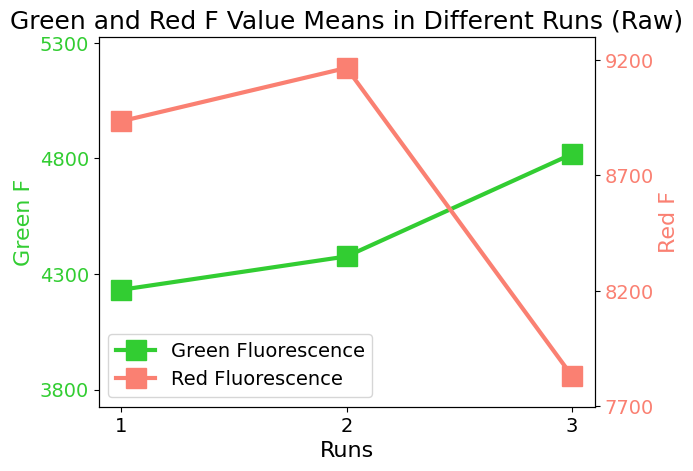

std of each run of green:
run index:0 -- std: 1177.219315790088
run index:1 -- std: 1291.9446093739573
run index:2 -- std: 1451.4440741526776
std of each run of red:
run index:0 -- std: 1784.1922540450003
run index:1 -- std: 1152.5478287977999
run index:2 -- std: 790.1355529773896


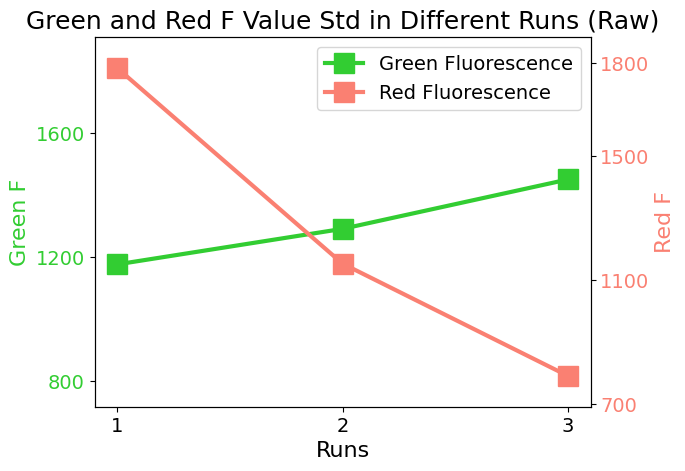

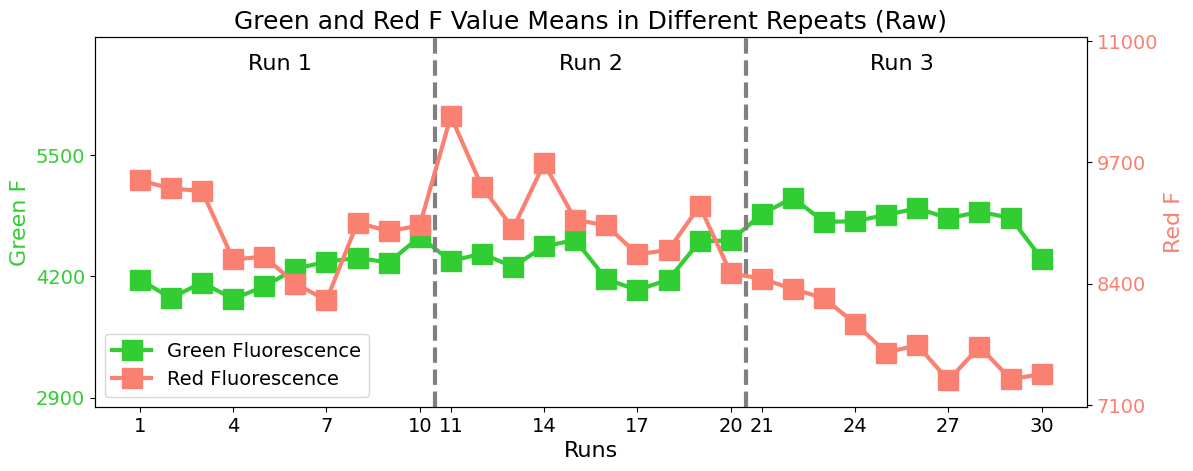

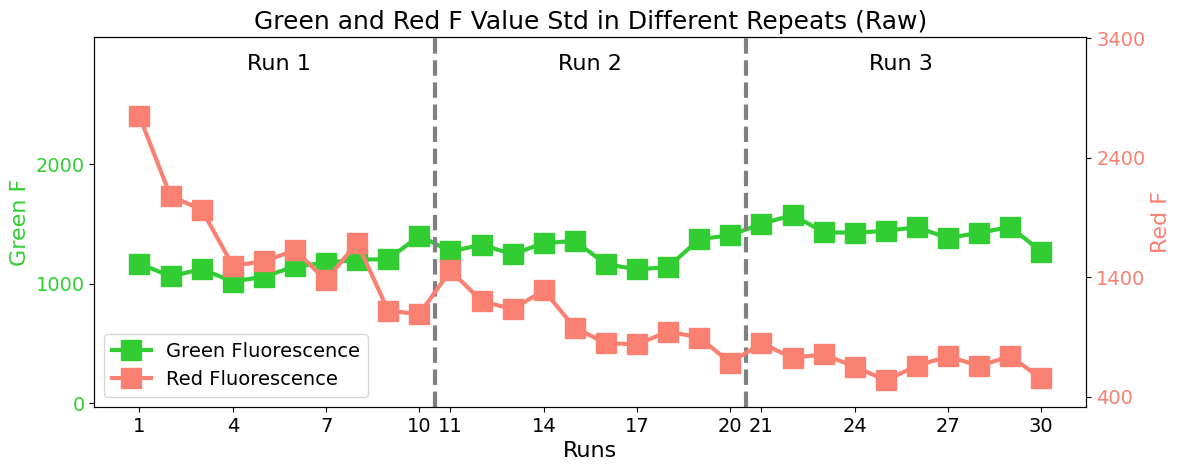

In [210]:
### mean each run

print("mean of each run of green:")
green_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(green_signal_traces[run_,:,:])
    green_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

print("mean of each run of red:")
red_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(red_signal_traces[run_,:,:])
    red_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_mean_run
y2 = red_mean_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8)) # [6.4, 4.8] is deault size, same as fig, ax1 = plt.subplots()

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Runs (Raw)", fontsize=18)

plt.show()


### std each run

print("std of each run of green:")
green_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(green_signal_traces[run_,:,:])
    green_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

print("std of each run of red:")
red_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(red_signal_traces[run_,:,:])
    red_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_std_run
y2 = red_std_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Runs (Raw)", fontsize=18)

plt.show()


### mean each repeat

# print("mean of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces.shape[2]/repeat_num)
green_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(green_signal_traces[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# print("mean of each repeat of red:")
red_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(red_signal_traces[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_mean_repeat
y2 = red_mean_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Repeats (Raw)", fontsize=18)

plt.show()


### std each repeat

# print("std of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces.shape[2]/repeat_num)
green_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(green_signal_traces[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# print("std of each repeat of red:")
red_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(red_signal_traces[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_std_repeat
y2 = red_std_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
    sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
else:
    sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
    sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
else:
    sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Repeats (Raw)", fontsize=18)

plt.show()


## for later use in decay restoration
green_mean_repeat_list_raw = green_mean_repeat.copy()
red_mean_repeat_list_raw = red_mean_repeat.copy()

green_mean_run_list_raw = green_mean_run.copy()
red_mean_run_list_raw = red_mean_run.copy()

green_std_repeat_list_raw = green_std_repeat.copy()
red_std_repeat_list_raw = red_std_repeat.copy()

green_std_run_list_raw = green_std_run.copy()
red_std_run_list_raw = red_std_run.copy()

# std is not used cuz after mean restoration we need to recalculate std

##### Plot a repeat

(3, 128, 32500)
(3, 1, 32500)


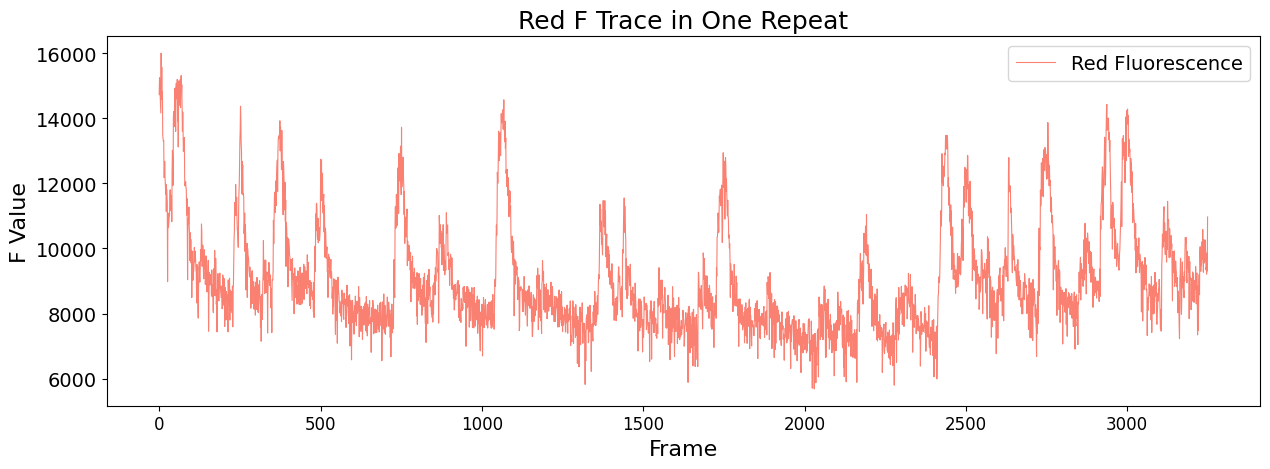

In [211]:
print(green_signal_traces.shape)
print(red_signal_traces.shape)

## plot a signal trace in a repeat
# data_to_plot = green_signal_traces[0, 0, :int(32500/10)]
data_to_plot = red_signal_traces[0, 0, 7*int(32500/10):8*int(32500/10)]

plt.figure(figsize=(6.4*2, 4.8))

plt.plot(data_to_plot, color='salmon', linewidth=0.8, label='Red Fluorescence')
plt.xlabel('Frame', fontsize=16)
plt.ylabel('F Value', fontsize=16)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=12)

# Set title and legend
plt.title('Red F Trace in One Repeat', fontsize=18)
plt.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

#### Signal trace restoration (Mean+Std restoration)

##### Restore mean and plot mean each run, std each run, mean each repeat, std each repeat

###### Restore

In [212]:
green_mean_repeat = np.array(green_mean_repeat_list_raw)
red_mean_repeat = np.array(red_mean_repeat_list_raw)

green_mean_run = np.array(green_mean_run_list_raw)
red_mean_run = np.array(red_mean_run_list_raw)

# print(green_mean_repeat.shape)
# print(red_mean_repeat.shape)
# print(green_mean_run.shape)
# print(red_mean_run.shape)

x_mean_repeat_restored_list = []
x_mean_repeat_restored_coefficients_list = []
for x_mean_repeat, x_mean_run in [(green_mean_repeat, green_mean_run), (red_mean_repeat, red_mean_run)]:
    # Define the exponential function for regression of decay
    def exponential_func(x, lambda_):
        return np.exp(lambda_ * x)

    how_many_run = 3
    repeat_num_per_run = int(x_mean_repeat.shape[0]/how_many_run)

    x_mean_repeat_restored = x_mean_repeat.copy()
    x_mean_repeat_restored_coefficients = x_mean_repeat.copy()
    for i in range(how_many_run):
        y = x_mean_repeat[i*repeat_num_per_run:(i+1)*repeat_num_per_run].copy()
        multiplier = 1 / y[0]
        y = y * multiplier
        x = np.arange(len(y))
        popt, pcov = curve_fit(exponential_func, x, y)
        lambda_ = popt[0]
        print(f"exponent in the exp func is {lambda_}")
        y_fit = exponential_func(x, lambda_)

        recover_factor = y / y_fit
        print("recover_factor.shape:", recover_factor.shape)
        # print(recover_factor)

        x_mean_repeat_restored[i*repeat_num_per_run:(i+1)*repeat_num_per_run] *= recover_factor * x_mean_run[0] / x_mean_run[i]
        x_mean_repeat_restored_coefficients[i*repeat_num_per_run:(i+1)*repeat_num_per_run] = recover_factor * x_mean_run[0] / x_mean_run[i]

    x_mean_repeat_restored_list.append(x_mean_repeat_restored)
    x_mean_repeat_restored_coefficients_list.append(x_mean_repeat_restored_coefficients)

green_mean_repeat_restored, red_mean_repeat_restored = x_mean_repeat_restored_list
green_mean_repeat_restored_coefficients, red_mean_repeat_restored_coefficients = x_mean_repeat_restored_coefficients_list

## generate green_signal_traces_mean_restored and red_signal_traces_mean_restored
green_signal_traces_mean_restored = green_signal_traces.copy()
red_signal_traces_mean_restored = red_signal_traces.copy()

repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces.shape[2]/repeat_num)

for run_ in range(len(run_num)):
    for i in range(repeat_num):
        green_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len] *= green_mean_repeat_restored_coefficients[run_*repeat_num+i]

for run_ in range(len(run_num)):
    for i in range(repeat_num):
        red_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len] *= red_mean_repeat_restored_coefficients[run_*repeat_num+i]


exponent in the exp func is 0.00648034662998736
recover_factor.shape: (10,)
exponent in the exp func is 0.0006194470510251975
recover_factor.shape: (10,)
exponent in the exp func is -0.003360538410455736
recover_factor.shape: (10,)
exponent in the exp func is -0.01216867190646844
recover_factor.shape: (10,)
exponent in the exp func is -0.02118508365358954
recover_factor.shape: (10,)
exponent in the exp func is -0.01683764544129227
recover_factor.shape: (10,)


###### Plot

mean of each run of green:
run index:0 -- mean: 4180.546064388377
run index:1 -- mean: 4239.898229115961
run index:2 -- mean: 4258.654794642621
mean of each run of red:
run index:0 -- mean: 8879.328013902974
run index:1 -- mean: 8833.068653740125
run index:2 -- mean: 8921.592105077489


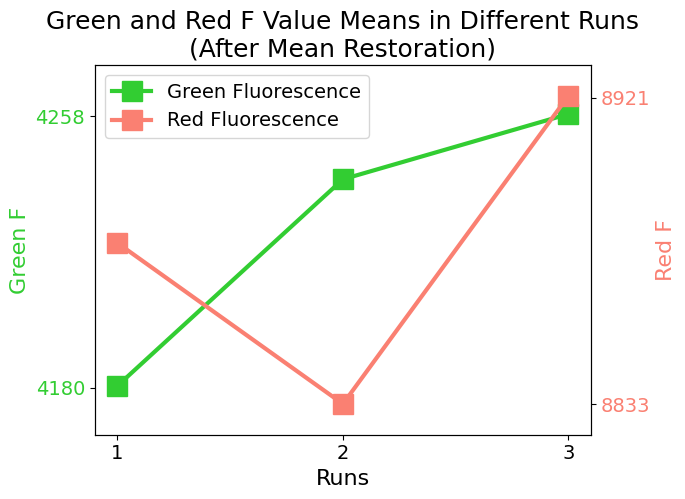

std of each run of green:
run index:0 -- std: 1197.703416431811
run index:1 -- std: 1295.908546921389
run index:2 -- std: 1302.9083164886968
std of each run of red:
run index:0 -- std: 1870.7097027062389
run index:1 -- std: 1181.9479842921444
run index:2 -- std: 932.0120517897708


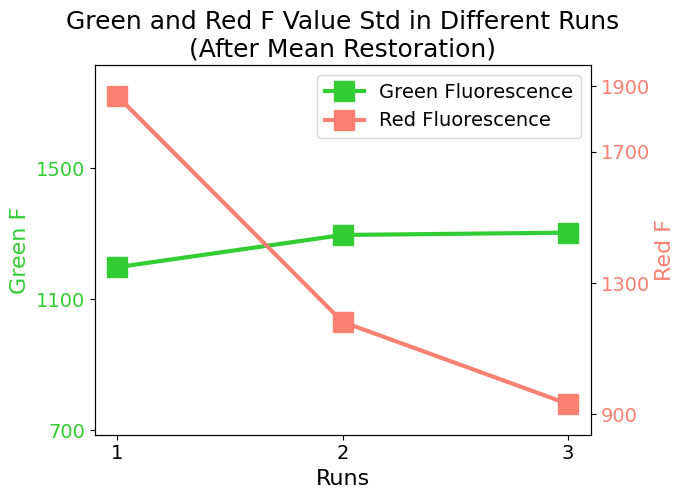

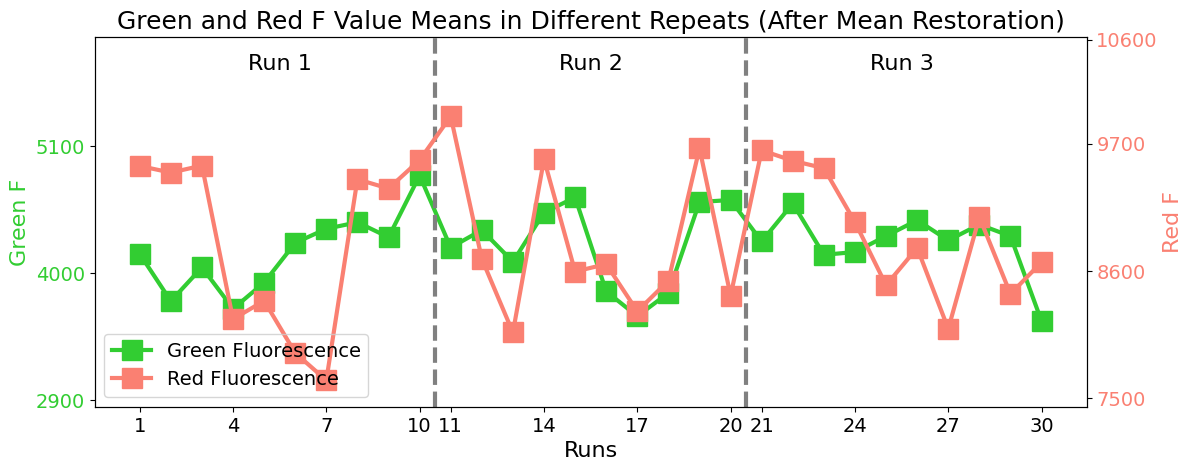

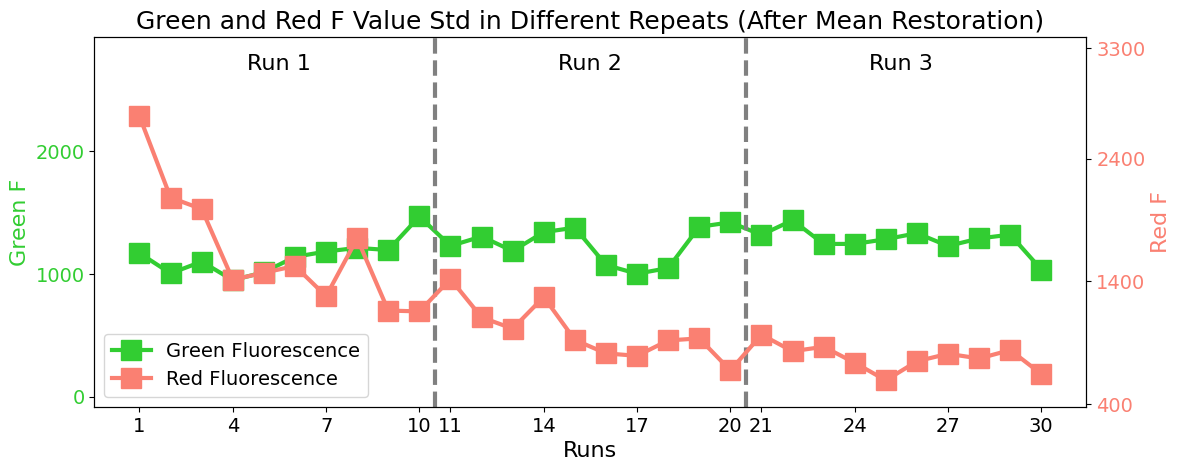

In [213]:
### mean each run

print("mean of each run of green:")
green_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(green_signal_traces_mean_restored[run_,:,:])
    green_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

print("mean of each run of red:")
red_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(red_signal_traces_mean_restored[run_,:,:])
    red_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_mean_run
y2 = red_mean_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8)) # [6.4, 4.8] is deault size, same as fig, ax1 = plt.subplots()

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Runs\n(After Mean Restoration)", fontsize=18)

plt.show()


### std each run

print("std of each run of green:")
green_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(green_signal_traces_mean_restored[run_,:,:])
    green_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

print("std of each run of red:")
red_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(red_signal_traces_mean_restored[run_,:,:])
    red_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_std_run
y2 = red_std_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Runs\n(After Mean Restoration)", fontsize=18)

plt.show()


### mean each repeat

# print("mean of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces_mean_restored.shape[2]/repeat_num)
green_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(green_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# print("mean of each repeat of red:")
red_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(red_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_mean_repeat
y2 = red_mean_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Repeats (After Mean Restoration)", fontsize=18)

plt.show()


### std each repeat

# print("std of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces_mean_restored.shape[2]/repeat_num)
green_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(green_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# print("std of each repeat of red:")
red_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(red_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_std_repeat
y2 = red_std_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Repeats (After Mean Restoration)", fontsize=18)

plt.show()

## store them to variables with new names
## and for later use in decay restoration
green_mean_repeat_list_after_mean_restored = green_mean_repeat.copy() # same as green_mean_repeat_restored
red_mean_repeat_list_after_mean_restored = red_mean_repeat.copy() # same as red_mean_repeat_restored

green_mean_run_list_after_mean_restored = green_mean_run.copy()
red_mean_run_list_after_mean_restored = red_mean_run.copy()

green_std_repeat_list_after_mean_restored = green_std_repeat.copy()
red_std_repeat_list_after_mean_restored = red_std_repeat.copy()

green_std_run_list_after_mean_restored = green_std_run.copy()
red_std_run_list_after_mean_restored = red_std_run.copy()

##### Restore std and plot mean each run, std each run, mean each repeat, std each repeat

###### Restore

In [214]:
## convert to numpy form
green_mean_repeat = np.array(green_mean_repeat_list_after_mean_restored)
red_mean_repeat = np.array(red_mean_repeat_list_after_mean_restored)

green_mean_run = np.array(green_mean_run_list_after_mean_restored)
red_mean_run = np.array(red_mean_run_list_after_mean_restored)

green_std_repeat = np.array(green_std_repeat_list_after_mean_restored)
red_std_repeat = np.array(red_std_repeat_list_after_mean_restored)

green_std_run = np.array(green_std_run_list_after_mean_restored)
red_std_run = np.array(red_std_run_list_after_mean_restored)

# print(green_std_repeat, red_std_repeat, green_std_run, red_std_run)
# print(green_mean_repeat, red_mean_repeat, green_mean_run, red_mean_run)

In [215]:
x_std_repeat_restored_list = []
x_std_repeat_restored_coefficients_list = []
for x_std_repeat, x_std_run in [(green_std_repeat, green_std_run), (red_std_repeat, red_std_run)]:
    # Define the exponential function for regression of decay
    def exponential_func(x, lambda_):
        return np.exp(lambda_ * x)

    how_many_run = 3
    repeat_num_per_run = int(x_std_repeat.shape[0]/how_many_run)

    x_std_repeat_restored = x_std_repeat.copy()
    x_std_repeat_restored_coefficients = x_std_repeat.copy()
    for i in range(how_many_run):
        y = x_std_repeat[i*repeat_num_per_run:(i+1)*repeat_num_per_run].copy()
        multiplier = 1 / y[0]
        y = y * multiplier
        x = np.arange(len(y))
        popt, pcov = curve_fit(exponential_func, x, y)
        lambda_ = popt[0]
        print(f"exponent in the exp func is {lambda_}")
        y_fit = exponential_func(x, lambda_)

        recover_factor = y / y_fit
        print("recover_factor.shape:", recover_factor.shape)
        # print(recover_factor)

        x_std_repeat_restored[i*repeat_num_per_run:(i+1)*repeat_num_per_run] *= recover_factor * x_std_run[0] / x_std_run[i]
        x_std_repeat_restored_coefficients[i*repeat_num_per_run:(i+1)*repeat_num_per_run] = recover_factor * x_std_run[0] / x_std_run[i]

    x_std_repeat_restored_list.append(x_std_repeat_restored)
    x_std_repeat_restored_coefficients_list.append(x_std_repeat_restored_coefficients)

green_std_repeat_restored, red_std_repeat_restored = x_std_repeat_restored_list
green_std_repeat_restored_coefficients, red_std_repeat_restored_coefficients = x_std_repeat_restored_coefficients_list

## generate red_signal_traces_mean_restored_std_restored and red_signal_traces_mean_restored_std_restored
green_signal_traces_mean_restored_std_restored = green_signal_traces_mean_restored.copy()
red_signal_traces_mean_restored_std_restored = red_signal_traces_mean_restored.copy()

repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces.shape[2]/repeat_num)

for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        temp_ = green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len] - mean_
        temp_ *= green_std_repeat_restored_coefficients[run_*repeat_num+i]
        green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len] = mean_ + temp_

for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        temp_ = red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len] - mean_
        temp_ *= red_std_repeat_restored_coefficients[run_*repeat_num+i]
        red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len] = mean_ + temp_

exponent in the exp func is 0.0047305644221688715
recover_factor.shape: (10,)
exponent in the exp func is 0.0014084405580234588
recover_factor.shape: (10,)
exponent in the exp func is -0.00986968232900091
recover_factor.shape: (10,)
exponent in the exp func is -0.11727824949025567
recover_factor.shape: (10,)
exponent in the exp func is -0.08080805598212949
recover_factor.shape: (10,)
exponent in the exp func is -0.042174840895902725
recover_factor.shape: (10,)


###### Plot

mean of each run of green:
run index:0 -- mean: 4180.546064388378
run index:1 -- mean: 4239.898229115959
run index:2 -- mean: 4258.654794642619
mean of each run of red:
run index:0 -- mean: 8879.328013902976
run index:1 -- mean: 8833.068653740127
run index:2 -- mean: 8921.592105077489


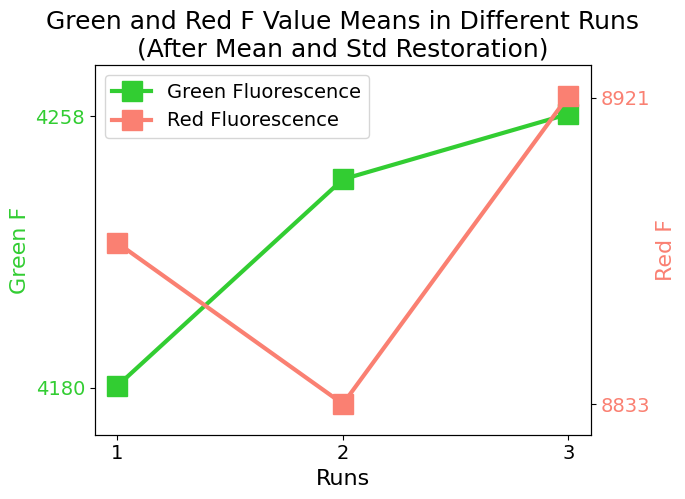

std of each run of green:
run index:0 -- std: 1186.1630479904168
run index:1 -- std: 1241.2491731386758
run index:2 -- std: 1224.7011172661064
std of each run of red:
run index:0 -- std: 1888.7836080207621
run index:1 -- std: 1721.933045410855
run index:2 -- std: 1656.9375585252092


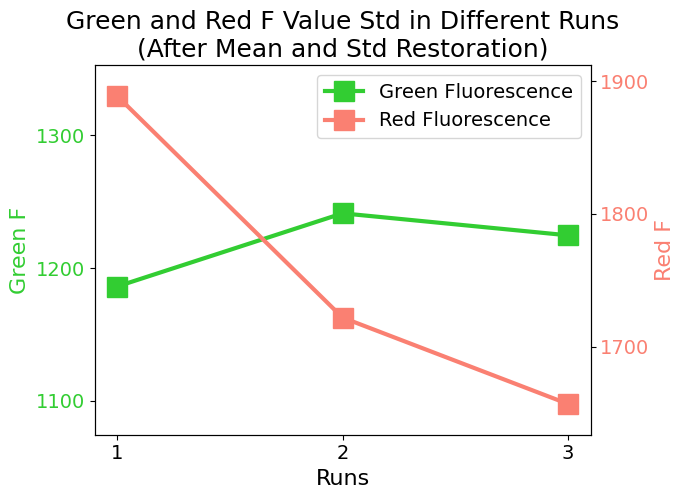

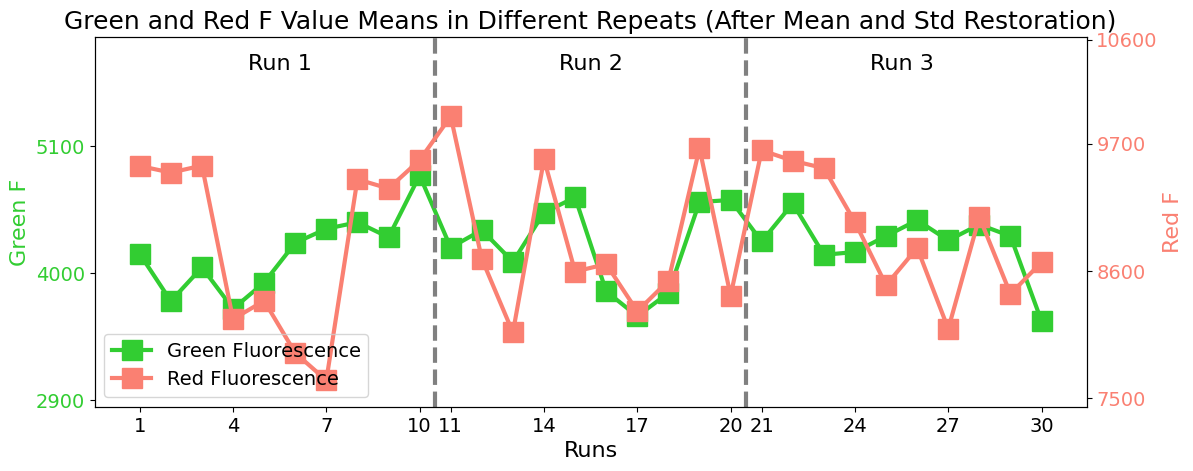

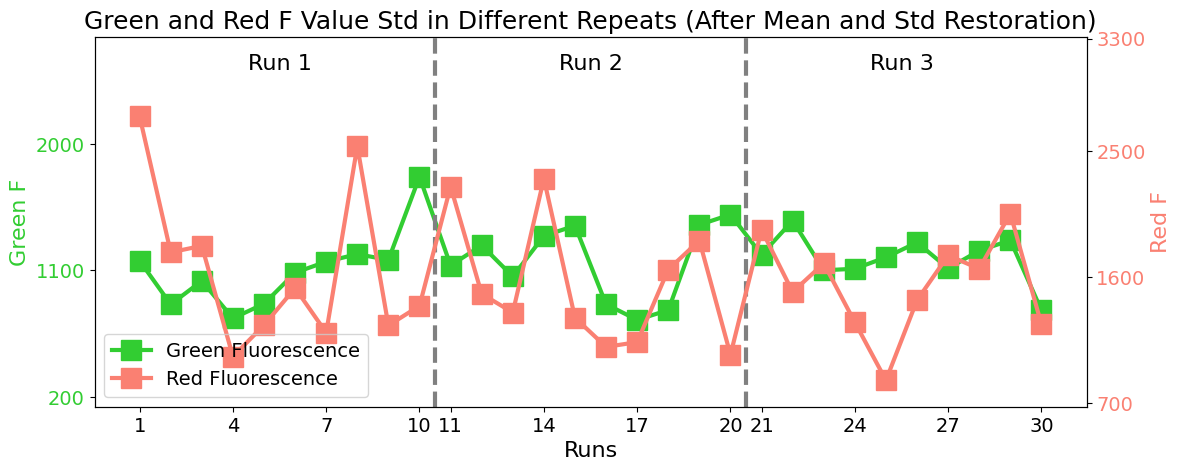

In [216]:
### mean each run

print("mean of each run of green:")
green_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(green_signal_traces_mean_restored_std_restored[run_,:,:])
    green_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

print("mean of each run of red:")
red_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(red_signal_traces_mean_restored_std_restored[run_,:,:])
    red_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_mean_run
y2 = red_mean_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8)) # [6.4, 4.8] is deault size, same as fig, ax1 = plt.subplots()

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Runs\n(After Mean and Std Restoration)", fontsize=18)

plt.show()


### std each run

print("std of each run of green:")
green_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(green_signal_traces_mean_restored_std_restored[run_,:,:])
    green_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

print("std of each run of red:")
red_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(red_signal_traces_mean_restored_std_restored[run_,:,:])
    red_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_std_run
y2 = red_std_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Runs\n(After Mean and Std Restoration)", fontsize=18)

plt.show()


### mean each repeat

# print("mean of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces_mean_restored_std_restored.shape[2]/repeat_num)
green_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# print("mean of each repeat of red:")
red_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_mean_repeat
y2 = red_mean_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Repeats (After Mean and Std Restoration)", fontsize=18)

plt.show()


### std each repeat

# print("std of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces_mean_restored_std_restored.shape[2]/repeat_num)
green_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# print("std of each repeat of red:")
red_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_std_repeat
y2 = red_std_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Repeats (After Mean and Std Restoration)", fontsize=18)

plt.show()

## store them to variables with new names
## and for later use in decay restoration
green_mean_repeat_list_after_mean_restored_std_restored = green_mean_repeat.copy() # same as green_mean_repeat_restored
red_mean_repeat_list_after_mean_restored_std_restored = red_mean_repeat.copy() # same as red_mean_repeat_restored

green_mean_run_list_after_mean_restored_std_restored = green_mean_run.copy()
red_mean_run_list_after_mean_restored_std_restored = red_mean_run.copy()

green_std_repeat_list_after_mean_restored_std_restored = green_std_repeat.copy()
red_std_repeat_list_after_mean_restored_std_restored = red_std_repeat.copy()

green_std_run_list_after_mean_restored_std_restored = green_std_run.copy()
red_std_run_list_after_mean_restored_std_restored = red_std_run.copy()

#### Plot tunning curves using retored data

This is the same process as in "Read fluorescence structure data/Read red and green data then plot", but uses restored data. Need to use function recover_strucure_from_traces_and_locs() to recover conca_fluo_data (structure data) from signal traces and locations.


In [217]:
# cell_name_list = ['CL075_230228']
# run_num_list = [['1', '2', '3']]

# cell_name_list = ['CL090_230515']
# run_num_list = [['4', '5', '6']]

# for cell_name_, run_num_ in zip(cell_name_list, run_num_list):
#     for color_ in ['red', 'green']:
#         for datatype_ in ['F']:
#             if color_ == 'red':
#                 conca_fluo_data_ = recover_strucure_from_traces_and_locs(red_signal_traces_mean_restored_std_restored, red_locations)
#                 plot_all_trials(conca_fluo_data_, cell_name_, run_num_, color_, datatype_)
#             if color_ == 'green':
#                 conca_fluo_data_ = recover_strucure_from_traces_and_locs(green_signal_traces_mean_restored_std_restored, green_locations)
#                 for component_ in range(1, conca_fluo_data_[0,0].shape[1]+1):
#                     plot_all_trials(conca_fluo_data_, cell_name_, run_num_, color_, datatype_, component_)

In [218]:
# # batch download the plotted figures
# # uncomment the code below to download figures if needed

# import glob

# folder_path = '.'
# # file_prefix = 'All_Conditions_All_Rounds_All_Repeats_'
# file_prefix = 'CL'

# # Use glob to find all files with the given prefix in the folder
# matching_files = glob.glob(f"{folder_path}/{file_prefix}*")
# matching_files_new = []
# for file_path in matching_files:
#     # Check if the file ends with ".pdf"
#     if file_path.lower().endswith('.pdf'):
#         matching_files_new.append(file_path)
# matching_files = matching_files_new
# # print(matching_files)
# # # Print the matching file names
# # for file_path in matching_files:
# #     print(file_path)

# import zipfile

# zip_filename = 'files.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zipf:
#     # Add files to the zip file
#     for file_path in matching_files:
#         zipf.write(file_path)

# from google.colab import files
# files.download(zip_filename)

#### Save important data

In [219]:
# np.save(cell_name+'red_signal_traces.npy', red_signal_traces)
# np.save(cell_name+'red_conca_fluo_data.npy', red_conca_fluo_data)
# np.save(cell_name+'red_locations.npy', red_locations)

# np.save(cell_name+'green_signal_traces.npy', green_signal_traces)
# np.save(cell_name+'green_conca_fluo_data.npy', green_conca_fluo_data)
# np.save(cell_name+'green_locations.npy', green_locations)

# np.save(cell_name+'green_signal_traces_mean_restored.npy', green_signal_traces_mean_restored)
# np.save(cell_name+'red_signal_traces_mean_restored.npy', red_signal_traces_mean_restored)

# np.save(cell_name+'green_signal_traces_mean_restored_std_restored.npy', green_signal_traces_mean_restored_std_restored)
# np.save(cell_name+'red_signal_traces_mean_restored_std_restored.npy', red_signal_traces_mean_restored_std_restored)


In [220]:
# # Load red signal traces data
# red_signal_traces = np.load(cell_name + 'red_signal_traces.npy')
# print("Red Signal Traces Shape:", red_signal_traces.shape)
# print("Red Signal Traces Type:", type(red_signal_traces))

# # Load red concatenated fluorescence data
# red_conca_fluo_data = np.load(cell_name + 'red_conca_fluo_data.npy', allow_pickle=True)
# print("Red Concatenated Fluorescence Data Shape:", red_conca_fluo_data.shape)
# print("Red Concatenated Fluorescence Data Type:", type(red_conca_fluo_data))
# print("Red Concatenated Fluorescence Data Elements Shape:", red_conca_fluo_data[0,0].shape)
# print("Red Concatenated Fluorescence Data Elements Type:", type(red_conca_fluo_data[0, 0]))

# # Load red locations data
# red_locations = np.load(cell_name + 'red_locations.npy', allow_pickle=True)
# print("Red Locations Shape:", red_locations.shape)
# print("Red Locations Type:", type(red_locations))
# print("Red Locations Elements Shape:", red_locations[0,0].shape)
# print("Red Locations Elements Type:", type(red_locations[0, 0]))

# # Load green signal traces data
# green_signal_traces = np.load(cell_name + 'green_signal_traces.npy')
# print("Green Signal Traces Shape:", green_signal_traces.shape)
# print("Green Signal Traces Type:", type(green_signal_traces))

# # Load green concatenated fluorescence data
# green_conca_fluo_data = np.load(cell_name + 'green_conca_fluo_data.npy', allow_pickle=True)
# print("Green Concatenated Fluorescence Data Shape:", green_conca_fluo_data.shape)
# print("Green Concatenated Fluorescence Data Type:", type(green_conca_fluo_data))
# print("Green Concatenated Fluorescence Elements Data Shape:", green_conca_fluo_data[0,0].shape)
# print("Green Concatenated Fluorescence Elements Data Type:", type(green_conca_fluo_data[0, 0]))

# # Load green locations data
# green_locations = np.load(cell_name + 'green_locations.npy', allow_pickle=True)
# print("Green Locations Shape:", green_locations.shape)
# print("Green Locations Type:", type(green_locations))
# print("Green Locations Elements Shape:", green_locations[0,0].shape)
# print("Green Locations Elements Type:", type(green_locations[0, 0]))

# # Load green signal traces mean restored data
# green_signal_traces_mean_restored = np.load(cell_name + 'green_signal_traces_mean_restored.npy')
# print("Green Signal Traces Mean Restored Shape:", green_signal_traces_mean_restored.shape)
# print("Green Signal Traces Mean Restored Type:", type(green_signal_traces_mean_restored))

# # Load red signal traces mean restored data
# red_signal_traces_mean_restored = np.load(cell_name + 'red_signal_traces_mean_restored.npy')
# print("Red Signal Traces Mean Restored Shape:", red_signal_traces_mean_restored.shape)
# print("Red Signal Traces Mean Restored Type:", type(red_signal_traces_mean_restored))

# # Load green signal traces mean restored std restored data
# green_signal_traces_mean_restored_std_restored = np.load(cell_name + 'green_signal_traces_mean_restored_std_restored.npy')
# print("Green Signal Traces Mean Restored Std Restored Shape:", green_signal_traces_mean_restored_std_restored.shape)
# print("Green Signal Traces Mean Restored Std Restored Type:", type(green_signal_traces_mean_restored_std_restored))

# # Load red signal traces mean restored std restored data
# red_signal_traces_mean_restored_std_restored = np.load(cell_name + 'red_signal_traces_mean_restored_std_restored.npy')
# print("Red Signal Traces Mean Restored Std Restored Shape:", red_signal_traces_mean_restored_std_restored.shape)
# print("Red Signal Traces Mean Restored Std Restored Type:", type(red_signal_traces_mean_restored_std_restored))


In [221]:
# # batch download the plotted figures
# # uncomment the code below to download figures if needed

# import glob

# folder_path = '.'
# # file_prefix = 'All_Conditions_All_Rounds_All_Repeats_'
# file_prefix = 'CL'

# # Use glob to find all files with the given prefix in the folder
# matching_files = glob.glob(f"{folder_path}/{file_prefix}*")
# # print(matching_files)
# # # Print the matching file names
# # for file_path in matching_files:
# #     print(file_path)

# import zipfile

# zip_filename = 'files.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zipf:
#     # Add files to the zip file
#     for file_path in matching_files:
#         zipf.write(file_path)

# from google.colab import files
# files.download(zip_filename)

#### Generate the data and label, and train and eval

In [222]:
# different cell has different parameters, this is for cell CL075_230228
valid_com_index_list, valid_dis_list, valid_size_list = get_valid_components(cell_name, 100, 5)
data_set = green_signal_traces.copy()
label_set = red_signal_traces.copy()
print(data_set[:,valid_com_index_list,:].shape) # remain the valid component
print(valid_com_index_list)
print(valid_dis_list)


# # different cell has different parameters, this is for cell CL090_230515
# valid_com_index_list, valid_dis_list, valid_size_list = get_valid_components(cell_name, 100, 0)
# data_set = green_signal_traces.copy()
# label_set = red_signal_traces.copy()
# print(data_set[:,valid_com_index_list,:].shape) # remain the valid component
# print(valid_com_index_list)

(3, 120, 32500)
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
[122.50262863743087, 126.83584620454192, 132.02018925281564, 69.18262948866254, 117.83267279878275, 130.42438836620738, 125.6136212561752, 65.89180616159001, 113.25395821691146, 73.44399750121391, 123.10815492338983, 96.01355266517508, 118.39532655947959, 68.98908189980968, 124.11018309257764, 137.71973869828312, 137.7272171585799, 127.87408259906981, 126.94116174852401, 144.32522762812104, 134.5892916262047, 170.98500556279927, 131.33385911334753, 136.80332452618282, 112.

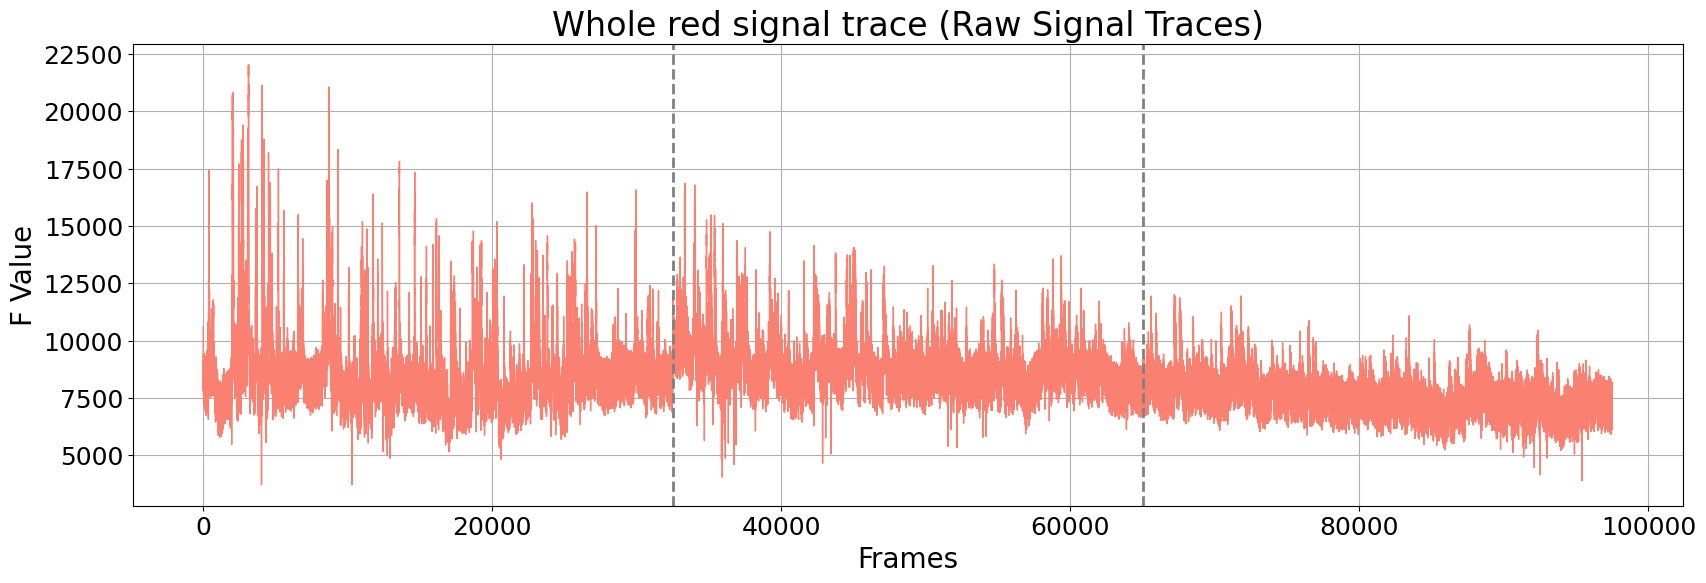

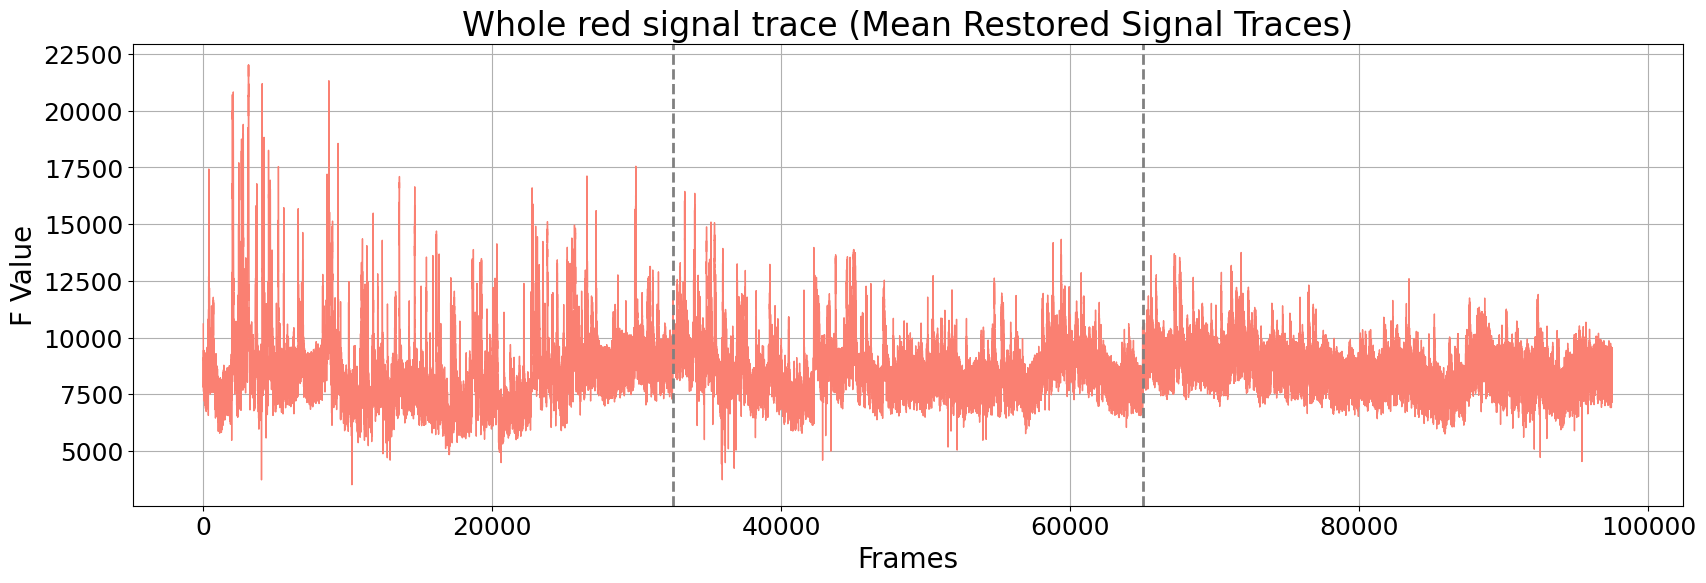

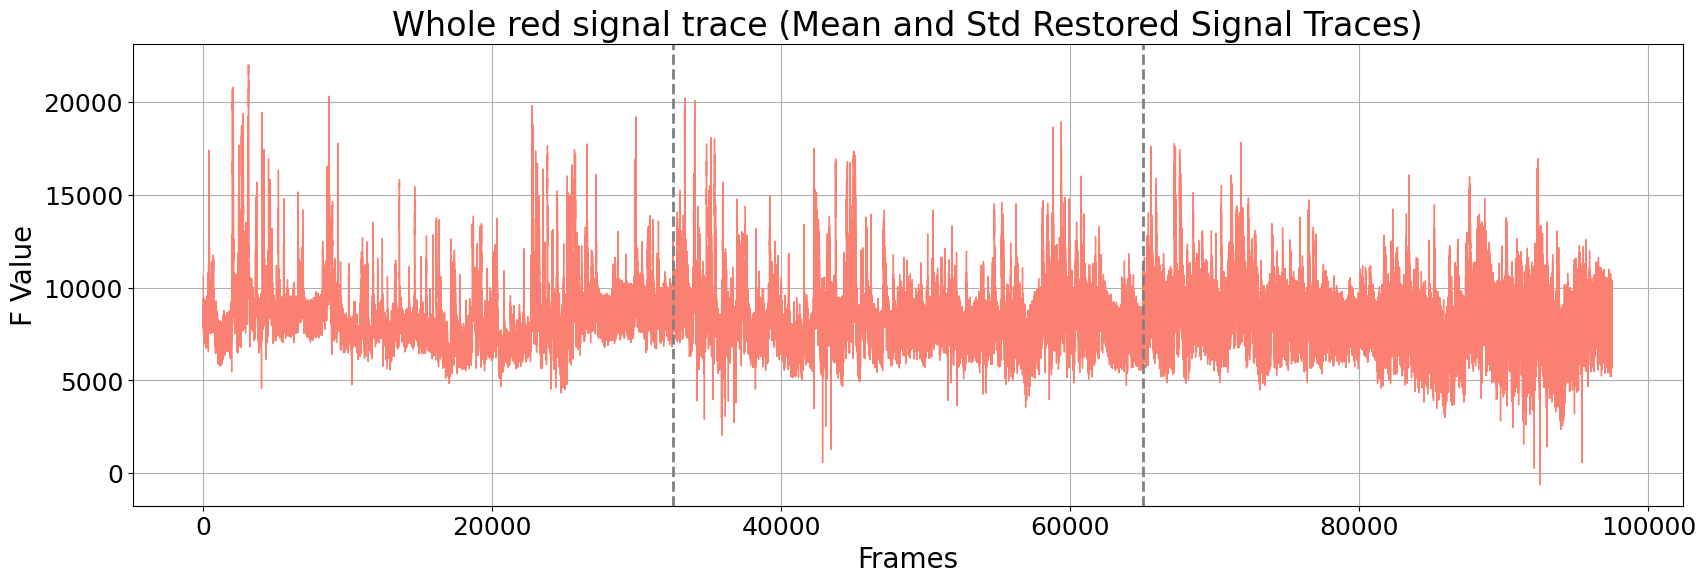

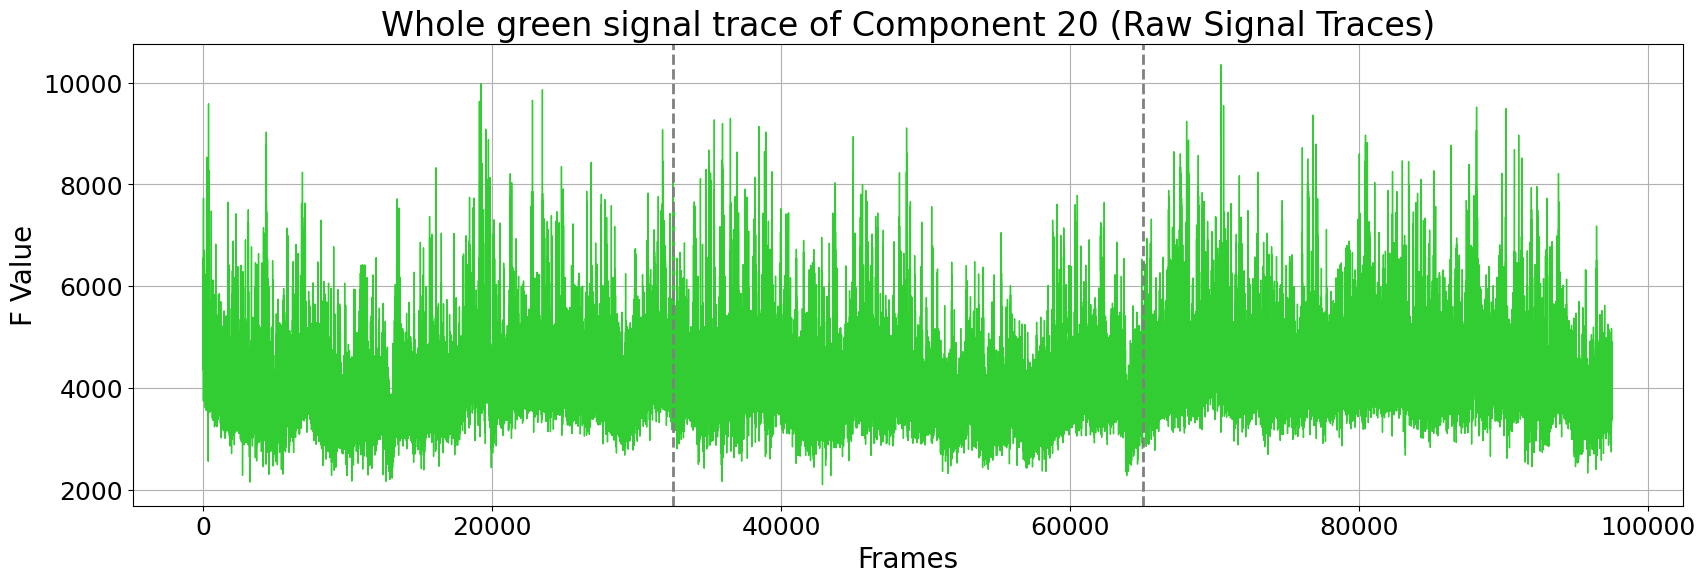

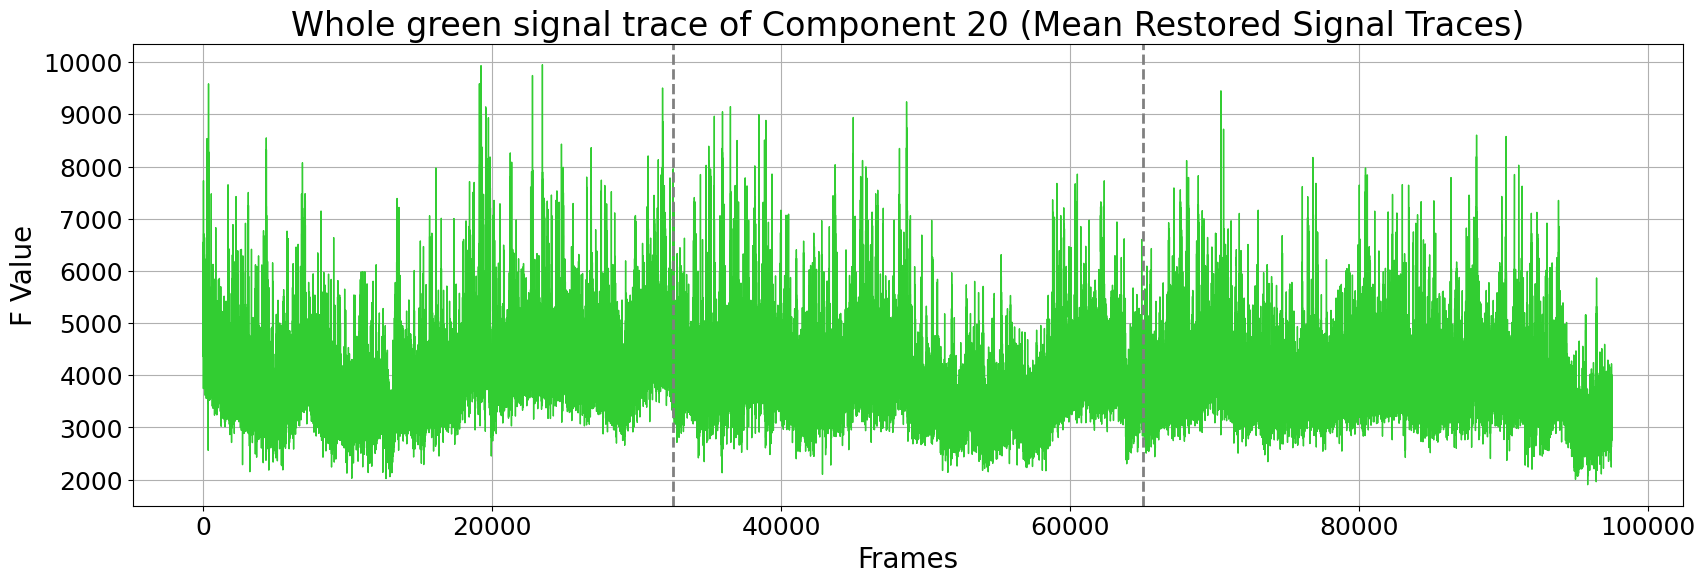

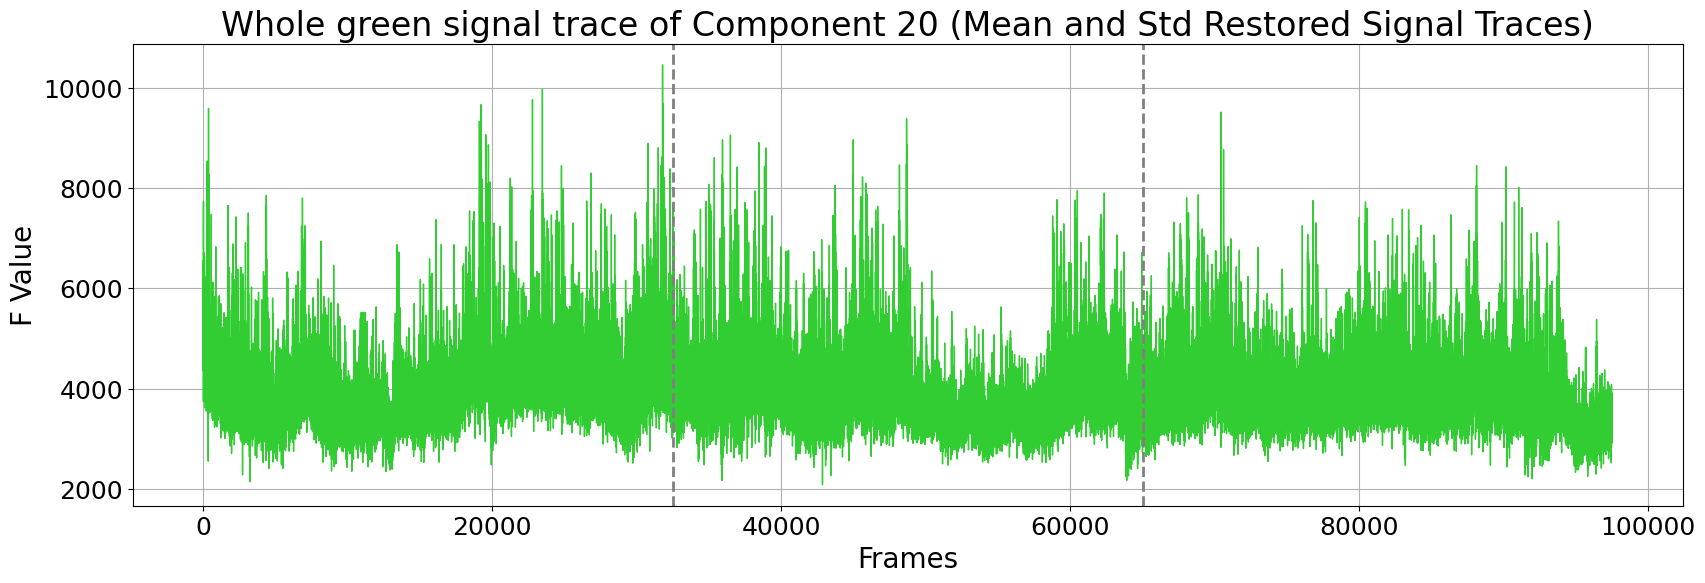

In [223]:
signal_trace_type_list = ["Raw Signal Traces",
                          "Mean Restored Signal Traces",
                          "Mean and Std Restored Signal Traces"]


## plot red
for signal_trace_type in signal_trace_type_list:

    if signal_trace_type == "Raw Signal Traces":
        data_set = green_signal_traces.copy()
        label_set = red_signal_traces.copy()
    elif signal_trace_type == "Mean Restored Signal Traces":
        data_set = green_signal_traces_mean_restored.copy()
        label_set = red_signal_traces_mean_restored.copy()
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        data_set = green_signal_traces_mean_restored_std_restored.copy()
        label_set = red_signal_traces_mean_restored_std_restored.copy()

    x = range(1, label_set.shape[2] + 1)

    plt.figure(figsize=(20, 6))
    plt.plot(list(label_set[0,0,:])+list(label_set[1,0,:])+list(label_set[2,0,:]), color='salmon', linestyle='-', linewidth=1)
    v1 = label_set.shape[2] + 0.5
    v2 = label_set.shape[2] * 2 + 0.5
    plt.axvline(x=v1, color='gray', linestyle='--', linewidth=2)
    plt.axvline(x=v2, color='gray', linestyle='--', linewidth=2)
    plt.xlabel('Frames', fontsize = 20)
    plt.ylabel('F Value', fontsize = 20)
    plt.tick_params(labelsize=18)
    plt.title(f'Whole red signal trace ({signal_trace_type})', fontsize = 24)
    plt.grid(True)
    plt.show()


## plot green
component_index = 20
for signal_trace_type in signal_trace_type_list:

    if signal_trace_type == "Raw Signal Traces":
        data_set = green_signal_traces.copy()
        label_set = red_signal_traces.copy()
    elif signal_trace_type == "Mean Restored Signal Traces":
        data_set = green_signal_traces_mean_restored.copy()
        label_set = red_signal_traces_mean_restored.copy()
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        data_set = green_signal_traces_mean_restored_std_restored.copy()
        label_set = red_signal_traces_mean_restored_std_restored.copy()

    data_set = data_set[:, valid_com_index_list, :] # use valid components

    x = range(1, data_set.shape[2] + 1)

    plt.figure(figsize=(20, 6))
    plt.plot(list(data_set[0,component_index,:])+list(data_set[1,component_index,:])+list(data_set[2,component_index,:]), color='limegreen', linestyle='-', linewidth=1)
    v1 = data_set.shape[2] + 0.5
    v2 = data_set.shape[2] * 2 + 0.5
    plt.axvline(x=v1, color='gray', linestyle='--', linewidth=2)
    plt.axvline(x=v2, color='gray', linestyle='--', linewidth=2)
    plt.xlabel('Frames', fontsize = 20)
    plt.ylabel('F Value', fontsize = 20)
    plt.tick_params(labelsize=18)
    plt.title(f'Whole green signal trace of Component {component_index} ({signal_trace_type})', fontsize = 24)
    plt.grid(True)
    plt.show()

##### Next chunck is traning and plotting. It takes some time.

data_set.shape: (3, 120, 32500)
label_set.shape: (3, 1, 32500)
Epoch [1/90] - Train Loss: 0.000038 | Test Loss: 0.003042
Epoch [2/90] - Train Loss: 0.000033 | Test Loss: 0.002519
Epoch [3/90] - Train Loss: 0.000030 | Test Loss: 0.002204
Epoch [4/90] - Train Loss: 0.000031 | Test Loss: 0.002199
Epoch [5/90] - Train Loss: 0.000028 | Test Loss: 0.002011
Epoch [10/90] - Train Loss: 0.000026 | Test Loss: 0.001872
Epoch [20/90] - Train Loss: 0.000025 | Test Loss: 0.001847
Epoch [30/90] - Train Loss: 0.000027 | Test Loss: 0.002104
Epoch [40/90] - Train Loss: 0.000023 | Test Loss: 0.002021
Epoch [50/90] - Train Loss: 0.000027 | Test Loss: 0.002276
Epoch [60/90] - Train Loss: 0.000022 | Test Loss: 0.001933
Epoch [70/90] - Train Loss: 0.000022 | Test Loss: 0.001942
Epoch [80/90] - Train Loss: 0.000022 | Test Loss: 0.001929
Epoch [90/90] - Train Loss: 0.000022 | Test Loss: 0.001934
Epoch [1/90] - Train Loss: 0.000035 | Test Loss: 0.002870
Epoch [2/90] - Train Loss: 0.000035 | Test Loss: 0.002872


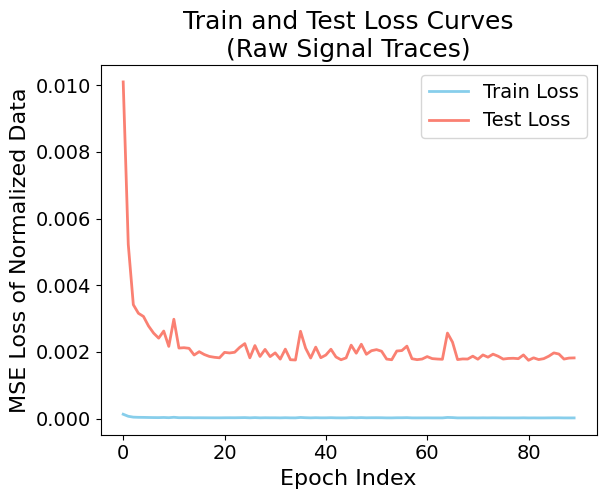

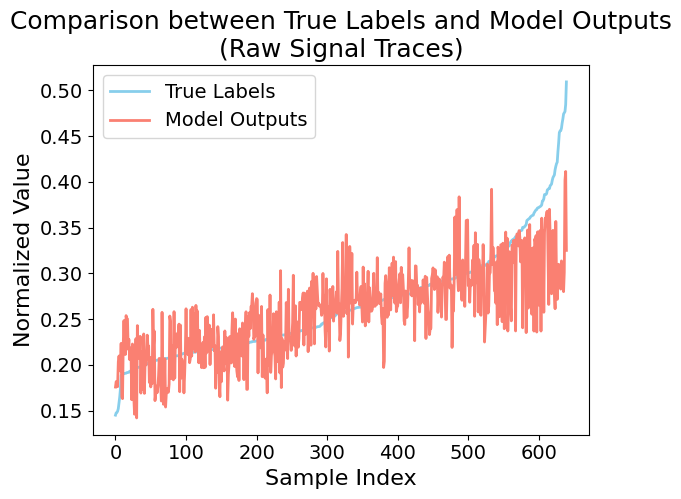

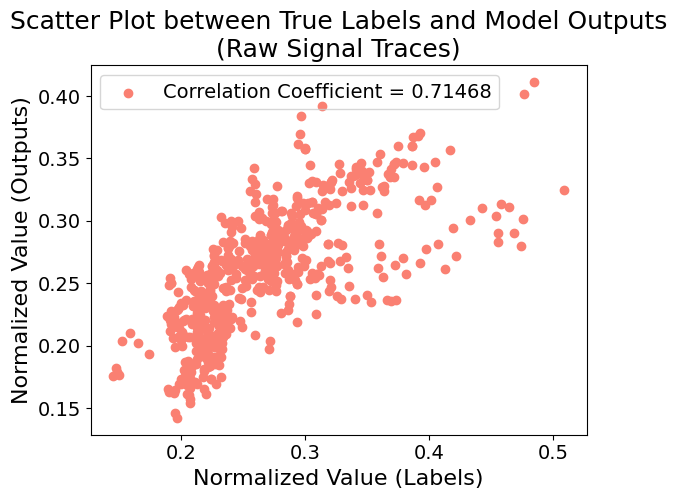

data_set.shape: (3, 120, 32500)
label_set.shape: (3, 1, 32500)
Epoch [1/90] - Train Loss: 0.000074 | Test Loss: 0.004210
Epoch [2/90] - Train Loss: 0.000056 | Test Loss: 0.003080
Epoch [3/90] - Train Loss: 0.000057 | Test Loss: 0.003034
Epoch [4/90] - Train Loss: 0.000054 | Test Loss: 0.002933
Epoch [5/90] - Train Loss: 0.000052 | Test Loss: 0.002830
Epoch [1/90] - Train Loss: 0.000061 | Test Loss: 0.003073
Epoch [2/90] - Train Loss: 0.000049 | Test Loss: 0.002687
Epoch [3/90] - Train Loss: 0.000056 | Test Loss: 0.002723
Epoch [4/90] - Train Loss: 0.000051 | Test Loss: 0.003017
Epoch [5/90] - Train Loss: 0.000057 | Test Loss: 0.002766
Epoch [10/90] - Train Loss: 0.000044 | Test Loss: 0.002310
Epoch [20/90] - Train Loss: 0.000037 | Test Loss: 0.001930
Epoch [30/90] - Train Loss: 0.000034 | Test Loss: 0.001825
Epoch [40/90] - Train Loss: 0.000032 | Test Loss: 0.001885
Epoch [50/90] - Train Loss: 0.000030 | Test Loss: 0.001765
Epoch [60/90] - Train Loss: 0.000030 | Test Loss: 0.001792
Epo

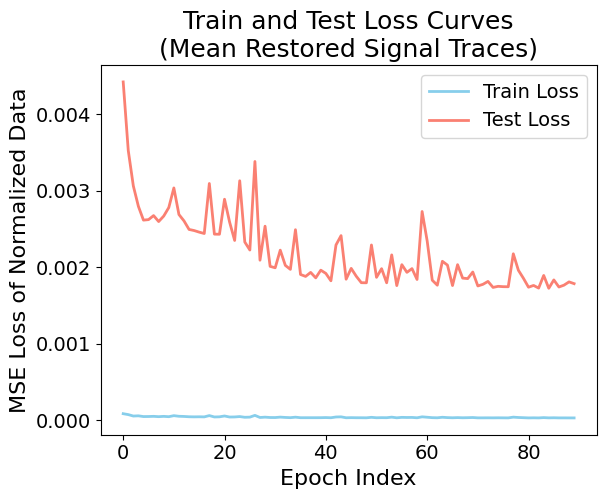

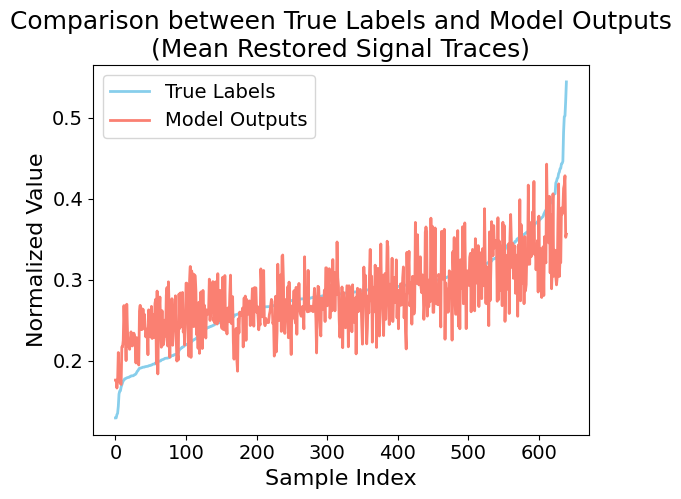

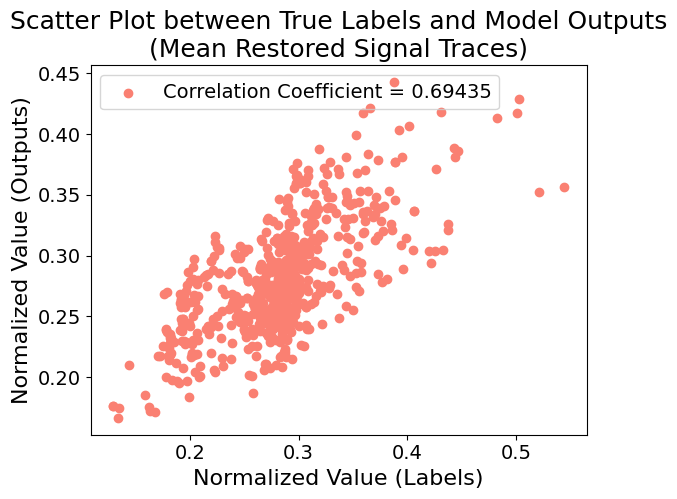

data_set.shape: (3, 120, 32500)
label_set.shape: (3, 1, 32500)
Epoch [1/90] - Train Loss: 0.000062 | Test Loss: 0.003183
Epoch [2/90] - Train Loss: 0.000049 | Test Loss: 0.002503
Epoch [3/90] - Train Loss: 0.000045 | Test Loss: 0.002342
Epoch [4/90] - Train Loss: 0.000042 | Test Loss: 0.002233
Epoch [5/90] - Train Loss: 0.000041 | Test Loss: 0.002262
Epoch [1/90] - Train Loss: 0.000056 | Test Loss: 0.003109
Epoch [2/90] - Train Loss: 0.000047 | Test Loss: 0.002525
Epoch [3/90] - Train Loss: 0.000044 | Test Loss: 0.002393
Epoch [4/90] - Train Loss: 0.000048 | Test Loss: 0.002532
Epoch [5/90] - Train Loss: 0.000040 | Test Loss: 0.002224
Epoch [1/90] - Train Loss: 0.000043 | Test Loss: 0.002320
Epoch [2/90] - Train Loss: 0.000043 | Test Loss: 0.002311
Epoch [3/90] - Train Loss: 0.000034 | Test Loss: 0.001838
Epoch [4/90] - Train Loss: 0.000033 | Test Loss: 0.001742
Epoch [5/90] - Train Loss: 0.000033 | Test Loss: 0.001674
Epoch [10/90] - Train Loss: 0.000031 | Test Loss: 0.001570
Epoch [2

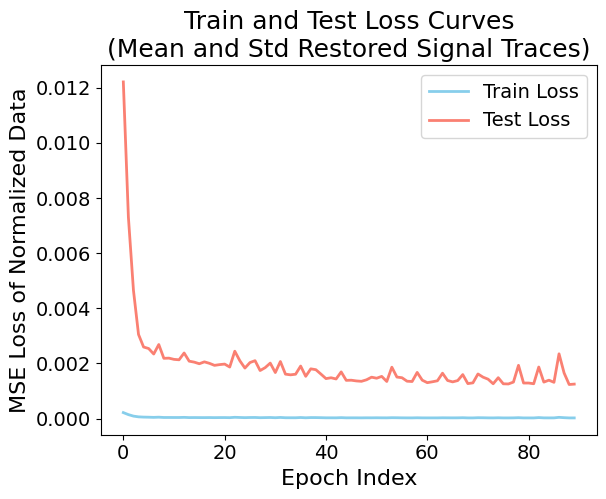

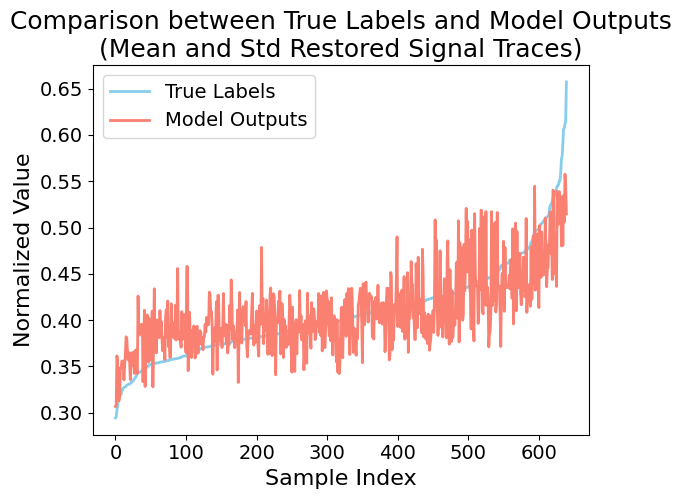

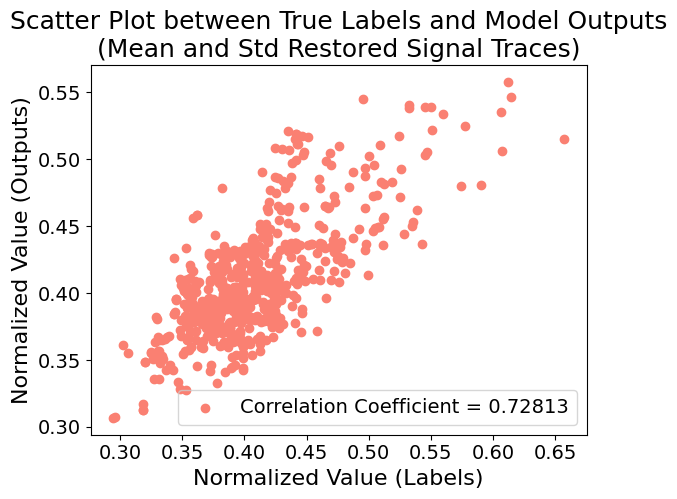

In [225]:
signal_trace_type_list = ["Raw Signal Traces",
                          "Mean Restored Signal Traces",
                          "Mean and Std Restored Signal Traces"]

# signal_trace_type_list = ["Mean Restored Signal Traces",
#                           "Mean and Std Restored Signal Traces"]

# signal_trace_type_list = ["Raw Signal Traces"]
# signal_trace_type_list = ["Mean Restored Signal Traces"]
# signal_trace_type_list = ["Mean and Std Restored Signal Traces"]

list_of_train_loss_lists = []
list_of_test_loss_lists = []

for signal_trace_type in signal_trace_type_list:

    if signal_trace_type == "Raw Signal Traces":
        data_set = green_signal_traces.copy()
        label_set = red_signal_traces.copy()
    elif signal_trace_type == "Mean Restored Signal Traces":
        data_set = green_signal_traces_mean_restored.copy()
        label_set = red_signal_traces_mean_restored.copy()
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        data_set = green_signal_traces_mean_restored_std_restored.copy()
        label_set = red_signal_traces_mean_restored_std_restored.copy()

    data_set = data_set[:,valid_com_index_list,:] # use valid components

    print(f"data_set.shape: {data_set.shape}")
    print(f"label_set.shape: {label_set.shape}")

    # # Normalize data_set to [-1,1]
    # data_set_min = np.min(data_set)
    # data_set_max = np.max(data_set)
    # data_set = ((data_set - data_set_min) / (data_set_max - data_set_min) - 0.5) * 2

    # # Normalize label_set to [-1,1]
    # label_set_min = np.min(label_set)
    # label_set_max = np.max(label_set)
    # label_set = ((label_set - label_set_min) / (label_set_max - label_set_min) - 0.5) * 2

    # Normalize data_set to [0,1]
    data_set_min = np.min(data_set)
    data_set_max = np.max(data_set)
    data_set = (data_set - data_set_min) / (data_set_max - data_set_min)

    # Normalize label_set to [0,1]
    label_set_min = np.min(label_set)
    label_set_max = np.max(label_set)
    label_set = (label_set - label_set_min) / (label_set_max - label_set_min)

    # Define dataset class
    class FluoDataset(Dataset):
        def __init__(self, data_set, label_set, z_indices, x_indices):
            self.data_set = data_set
            self.label_set = label_set
            self.z_indices = z_indices
            self.x_indices = x_indices

        def __len__(self):
            return len(self.z_indices)

        def __getitem__(self, idx):
            z = self.z_indices[idx]
            x = self.x_indices[idx]

            input_data = self.data_set[z, :, x-62:x]
            target_label = np.mean(self.label_set[z, :, x-31:x])

            return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_label, dtype=torch.float32)
            # or torch.from_numpy(input_data).float(), torch.from_numpy(target_label).float()

    # Set a random seed for reproducibility
    # np.random.seed(16)  # can use any integer as the seed value

    # Split the data into train and test sets
    length = 6400*2
    choices = range(3)
    # choices = range(2) # delete last run
    train_z_indices = np.random.choice(choices, size=length)
    # choices = range(62, 30000)
    choices = list(range(62, 10000)) + list(range(12000, 17000)) + list(range(18244, 32500)) # 90% for train
    # 10000-62+17000-12000+32500-18244=29194, 29194/(32500-62)=90%, 32500-62 is the all data pieces
    train_x_indices = np.random.choice(choices, size=length)

    length = 640
    choices = range(3)
    # choices = range(2) # delete last run
    test_z_indices = np.random.choice(choices, size=length)
    # choices = range(62, 30000)
    # choices = range(30000, 32500)
    choices = list(range(10000, 12000)) + list(range(17000, 18244)) # 10% for test
    # 12000-10000+18244-17000=3244, 3244/(32500-62)=10%, 32500-62 is the all data pieces
    test_x_indices = np.random.choice(choices, size=length)

    length = 640 # this is a subset of train data for test on train
    choices = range(3)
    # choices = range(2) # delete last run
    small_train_z_indices = np.random.choice(choices, size=length)
    choices = list(range(9000, 10000)) + list(range(12000, 17000)) + list(range(18244, 19000))
    small_train_x_indices = np.random.choice(choices, size=length)

    train_dataset = FluoDataset(data_set, label_set, train_z_indices, train_x_indices)
    test_dataset = FluoDataset(data_set, label_set, test_z_indices, test_x_indices)
    test_on_train_dataset = FluoDataset(data_set, label_set, small_train_z_indices, small_train_x_indices)

    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_on_train_loader = DataLoader(test_on_train_dataset, batch_size=batch_size, shuffle=False)
    # print(len(train_loader))
    # print(len(test_loader))


    # Define the model
    class FluoModel(nn.Module):
        def __init__(self, component_num):
            super(FluoModel, self).__init__()
            self.fc_shared = nn.Linear(62, 1)  # Shared fully connected layer
            self.fc_reduce = nn.Linear(component_num, 1)  # Fully connected layer to reduce component_num (e.g., 281) channels to 1
            self.sigmoid = nn.Sigmoid()
            self.fc_end = nn.Linear(1, 1)

        def forward(self, x):
            x = x.view(x.size(0), -1, 62)  # Reshape to (batch_size, component_num, 62)

            # Apply the shared fully connected layer along the last dimension (62)
            shared_output = self.fc_shared(x).squeeze(2)
            # self.fc_shared(x) shape is (batch_size, component_num, 1), then squeeze the last dimension
            # In PyTorch, when you apply a fully connected layer (or any other linear
            # transformation) to a 3D tensor, by default, the operation is performed
            # along the last dimension of the tensor.

            # Reduce component_num (e.g., 281) channels to 1 using a separate fully connected layer
            reduced_output = self.fc_reduce(shared_output)
            # pre_output = self.sigmoid(reduced_output)
            pre_output = reduced_output # if without sigmoid
            output = self.fc_end(pre_output)

            return output

    train_loss_list = []
    test_loss_list = []
    for i_ in range(5): # try 5 times to get the best one
        model = FluoModel(data_set.shape[1])

        # Define loss function and optimizer
        criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
        optimizer = optim.Adam(model.parameters(), lr=0.003)

        # optimizer = optim.Adam(model.parameters(), lr=0.004)
        # scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

        # Training loop
        num_epochs = 90
        print_interval = 10

        train_loss_list_ = []
        test_loss_list_ = []
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()
            # scheduler.step()

            # if epoch < 5 or (epoch + 1) % print_interval == 0:
            #     print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item():.6f}")

            # Testing on train and test sets
            model.eval()

            train_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_on_train_loader:
                    outputs = model(inputs)
                    train_loss += criterion(outputs.squeeze(), targets).item()

            average_train_loss = train_loss / len(test_on_train_dataset)
            train_loss_list_.append(average_train_loss)

            test_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    test_loss += criterion(outputs.squeeze(), targets).item()

            average_test_loss = test_loss / len(test_loader)
            if epoch == 5 and average_test_loss >= 0.9 * np.mean(np.array(test_loss_list_)[1:]):
                break; # kill trials with a low probability of convergence (terminate trials that are unlikely to converge)
            test_loss_list_.append(average_test_loss)

            if epoch < 5 or (epoch + 1) % print_interval == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_train_loss:.6f} | Test Loss: {average_test_loss:.6f}")

        if i_ == 0:
            train_loss_list, test_loss_list = train_loss_list_, test_loss_list_
            model_final = model
        elif test_loss_list_[-1] < test_loss_list[-1] and len(train_loss_list_) == num_epochs:
            train_loss_list, test_loss_list = train_loss_list_, test_loss_list_
            model_final = model

    # plot results
    plt.figure(figsize=(6.4, 4.8))
    plt.plot(train_loss_list, color = 'skyblue', label='Train Loss', linewidth=2)
    plt.plot(test_loss_list, color = 'salmon', label='Test Loss', linewidth=2)
    plt.xlabel('Epoch Index', fontsize=16)
    plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.title(f"Train and Test Loss Curves\n({signal_trace_type})", fontsize=18)
    plt.legend(fontsize=14, facecolor='none')
    plt.show()

    list_of_train_loss_lists.append(train_loss_list)
    list_of_test_loss_lists.append(test_loss_list)

    if signal_trace_type == "Raw Signal Traces":
        model_path = f"./{cell_name}_model_with_raw.pth"
    elif signal_trace_type == "Mean Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored.pth"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored_std_restored.pth"

    with open(model_path, "wb") as f:
        torch.save(model_final.state_dict(), f)

    model = FluoModel(data_set.shape[1])
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model in evaluation mode

    outputs_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            outputs_list.append(outputs.numpy())
            labels_list.append(targets.numpy())

    outputs_array = np.concatenate(outputs_list)
    labels_array = np.concatenate(labels_list)

    # Sort labels and corresponding outputs
    sorted_indices = np.argsort(labels_array)
    sorted_labels = labels_array[sorted_indices]
    sorted_outputs = outputs_array[sorted_indices]

    # plot results
    plt.figure(figsize=(6.4, 4.8))
    plt.plot(sorted_labels, color = 'skyblue', label='True Labels', linewidth=2)
    plt.plot(sorted_outputs, color = 'salmon', label='Model Outputs', linewidth=2)
    plt.xlabel('Sample Index', fontsize=16)
    plt.ylabel('Normalized Value', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.title(f"Comparison between True Labels and Model Outputs\n({signal_trace_type})", fontsize=18)
    plt.legend(fontsize=14, facecolor='none')
    plt.show()


    # Calculate the correlation coefficient
    correlation_coefficient = np.corrcoef(sorted_labels, np.transpose(sorted_outputs))[0, 1]

    # plot results
    plt.figure(figsize=(6.4, 4.8))
    plt.scatter(sorted_labels, sorted_outputs, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    plt.xlabel('Normalized Value (Labels)', fontsize=16)
    plt.ylabel('Normalized Value (Outputs)', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.title(f"Scatter Plot between True Labels and Model Outputs\n({signal_trace_type})", fontsize=18)
    plt.legend(fontsize=14, facecolor='none')
    plt.show()

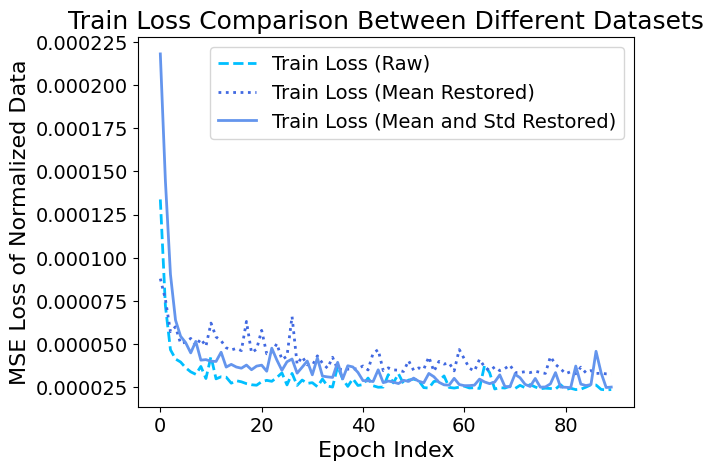

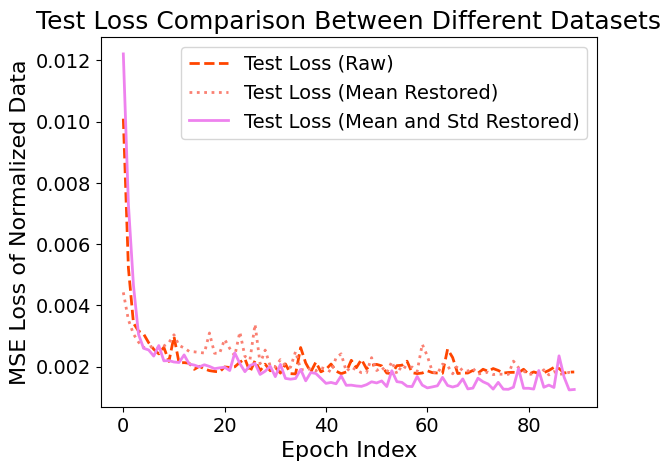

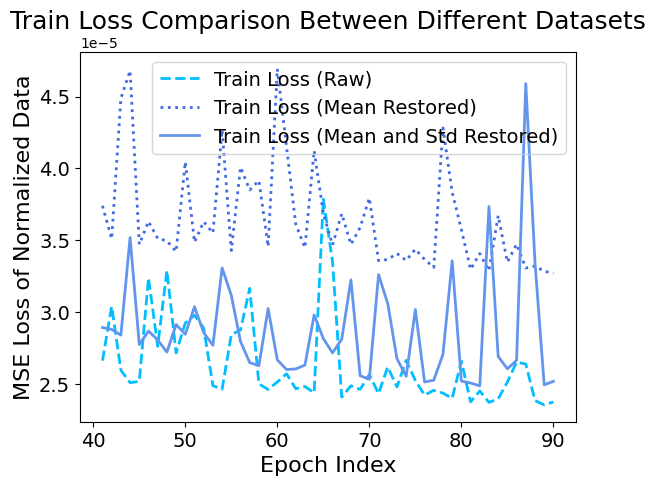

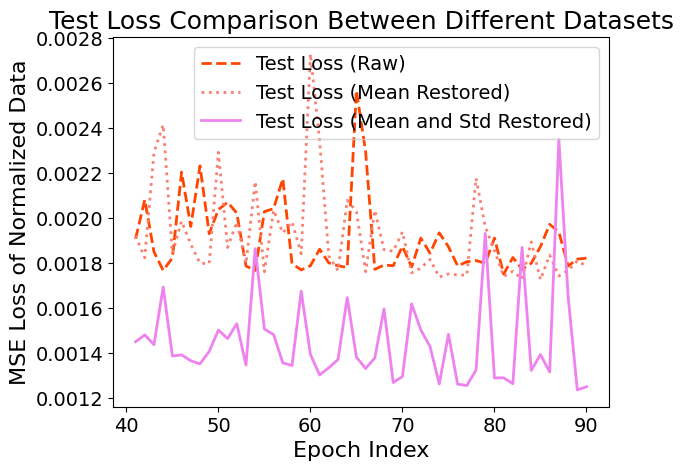

In [226]:
# compare train losses and compare test loss between different types of signal traces

colors_list = [('deepskyblue', 'orangered'), ('royalblue', 'salmon'), ('cornflowerblue', 'violet')]
linestyle_list = ['dashed', 'dotted', 'solid']

plt.figure(figsize=(6.4, 4.8))
for (signal_trace_type, train_loss_list, test_loss_list, colors, linestyle) in zip(
    signal_trace_type_list, list_of_train_loss_lists, list_of_test_loss_lists,
    colors_list, linestyle_list
):
    if signal_trace_type == "Raw Signal Traces":
        type_ = "(Raw)"
    elif signal_trace_type == "Mean Restored Signal Traces":
        type_ = "(Mean Restored)"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        type_ = "(Mean and Std Restored)"
    plt.plot(train_loss_list, color = colors[0], linestyle = linestyle, label=f'Train Loss {type_}', linewidth=2)
    # plt.plot(train_loss_list[-10:], color = colors[0], linestyle = linestyle, label=f'Train Loss {type_}', linewidth=2)
plt.xlabel('Epoch Index', fontsize=16)
plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
plt.tick_params(labelsize=14)
plt.title(f"Train Loss Comparison Between Different Datasets", fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()

plt.figure(figsize=(6.4, 4.8))
for (signal_trace_type, train_loss_list, test_loss_list, colors, linestyle) in zip(
    signal_trace_type_list, list_of_train_loss_lists, list_of_test_loss_lists,
    colors_list, linestyle_list
):
    if signal_trace_type == "Raw Signal Traces":
        type_ = "(Raw)"
    elif signal_trace_type == "Mean Restored Signal Traces":
        type_ = "(Mean Restored)"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        type_ = "(Mean and Std Restored)"
    plt.plot(test_loss_list, color = colors[1], linestyle = linestyle, label=f'Test Loss {type_}', linewidth=2)
    # plt.plot(test_loss_list[-10:], color = colors[1], linestyle = linestyle, label=f'Test Loss {type_}', linewidth=2)
plt.xlabel('Epoch Index', fontsize=16)
plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
plt.tick_params(labelsize=14)
plt.title(f"Test Loss Comparison Between Different Datasets", fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()


# plot last epochs

plt.figure(figsize=(6.4, 4.8))
for (signal_trace_type, train_loss_list, test_loss_list, colors, linestyle) in zip(
    signal_trace_type_list, list_of_train_loss_lists, list_of_test_loss_lists,
    colors_list, linestyle_list
):
    if signal_trace_type == "Raw Signal Traces":
        type_ = "(Raw)"
    elif signal_trace_type == "Mean Restored Signal Traces":
        type_ = "(Mean Restored)"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        type_ = "(Mean and Std Restored)"
    plt.plot(np.arange(len(train_loss_list)+1-50, len(train_loss_list)+1), train_loss_list[-50:], color = colors[0], linestyle = linestyle, label=f'Train Loss {type_}', linewidth=2)
    # plt.plot(train_loss_list[-10:], color = colors[0], linestyle = linestyle, label=f'Train Loss {type_}', linewidth=2)
plt.xlabel('Epoch Index', fontsize=16)
plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
plt.tick_params(labelsize=14)
plt.title(f"Train Loss Comparison Between Different Datasets", fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()

plt.figure(figsize=(6.4, 4.8))
for (signal_trace_type, train_loss_list, test_loss_list, colors, linestyle) in zip(
    signal_trace_type_list, list_of_train_loss_lists, list_of_test_loss_lists,
    colors_list, linestyle_list
):
    if signal_trace_type == "Raw Signal Traces":
        type_ = "(Raw)"
    elif signal_trace_type == "Mean Restored Signal Traces":
        type_ = "(Mean Restored)"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        type_ = "(Mean and Std Restored)"
    plt.plot(np.arange(len(test_loss_list)+1-50, len(test_loss_list)+1), test_loss_list[-50:], color = colors[1], linestyle = linestyle, label=f'Test Loss {type_}', linewidth=2)
    # plt.plot(test_loss_list[-10:], color = colors[1], linestyle = linestyle, label=f'Test Loss {type_}', linewidth=2)
plt.xlabel('Epoch Index', fontsize=16)
plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
plt.tick_params(labelsize=14)
plt.title(f"Test Loss Comparison Between Different Datasets", fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()

The next chunck plots "Comparison between True Labels and Model Outputs" and "Scatter Plot between True Labels and Model Outputs" without training a model but with directly loading the model weights.

data_set.shape: (3, 120, 32500)
label_set.shape: (3, 1, 32500)


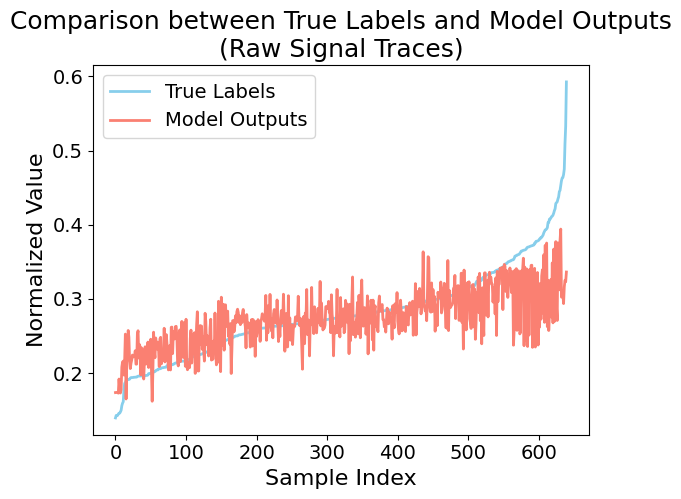

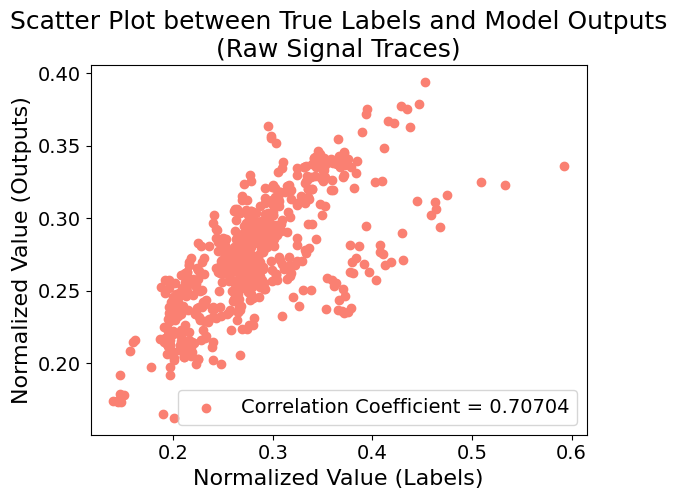

data_set.shape: (3, 120, 32500)
label_set.shape: (3, 1, 32500)


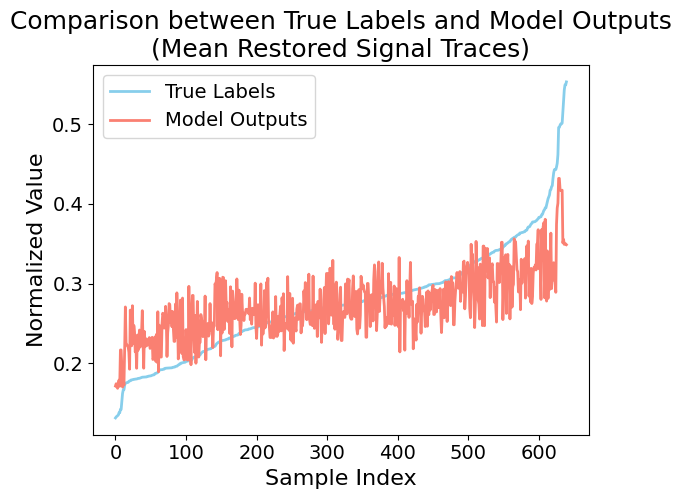

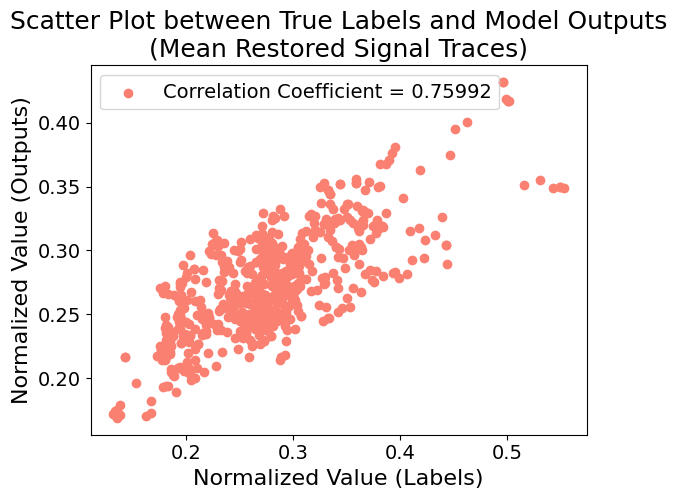

data_set.shape: (3, 120, 32500)
label_set.shape: (3, 1, 32500)


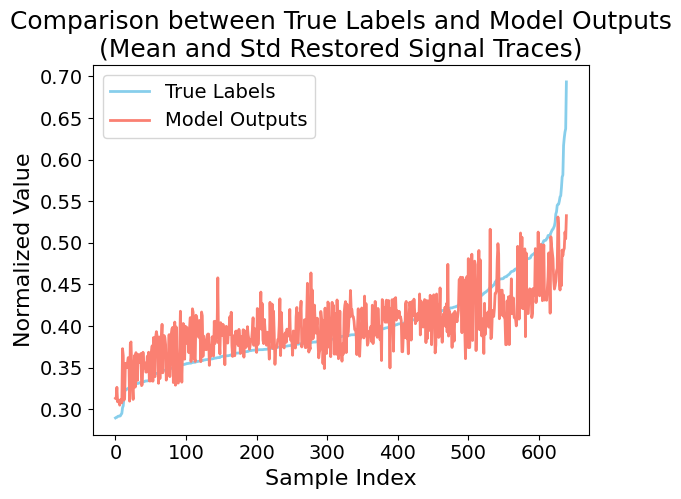

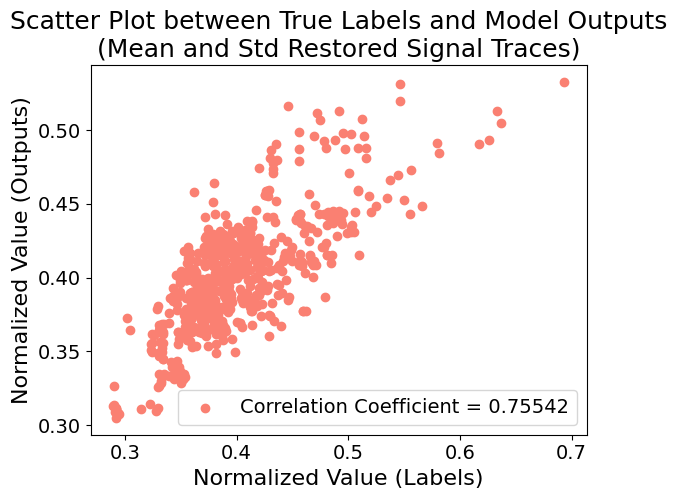

In [227]:
signal_trace_type_list = ["Raw Signal Traces",
                          "Mean Restored Signal Traces",
                          "Mean and Std Restored Signal Traces"]

# signal_trace_type_list = ["Mean Restored Signal Traces",
#                           "Mean and Std Restored Signal Traces"]

# signal_trace_type_list = ["Raw Signal Traces"]
# signal_trace_type_list = ["Mean Restored Signal Traces"]
# signal_trace_type_list = ["Mean and Std Restored Signal Traces"]

for signal_trace_type in signal_trace_type_list:

    if signal_trace_type == "Raw Signal Traces":
        data_set = green_signal_traces.copy()
        label_set = red_signal_traces.copy()
    elif signal_trace_type == "Mean Restored Signal Traces":
        data_set = green_signal_traces_mean_restored.copy()
        label_set = red_signal_traces_mean_restored.copy()
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        data_set = green_signal_traces_mean_restored_std_restored.copy()
        label_set = red_signal_traces_mean_restored_std_restored.copy()

    data_set = data_set[:,valid_com_index_list,:] # use valid components

    print(f"data_set.shape: {data_set.shape}")
    print(f"label_set.shape: {label_set.shape}")

    # # Normalize data_set to [-1,1]
    # data_set_min = np.min(data_set)
    # data_set_max = np.max(data_set)
    # data_set = ((data_set - data_set_min) / (data_set_max - data_set_min) - 0.5) * 2

    # # Normalize label_set to [-1,1]
    # label_set_min = np.min(label_set)
    # label_set_max = np.max(label_set)
    # label_set = ((label_set - label_set_min) / (label_set_max - label_set_min) - 0.5) * 2

    # Normalize data_set to [0,1]
    data_set_min = np.min(data_set)
    data_set_max = np.max(data_set)
    data_set = (data_set - data_set_min) / (data_set_max - data_set_min)

    # Normalize label_set to [0,1]
    label_set_min = np.min(label_set)
    label_set_max = np.max(label_set)
    label_set = (label_set - label_set_min) / (label_set_max - label_set_min)

    # Define dataset class
    class FluoDataset(Dataset):
        def __init__(self, data_set, label_set, z_indices, x_indices):
            self.data_set = data_set
            self.label_set = label_set
            self.z_indices = z_indices
            self.x_indices = x_indices

        def __len__(self):
            return len(self.z_indices)

        def __getitem__(self, idx):
            z = self.z_indices[idx]
            x = self.x_indices[idx]

            input_data = self.data_set[z, :, x-62:x]
            target_label = np.mean(self.label_set[z, :, x-31:x])

            return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_label, dtype=torch.float32)
            # or torch.from_numpy(input_data).float(), torch.from_numpy(target_label).float()

    # Set a random seed for reproducibility
    # np.random.seed(16)  # can use any integer as the seed value

    # Split the data into train and test sets
    length = 6400*2
    choices = range(3)
    choices = range(2) # delete last run
    train_z_indices = np.random.choice(choices, size=length)
    # choices = range(62, 30000)
    choices = list(range(62, 10000)) + list(range(12000, 17000)) + list(range(18244, 32500)) # 90% for train
    # 10000-62+17000-12000+32500-18244=29194, 29194/(32500-62)=90%, 32500-62 is the all data pieces
    train_x_indices = np.random.choice(choices, size=length)

    length = 640
    choices = range(3)
    choices = range(2) # delete last run
    test_z_indices = np.random.choice(choices, size=length)
    # choices = range(62, 30000)
    # choices = range(30000, 32500)
    choices = list(range(10000, 12000)) + list(range(17000, 18244)) # 10% for test
    # 12000-10000+18244-17000=3244, 3244/(32500-62)=10%, 32500-62 is the all data pieces
    test_x_indices = np.random.choice(choices, size=length)

    length = 640 # this is a subset of train data for test on train
    choices = range(3)
    small_train_z_indices = np.random.choice(choices, size=length)
    choices = list(range(9000, 10000)) + list(range(12000, 17000)) + list(range(18244, 19000))
    small_train_x_indices = np.random.choice(choices, size=length)

    train_dataset = FluoDataset(data_set, label_set, train_z_indices, train_x_indices)
    test_dataset = FluoDataset(data_set, label_set, test_z_indices, test_x_indices)
    test_on_train_dataset = FluoDataset(data_set, label_set, small_train_z_indices, small_train_x_indices)

    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_on_train_loader = DataLoader(test_on_train_dataset, batch_size=batch_size, shuffle=False)
    # print(len(train_loader))
    # print(len(test_loader))


    # Define the model
    class FluoModel(nn.Module):
        def __init__(self, component_num):
            super(FluoModel, self).__init__()
            self.fc_shared = nn.Linear(62, 1)  # Shared fully connected layer
            self.fc_reduce = nn.Linear(component_num, 1)  # Fully connected layer to reduce component_num (e.g., 281) channels to 1
            self.sigmoid = nn.Sigmoid()
            self.fc_end = nn.Linear(1, 1)

        def forward(self, x):
            x = x.view(x.size(0), -1, 62)  # Reshape to (batch_size, component_num, 62)

            # Apply the shared fully connected layer along the last dimension (62)
            shared_output = self.fc_shared(x).squeeze(2)
            # self.fc_shared(x) shape is (batch_size, component_num, 1), then squeeze the last dimension
            # In PyTorch, when you apply a fully connected layer (or any other linear
            # transformation) to a 3D tensor, by default, the operation is performed
            # along the last dimension of the tensor.

            # Reduce component_num (e.g., 281) channels to 1 using a separate fully connected layer
            reduced_output = self.fc_reduce(shared_output)
            # pre_output = self.sigmoid(reduced_output)
            pre_output = reduced_output # if without sigmoid
            output = self.fc_end(pre_output)

            return output

    if signal_trace_type == "Raw Signal Traces":
        model_path = f"./{cell_name}_model_with_raw.pth"
    elif signal_trace_type == "Mean Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored.pth"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored_std_restored.pth"

    model = FluoModel(data_set.shape[1])
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model in evaluation mode

    outputs_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            outputs_list.append(outputs.numpy())
            labels_list.append(targets.numpy())

    outputs_array = np.concatenate(outputs_list)
    labels_array = np.concatenate(labels_list)

    # Sort labels and corresponding outputs
    sorted_indices = np.argsort(labels_array)
    sorted_labels = labels_array[sorted_indices]
    sorted_outputs = outputs_array[sorted_indices]

    # plot results
    plt.figure(figsize=(6.4, 4.8))
    plt.plot(sorted_labels, color = 'skyblue', label='True Labels', linewidth=2)
    plt.plot(sorted_outputs, color = 'salmon', label='Model Outputs', linewidth=2)
    plt.xlabel('Sample Index', fontsize=16)
    plt.ylabel('Normalized Value', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.title(f"Comparison between True Labels and Model Outputs\n({signal_trace_type})", fontsize=18)
    plt.legend(fontsize=14, facecolor='none')
    plt.show()


    # Calculate the correlation coefficient
    correlation_coefficient = np.corrcoef(sorted_labels, np.transpose(sorted_outputs))[0, 1]

    # plot results
    plt.figure(figsize=(6.4, 4.8))
    plt.scatter(sorted_labels, sorted_outputs, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    plt.xlabel('Normalized Value (Labels)', fontsize=16)
    plt.ylabel('Normalized Value (Outputs)', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.title(f"Scatter Plot between True Labels and Model Outputs\n({signal_trace_type})", fontsize=18)
    plt.legend(fontsize=14, facecolor='none')
    plt.show()


## below is wrong original code

# signal_trace_type_list = ["Raw Signal Traces",
#                           "Mean Restored Signal Traces",
#                           "Mean and Std Restored Signal Traces"]

# # signal_trace_type_list = ["Mean Restored Signal Traces",
# #                           "Mean and Std Restored Signal Traces"]

# # signal_trace_type_list = ["Raw Signal Traces"]
# # signal_trace_type_list = ["Mean Restored Signal Traces"]
# # signal_trace_type_list = ["Mean and Std Restored Signal Traces"]

# for signal_trace_type in signal_trace_type_list:
#     if signal_trace_type == "Raw Signal Traces":
#         model_path = f"./{cell_name}_model_with_raw.pth"
#     elif signal_trace_type == "Mean Restored Signal Traces":
#         model_path = f"./{cell_name}_model_with_mean_restored.pth"
#     elif signal_trace_type == "Mean and Std Restored Signal Traces":
#         model_path = f"./{cell_name}_model_with_mean_restored_std_restored.pth"

#     model = FluoModel(data_set.shape[1])
#     model.load_state_dict(torch.load(model_path))
#     model.eval()  # Set the model in evaluation mode

#     outputs_list = []
#     labels_list = []

#     with torch.no_grad():
#         for inputs, targets in test_loader:
#             outputs = model(inputs)
#             outputs_list.append(outputs.numpy())
#             labels_list.append(targets.numpy())

#     outputs_array = np.concatenate(outputs_list)
#     labels_array = np.concatenate(labels_list)

#     # Sort labels and corresponding outputs
#     sorted_indices = np.argsort(labels_array)
#     sorted_labels = labels_array[sorted_indices]
#     sorted_outputs = outputs_array[sorted_indices]

#     # Calculate the correlation coefficient
#     correlation_coefficient = np.corrcoef(sorted_labels, np.transpose(sorted_outputs))[0, 1]

#     # plot results
#     plt.figure(figsize=(6.4, 4.8))
#     plt.scatter(sorted_labels, sorted_outputs, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
#     plt.xlabel('Normalized Value (Labels)', fontsize=16)
#     plt.ylabel('Normalized Value (Outputs)', fontsize=16)
#     plt.tick_params(labelsize=14)
#     plt.title(f"Scatter Plot between True Labels and Model Outputs\n({signal_trace_type})", fontsize=18)
#     plt.legend(fontsize=14, facecolor='none')
#     plt.show()

#### Load trained model and see weights

##### absolute weights

Raw Signal Traces

fc_shared weights:
Parameter containing:
tensor([[ 0.0472,  0.0254,  0.0364,  0.0419,  0.0105,  0.0279,  0.0113,  0.0422,
          0.0255,  0.0180,  0.0659,  0.0184,  0.0207,  0.0267,  0.0210,  0.0268,
          0.0338,  0.0334, -0.0009,  0.0528,  0.0388,  0.0184,  0.0132,  0.0423,
          0.0418,  0.0611,  0.0190,  0.0579,  0.0407,  0.0542,  0.0552,  0.0650,
          0.0817,  0.0705,  0.0617,  0.0737,  0.0652,  0.0633,  0.0598,  0.0643,
          0.0434,  0.0655,  0.0505,  0.0627,  0.0418,  0.0687,  0.0256,  0.0534,
          0.0742,  0.0247,  0.0133,  0.0241,  0.0483,  0.0305,  0.0491,  0.0216,
          0.0192,  0.0295,  0.0284,  0.0346,  0.0024,  0.0025]],
       requires_grad=True)

fc_reduce weights:
Parameter containing:
tensor([[-0.1093,  0.0523,  0.1034, -0.0183,  0.1213, -0.1321, -0.0753,  0.0274,
          0.0128,  0.0272,  0.0258, -0.3051,  0.0108,  0.1173, -0.1714, -0.2379,
         -0.1081,  0.0079, -0.0513, -0.1469, -0.0931,  0.1115, -0.0595, -0.03

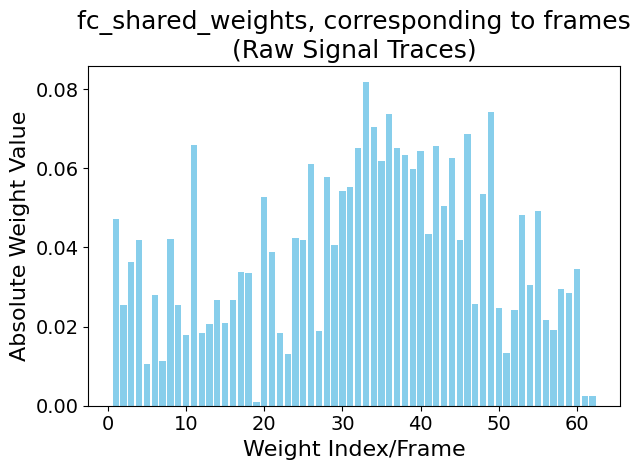

The mean the first 31 weight absolute values of fc_shared_weights is 0.0331958569586277
The mean the last 31 weight absolute values of fc_shared_weights is 0.045777320861816406


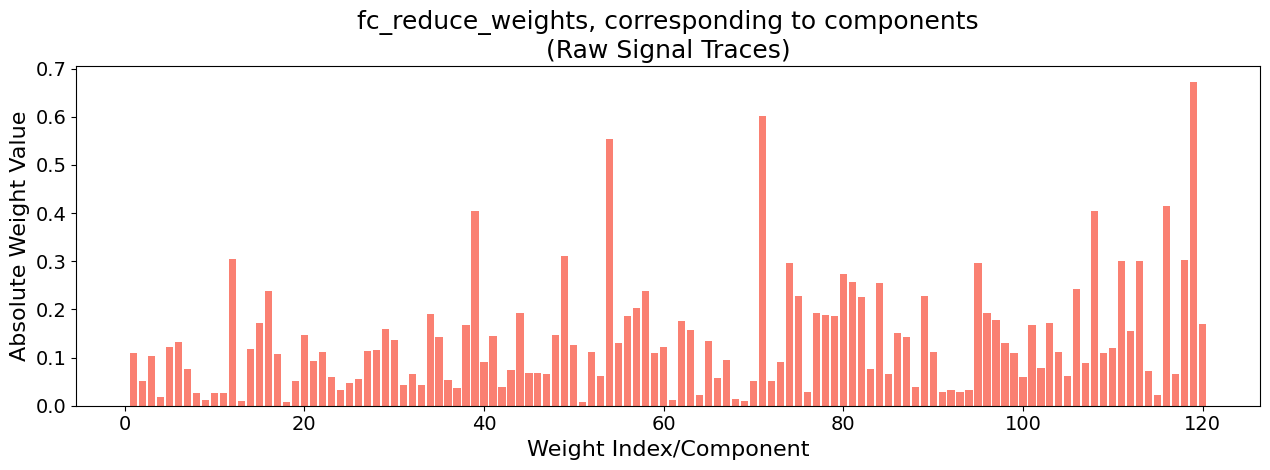

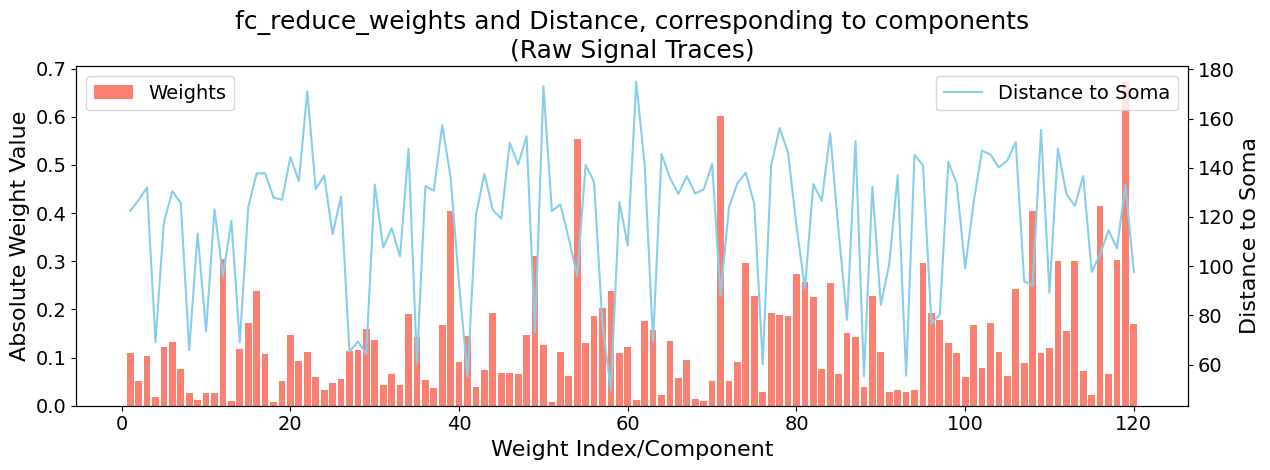

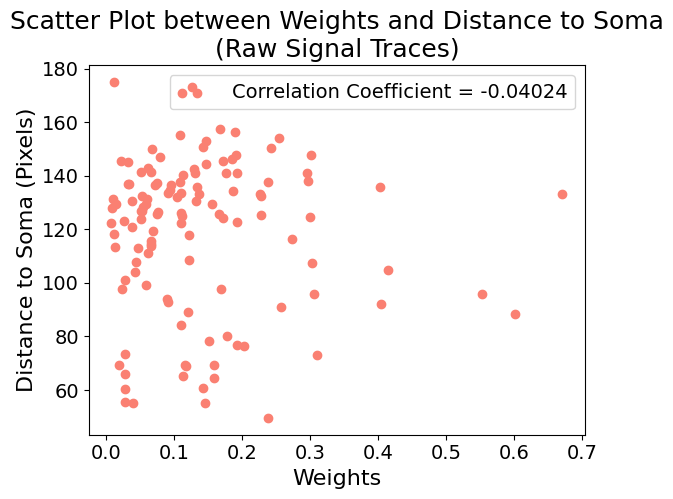

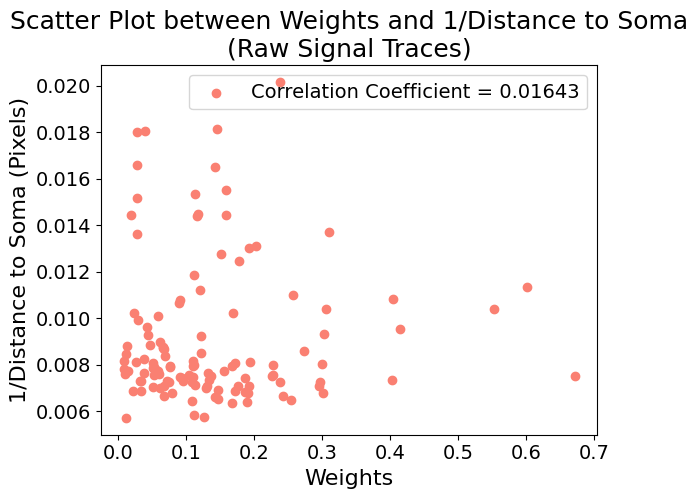

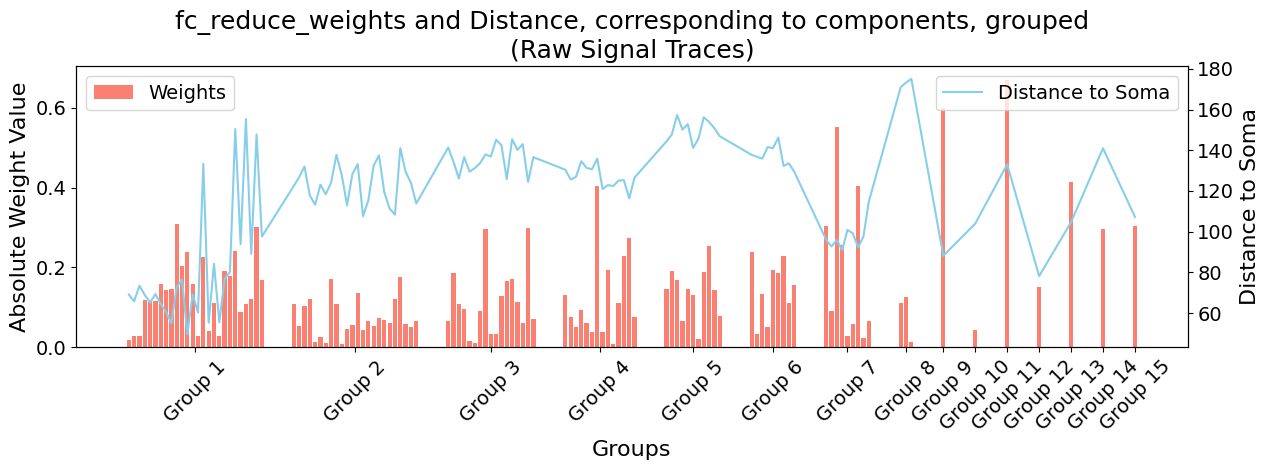

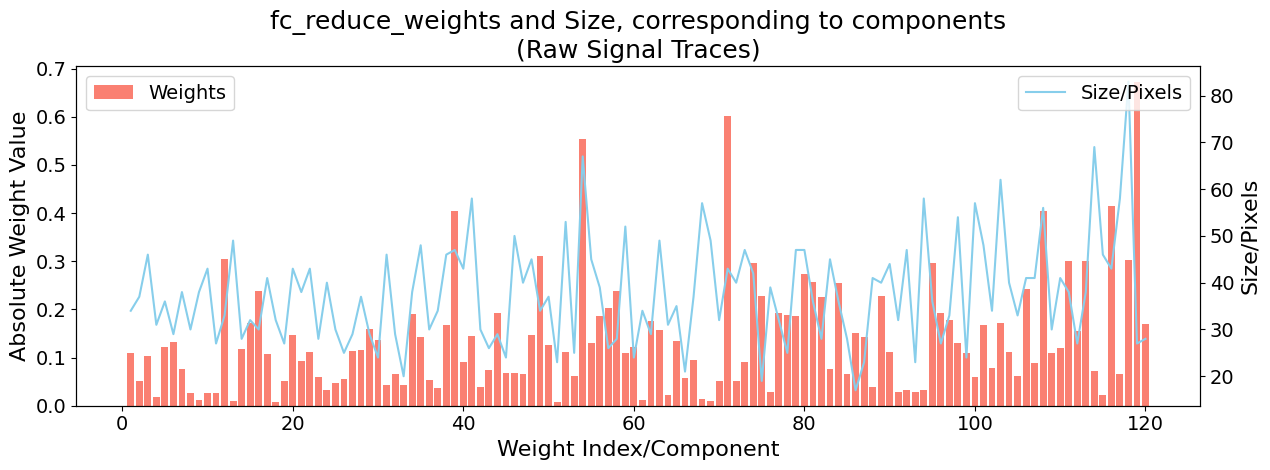

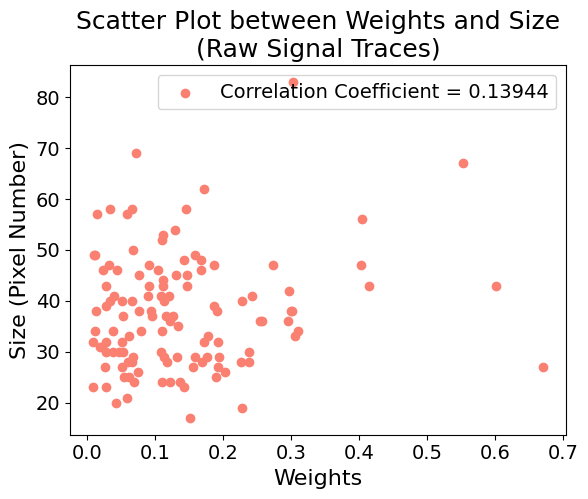

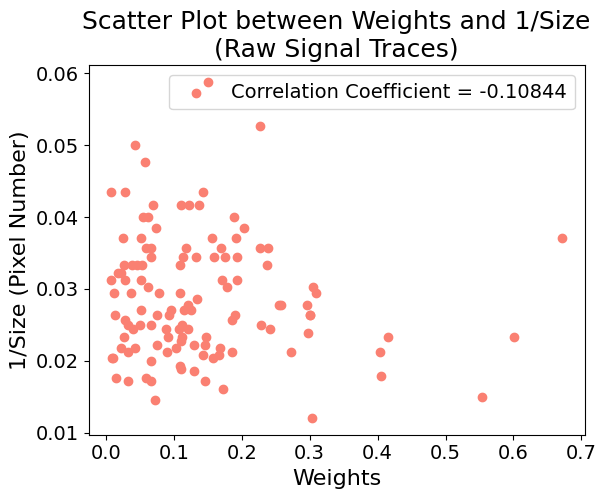

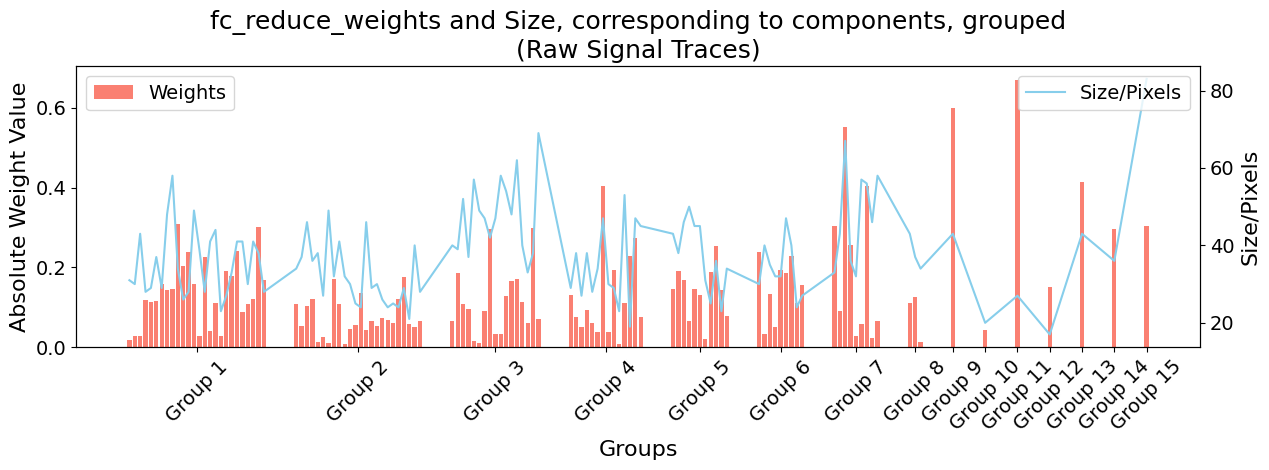

----- ----- -----
Mean Restored Signal Traces

fc_shared weights:
Parameter containing:
tensor([[-0.1661, -0.0890, -0.0365, -0.0250, -0.0335, -0.0394, -0.0801, -0.0314,
         -0.0722, -0.0938, -0.0132, -0.0533,  0.0194, -0.0698, -0.1088, -0.0975,
         -0.0342, -0.0887, -0.0645, -0.0850, -0.0736, -0.0860, -0.0518, -0.0990,
         -0.0982, -0.0171, -0.0874, -0.1612, -0.1127, -0.1177, -0.1207, -0.1614,
         -0.1158, -0.1414, -0.1509, -0.1570, -0.1185, -0.1091, -0.0942, -0.1027,
         -0.1387, -0.0982, -0.1004, -0.0628, -0.1292, -0.1135, -0.0731, -0.0855,
         -0.0807, -0.0923, -0.0891, -0.0880, -0.0584, -0.0426, -0.0452, -0.0449,
         -0.0412, -0.0527,  0.0029, -0.0645,  0.0229, -0.0436]],
       requires_grad=True)

fc_reduce weights:
Parameter containing:
tensor([[ 1.1271e-01,  2.2630e-02, -1.4179e-01,  8.8595e-03, -9.1806e-03,
          1.5094e-01,  2.0172e-01, -1.2389e-01, -1.9659e-01,  5.8235e-02,
         -1.2636e-01,  3.7439e-01,  8.6893e-02, -1.6878e-01,  1

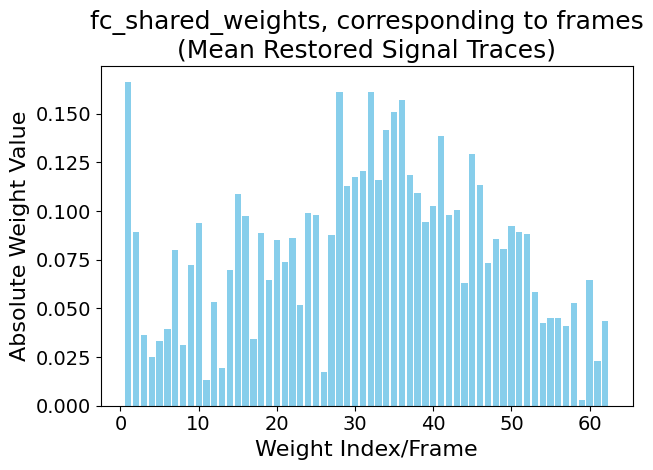

The mean the first 31 weight absolute values of fc_shared_weights is 0.07505770027637482
The mean the last 31 weight absolute values of fc_shared_weights is 0.0877823755145073


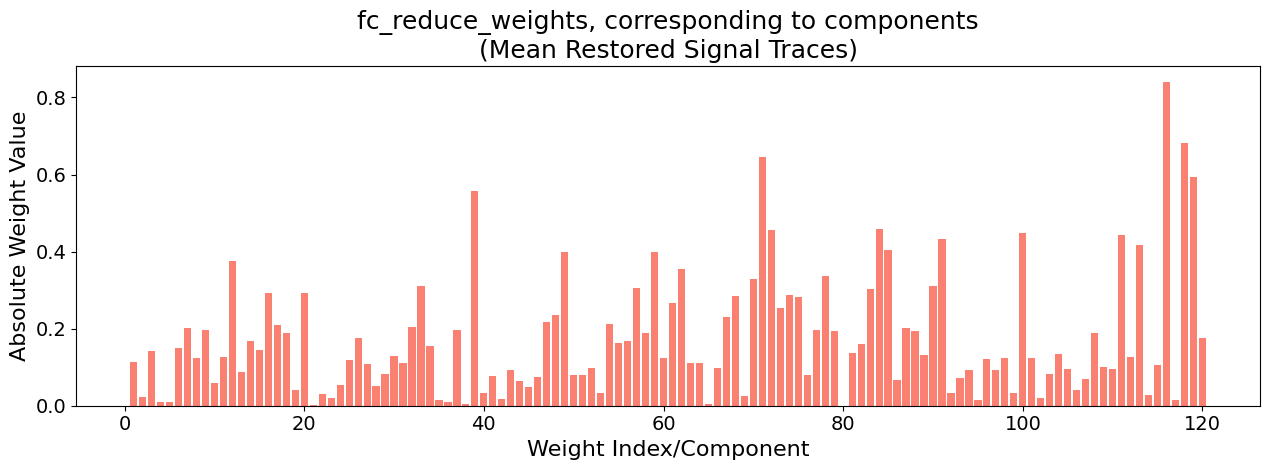

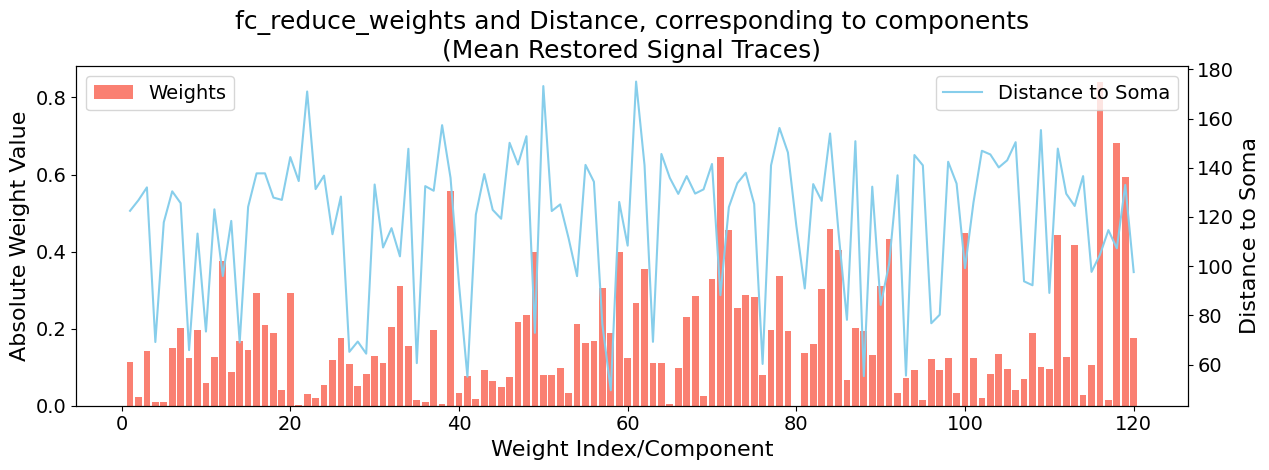

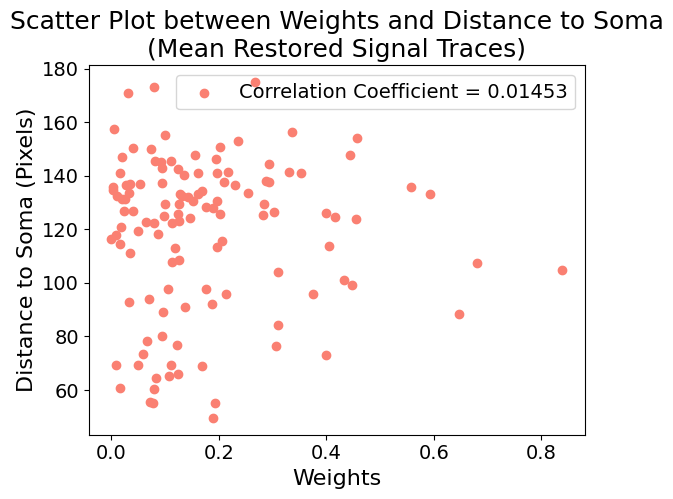

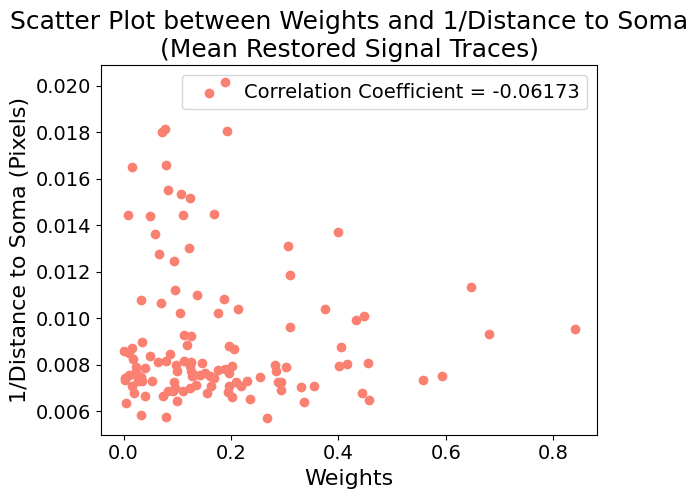

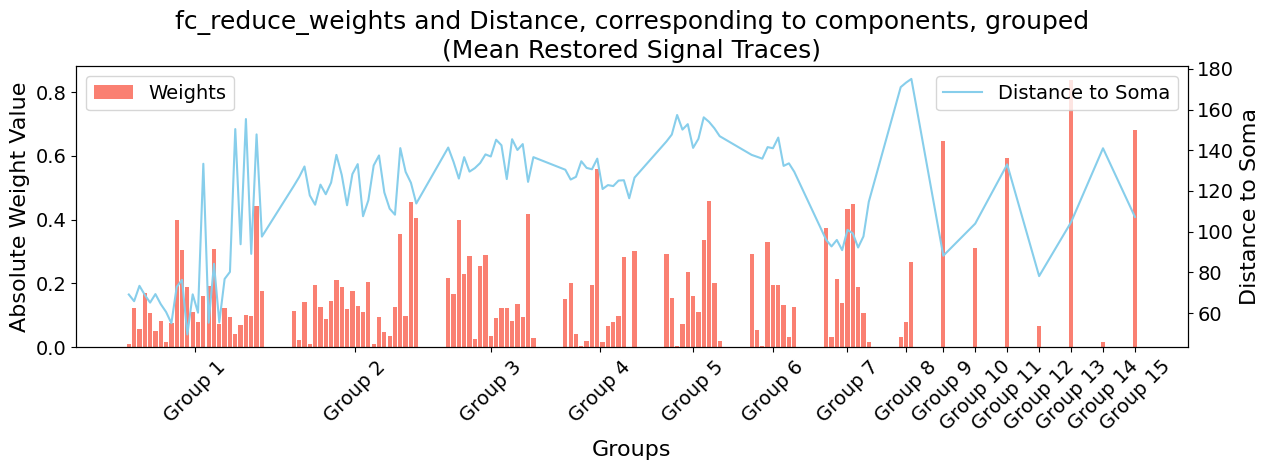

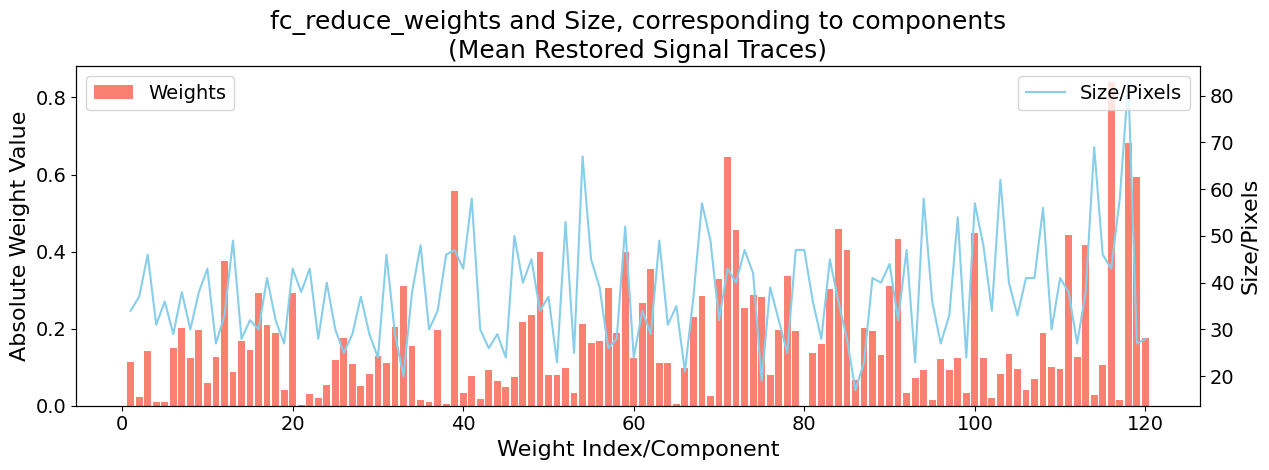

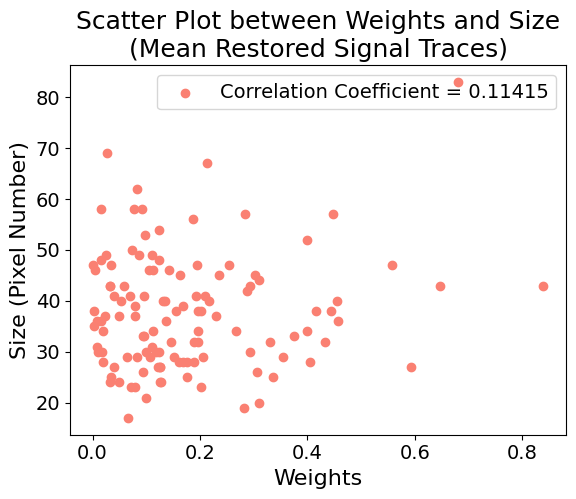

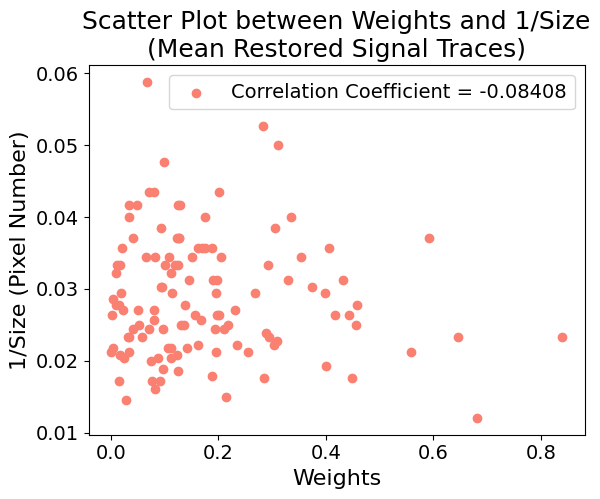

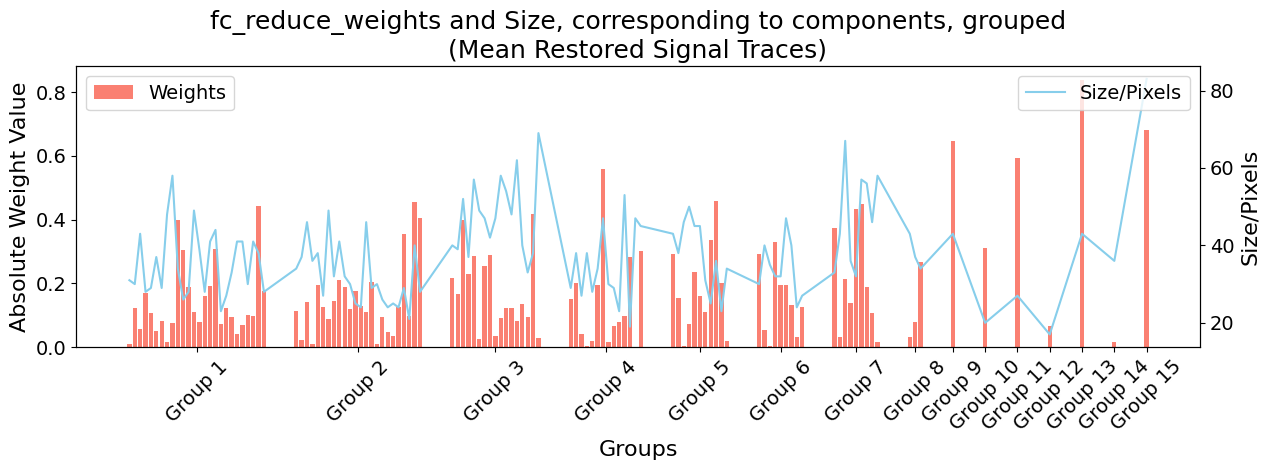

----- ----- -----
Mean and Std Restored Signal Traces

fc_shared weights:
Parameter containing:
tensor([[ 7.9239e-02,  7.2299e-02,  6.8413e-02,  7.8557e-02,  4.2781e-02,
          3.9813e-02,  4.4680e-02,  4.7113e-02,  1.3239e-04,  4.4230e-02,
          5.6159e-02,  9.8698e-02,  3.4265e-02,  5.9799e-02,  3.9487e-02,
          5.7112e-02,  6.8293e-02,  8.3845e-02,  4.4712e-02,  5.4811e-02,
          4.8702e-02,  7.2434e-02,  7.8465e-02,  7.5450e-02,  4.7750e-02,
          2.2796e-02,  1.1456e-01,  1.2514e-01,  4.8598e-02,  1.1791e-01,
          7.6882e-02,  1.2804e-01,  1.4114e-01,  7.4011e-02,  8.6242e-02,
          1.2889e-01,  1.0021e-01,  9.5642e-02,  1.3746e-01,  1.1343e-01,
          8.5867e-02,  9.3883e-02,  1.2320e-01,  6.2831e-02,  1.3131e-01,
          7.7071e-02,  8.7583e-02,  7.1529e-02,  1.9834e-02,  1.0703e-01,
          6.9010e-02,  1.0353e-01,  3.8770e-02,  5.8360e-02,  7.3240e-02,
         -1.8900e-02,  5.7890e-02,  5.2080e-04,  6.7304e-02,  1.2460e-02,
         -4.3821

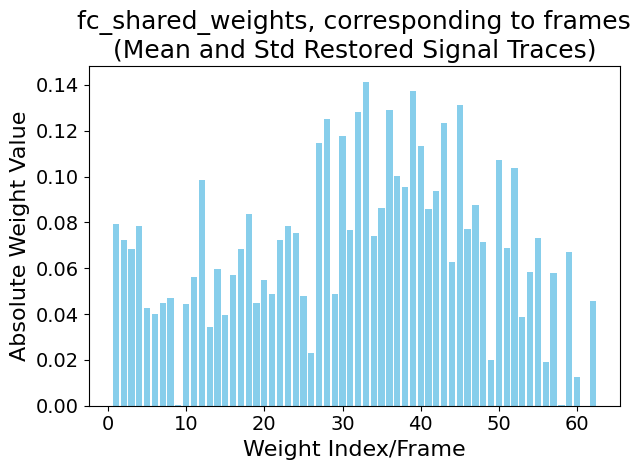

The mean the first 31 weight absolute values of fc_shared_weights is 0.06268154084682465
The mean the last 31 weight absolute values of fc_shared_weights is 0.07776954025030136


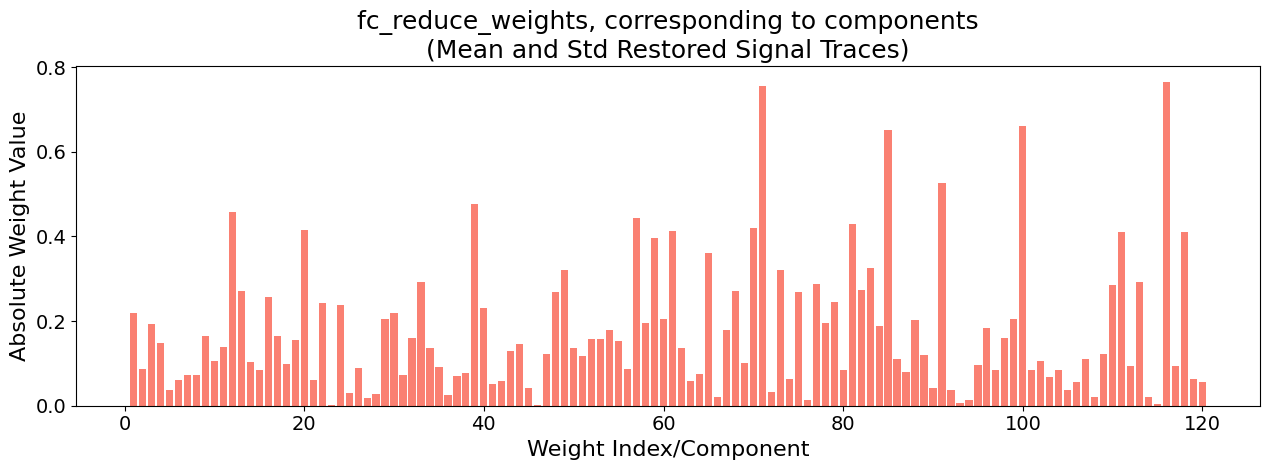

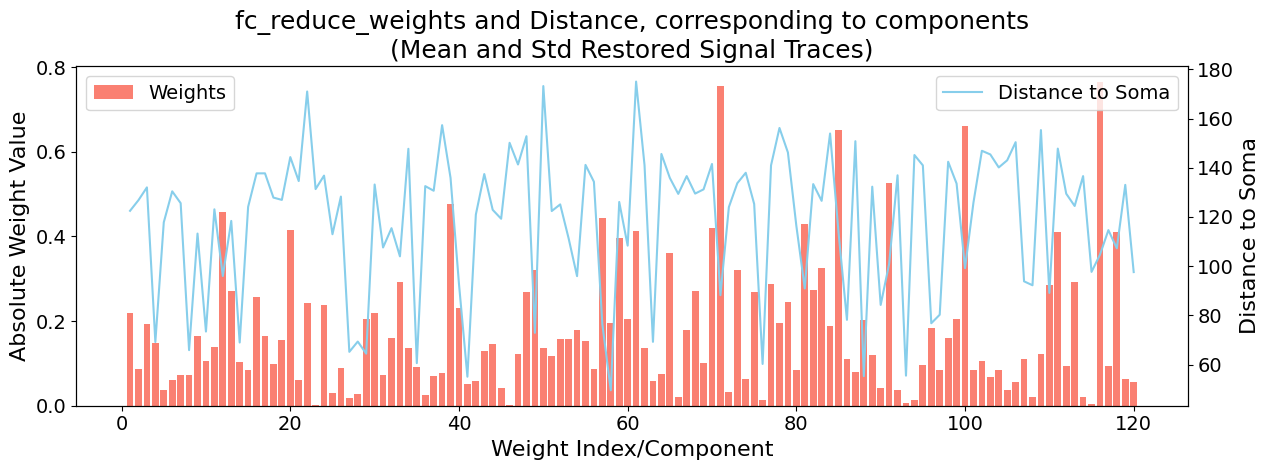

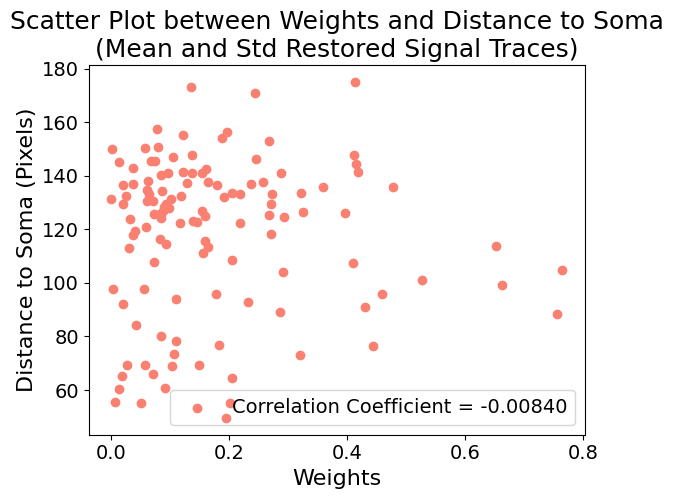

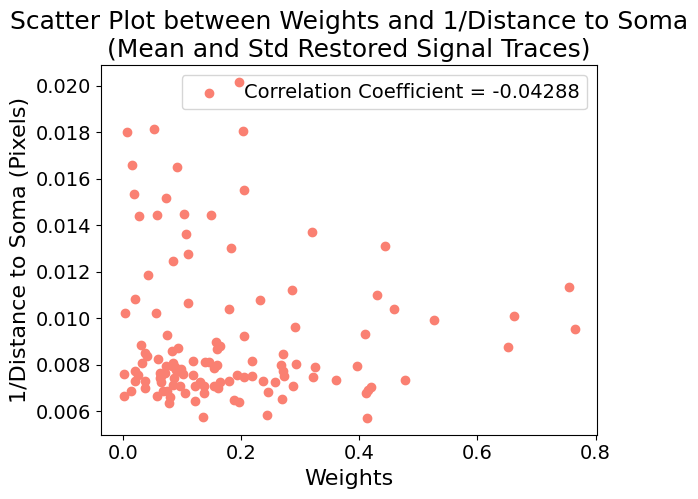

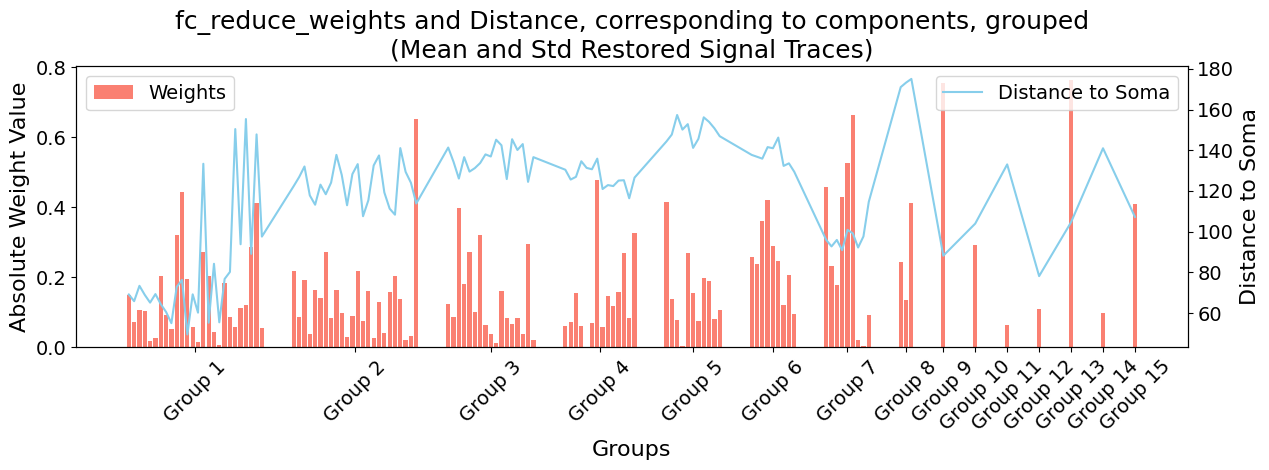

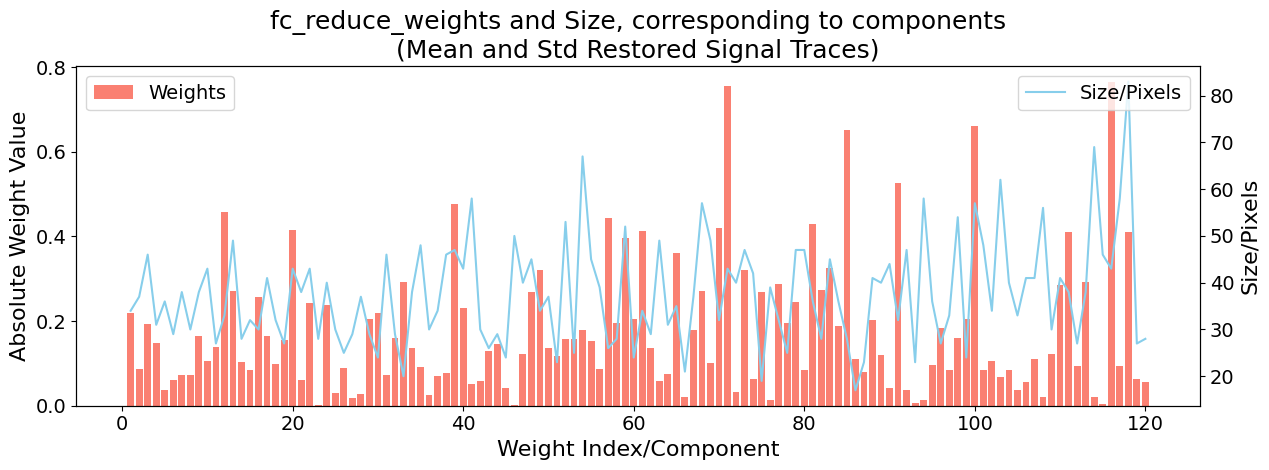

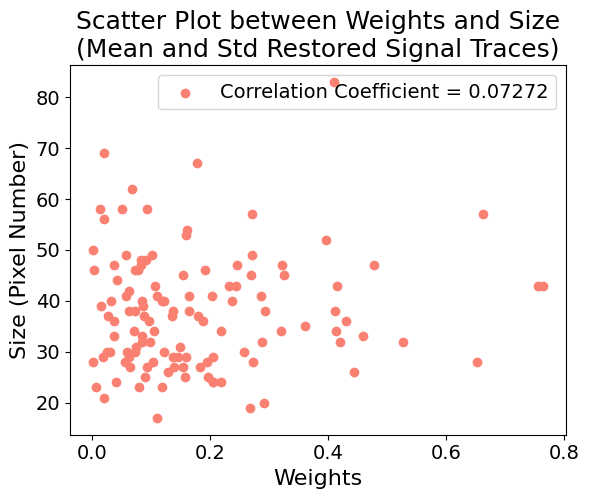

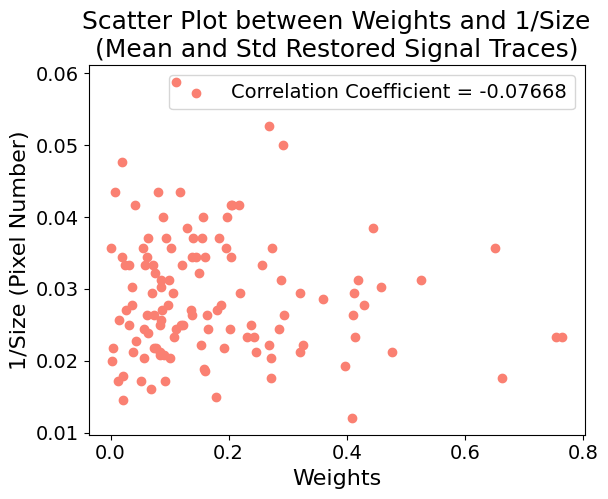

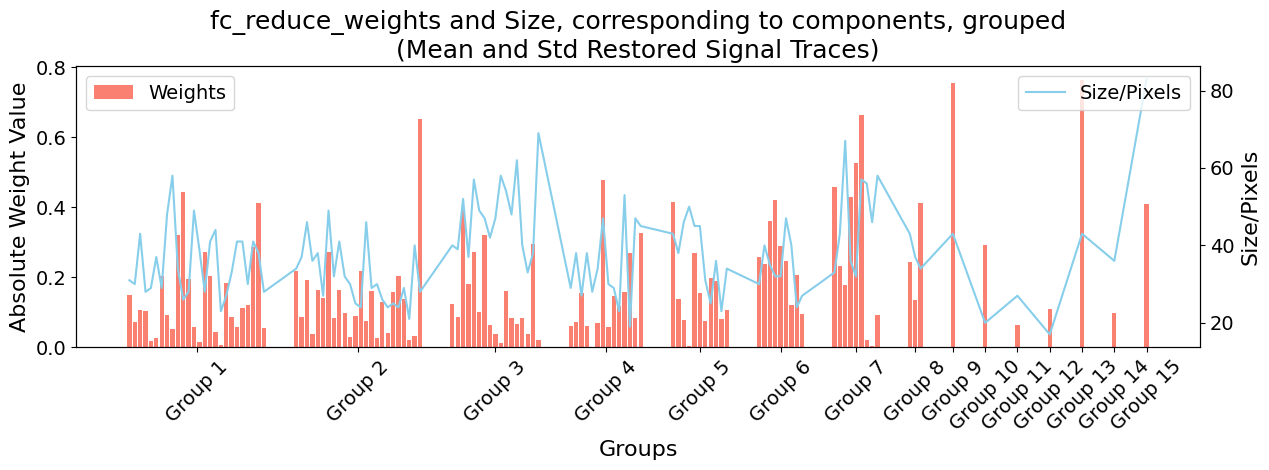

----- ----- -----


In [228]:
signal_trace_type_list = ["Raw Signal Traces", "Mean Restored Signal Traces", "Mean and Std Restored Signal Traces"]
# signal_trace_type_list = ["Mean Restored Signal Traces", "Mean and Std Restored Signal Traces"]
# signal_trace_type_list = ["Mean and Std Restored Signal Traces"]

root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"
path_ = os.path.join(root_path, cell_name, cell_name + 'green_Axon.mat')
mat_data = scipy.io.loadmat(path_)
axons = mat_data['Axons']
# Squeeze the outer array
axons = np.squeeze(axons, axis=0)
for i in range(len(axons)):
    # Squeeze the inner array and convert the data type to 'int'
    axons[i] = np.squeeze(axons[i].astype(int), axis=0)

valid_com_index_from_one_list = np.array(valid_com_index_list) + 1

# Convert axons to index form thereby consistent with the index of remained components
index_form_axons = copy.deepcopy(axons)
for i, axon in enumerate(axons):
    for j, bouton in enumerate(axon):
        index_form_axons[i][j] = np.where(valid_com_index_from_one_list == bouton)[0]
flat_index_form_axons = np.concatenate(index_form_axons)


for signal_trace_type in signal_trace_type_list:

    model = FluoModel(data_set.shape[1])

    if signal_trace_type == "Raw Signal Traces":
        model_path = f"./{cell_name}_model_with_raw.pth"
    elif signal_trace_type == "Mean Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored.pth"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored_std_restored.pth"

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    # access the weights for each layer
    fc_shared_weights = model.fc_shared.weight
    fc_reduce_weights = model.fc_reduce.weight
    fc_end_weights = model.fc_end.weight

    # access the biases if needed
    fc_shared_biases = model.fc_shared.bias
    fc_reduce_biases = model.fc_reduce.bias
    fc_end_biases = model.fc_end.bias

    print(f"{signal_trace_type}")

    # Weights
    print("\nfc_shared weights:")
    print(fc_shared_weights)

    print("\nfc_reduce weights:")
    print(fc_reduce_weights)

    print("\nfc_end weights:")
    print(fc_end_weights)

    # Biases
    print("\nfc_shared biases:")
    print(fc_shared_biases)

    print("\nfc_reduce biases:")
    print(fc_reduce_biases)

    print("\nfc_end biases:")
    print(fc_end_biases)

    # Access the weights
    fc_shared_weights = fc_shared_weights.detach().numpy().flatten()
    fc_reduce_weights = fc_reduce_weights.detach().numpy().flatten()



    ##### Create subplots (weights abs)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Plot fc_shared_weights
    ax1.bar(range(1,len(fc_shared_weights)+1), np.abs(fc_shared_weights), color='skyblue')
    ax1.set_title(f'fc_shared_weights, corresponding to frames\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Weight Index/Frame', fontsize=16)
    ax1.set_ylabel('Absolute Weight Value', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()

    half_len = int(len(fc_shared_weights)/2)
    print(f"The mean the first {half_len} weight absolute values of fc_shared_weights is {np.mean(np.abs(fc_shared_weights)[:half_len])}")
    print(f"The mean the last {half_len} weight absolute values of fc_shared_weights is {np.mean(np.abs(fc_shared_weights)[half_len:])}")


    # Create subplots (1 y axis)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

    # Plot fc_reduce_weights
    ax1.bar(range(1,len(fc_reduce_weights)+1), np.abs(fc_reduce_weights), color='salmon')
    ax1.set_title(f'fc_reduce_weights, corresponding to components\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Weight Index/Component', fontsize=16)
    ax1.set_ylabel('Absolute Weight Value', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()



    ##### Create subplots (2 y axes, weights abs and distance)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))
    x = np.arange(1, len(fc_reduce_weights) + 1)

    # Plot fc_reduce_weights
    ax1.bar(x, np.abs(fc_reduce_weights), color='salmon', label = 'Weights')
    ax1.set_title(f'fc_reduce_weights and Distance, corresponding to components\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Weight Index/Component', fontsize=16)
    ax1.set_ylabel('Absolute Weight Value', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second curve
    ax2.plot(x, valid_dis_list, color='skyblue', label='Distance to Soma')
    ax2.set_ylabel('Distance to Soma', fontsize=16)
    ax2.tick_params(axis='y', labelsize=14)

    # Adding legend for the second curve
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()



    ##### Create subplots (correlation between weights abs and distance)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Calculate the correlation coefficient
    sorted_indices = np.argsort(np.abs(fc_reduce_weights))
    sorted_valid_dis_list = np.array(valid_dis_list)[sorted_indices]
    sorted_abs_fc_reduce_weights = np.abs(fc_reduce_weights)[sorted_indices]
    correlation_coefficient = np.corrcoef(sorted_abs_fc_reduce_weights, np.transpose(sorted_valid_dis_list))[0, 1]

    # plot results
    ax1.scatter(sorted_abs_fc_reduce_weights, sorted_valid_dis_list, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    ax1.set_xlabel('Weights', fontsize=16)
    ax1.set_ylabel('Distance to Soma (Pixels)', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(f"Scatter Plot between Weights and Distance to Soma\n({signal_trace_type})", fontsize=18)
    ax1.legend(fontsize=14, facecolor='none')
    plt.show()



    ##### Create subplots (correlation between weights abs and 1/distance)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Calculate the correlation coefficient
    sorted_indices = np.argsort(np.abs(fc_reduce_weights))
    sorted_valid_dis_list = np.array(valid_dis_list)[sorted_indices]
    sorted_abs_fc_reduce_weights = np.abs(fc_reduce_weights)[sorted_indices]
    correlation_coefficient = np.corrcoef(sorted_abs_fc_reduce_weights, np.transpose(1/sorted_valid_dis_list))[0, 1]

    # plot results
    ax1.scatter(sorted_abs_fc_reduce_weights, 1/sorted_valid_dis_list, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    ax1.set_xlabel('Weights', fontsize=16)
    ax1.set_ylabel('1/Distance to Soma (Pixels)', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(f"Scatter Plot between Weights and 1/Distance to Soma\n({signal_trace_type})", fontsize=18)
    ax1.legend(fontsize=14, facecolor='none')
    plt.show()



    ##### Create subplots (2 y axes, weights abs and distance, grouped)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

    # Reorder fc_reduce_weights and valid_dis_list based on group_indices
    reordered_fc_reduce_weights = [fc_reduce_weights[idx] for idx in flat_index_form_axons]
    reordered_valid_dis_list = [valid_dis_list[idx] for idx in flat_index_form_axons]

    # Create x-labels for groups
    x_labels = [f"Group {i+1}" for i in range(len(index_form_axons))]

    # Bar plot for fc_reduce_weights
    x = np.arange(1, len(flat_index_form_axons) + 1)
    index__ = 0
    for axon in index_form_axons:
        index__ = index__ + len(axon)
        if index__ < len(flat_index_form_axons):
            x[index__:] = x[index__:] + 5 # generate gap space on x axis between groups

    break_indices = np.where(np.diff(x) != 1)[0]
    x_labels_center = [(x[start] + x[end]) / 2 for start, end in zip(np.insert(break_indices + 1, 0, 0), break_indices)]
    x_labels_center.append((x[break_indices[-1]+1] + x[-1])/2)

    ax1.bar(x, np.abs(reordered_fc_reduce_weights), color='salmon', label='Weights')
    ax1.set_title(f'fc_reduce_weights and Distance, corresponding to components, grouped\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Groups', fontsize=16)
    ax1.set_ylabel('Absolute Weight Value', fontsize=16)
    ax1.set_xticks(x_labels_center)
    ax1.set_xticklabels(x_labels, rotation=45, fontsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second curve (valid_dis_list)
    ax2.plot(x, reordered_valid_dis_list, color='skyblue', label='Distance to Soma')
    ax2.set_ylabel('Distance to Soma', fontsize=16)
    ax2.tick_params(axis='y', labelsize=14)

    # Adding legend for both curves
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()



    ##### Create subplots (2 y axes, weights abs and size)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))
    x = np.arange(1, len(fc_reduce_weights) + 1)

    # Plot fc_reduce_weights
    ax1.bar(x, np.abs(fc_reduce_weights), color='salmon', label = 'Weights')
    ax1.set_title(f'fc_reduce_weights and Size, corresponding to components\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Weight Index/Component', fontsize=16)
    ax1.set_ylabel('Absolute Weight Value', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second curve
    ax2.plot(x, valid_size_list, color='skyblue', label='Size/Pixels')
    ax2.set_ylabel('Size/Pixels', fontsize=16)
    ax2.tick_params(axis='y', labelsize=14)

    # Adding legend for the second curve
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()



    ##### Create subplots (correlation between weights abs and size)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Calculate the correlation coefficient
    sorted_indices = np.argsort(np.abs(fc_reduce_weights))
    sorted_valid_size_list = np.array(valid_size_list)[sorted_indices]
    sorted_abs_fc_reduce_weights = np.abs(fc_reduce_weights)[sorted_indices]
    correlation_coefficient = np.corrcoef(sorted_abs_fc_reduce_weights, np.transpose(sorted_valid_size_list))[0, 1]

    # plot results
    ax1.scatter(sorted_abs_fc_reduce_weights, sorted_valid_size_list, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    ax1.set_xlabel('Weights', fontsize=16)
    ax1.set_ylabel('Size (Pixel Number)', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(f"Scatter Plot between Weights and Size\n({signal_trace_type})", fontsize=18)
    ax1.legend(fontsize=14, facecolor='none')
    plt.show()



    ##### Create subplots (correlation between weights abs and 1/size)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Calculate the correlation coefficient
    sorted_indices = np.argsort(np.abs(fc_reduce_weights))
    sorted_valid_size_list = np.array(valid_size_list)[sorted_indices]
    sorted_abs_fc_reduce_weights = np.abs(fc_reduce_weights)[sorted_indices]
    correlation_coefficient = np.corrcoef(sorted_abs_fc_reduce_weights, np.transpose(1/sorted_valid_size_list))[0, 1]

    # plot results
    ax1.scatter(sorted_abs_fc_reduce_weights, 1/sorted_valid_size_list, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    ax1.set_xlabel('Weights', fontsize=16)
    ax1.set_ylabel('1/Size (Pixel Number)', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(f"Scatter Plot between Weights and 1/Size\n({signal_trace_type})", fontsize=18)
    ax1.legend(fontsize=14, facecolor='none')
    plt.show()



    ##### Create subplots (2 y axes, weight abs and size, grouped)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

    # Reorder fc_reduce_weights and valid_dis_list based on group_indices
    reordered_fc_reduce_weights = [fc_reduce_weights[idx] for idx in flat_index_form_axons]
    reordered_valid_size_list = [valid_size_list[idx] for idx in flat_index_form_axons]

    # Create x-labels for groups
    x_labels = [f"Group {i+1}" for i in range(len(index_form_axons))]

    # Bar plot for fc_reduce_weights
    x = np.arange(1, len(flat_index_form_axons) + 1)
    index__ = 0
    for axon in index_form_axons:
        index__ = index__ + len(axon)
        if index__ < len(flat_index_form_axons):
            x[index__:] = x[index__:] + 5

    break_indices = np.where(np.diff(x) != 1)[0]
    x_labels_center = [(x[start] + x[end]) / 2 for start, end in zip(np.insert(break_indices + 1, 0, 0), break_indices)]
    x_labels_center.append((x[break_indices[-1]+1] + x[-1])/2)

    ax1.bar(x, np.abs(reordered_fc_reduce_weights), color='salmon', label='Weights')
    ax1.set_title(f'fc_reduce_weights and Size, corresponding to components, grouped\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Groups', fontsize=16)
    ax1.set_ylabel('Absolute Weight Value', fontsize=16)
    ax1.set_xticks(x_labels_center)
    ax1.set_xticklabels(x_labels, rotation=45, fontsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second curve (valid_dis_list)
    ax2.plot(x, reordered_valid_size_list, color='skyblue', label='Size/Pixels')
    ax2.set_ylabel('Size/Pixels', fontsize=16)
    ax2.tick_params(axis='y', labelsize=14)

    # Adding legend for both curves
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()

    print("----- ----- -----")



##### original weights

Raw Signal Traces

fc_shared weights:
Parameter containing:
tensor([[ 0.0472,  0.0254,  0.0364,  0.0419,  0.0105,  0.0279,  0.0113,  0.0422,
          0.0255,  0.0180,  0.0659,  0.0184,  0.0207,  0.0267,  0.0210,  0.0268,
          0.0338,  0.0334, -0.0009,  0.0528,  0.0388,  0.0184,  0.0132,  0.0423,
          0.0418,  0.0611,  0.0190,  0.0579,  0.0407,  0.0542,  0.0552,  0.0650,
          0.0817,  0.0705,  0.0617,  0.0737,  0.0652,  0.0633,  0.0598,  0.0643,
          0.0434,  0.0655,  0.0505,  0.0627,  0.0418,  0.0687,  0.0256,  0.0534,
          0.0742,  0.0247,  0.0133,  0.0241,  0.0483,  0.0305,  0.0491,  0.0216,
          0.0192,  0.0295,  0.0284,  0.0346,  0.0024,  0.0025]],
       requires_grad=True)

fc_reduce weights:
Parameter containing:
tensor([[-0.1093,  0.0523,  0.1034, -0.0183,  0.1213, -0.1321, -0.0753,  0.0274,
          0.0128,  0.0272,  0.0258, -0.3051,  0.0108,  0.1173, -0.1714, -0.2379,
         -0.1081,  0.0079, -0.0513, -0.1469, -0.0931,  0.1115, -0.0595, -0.03

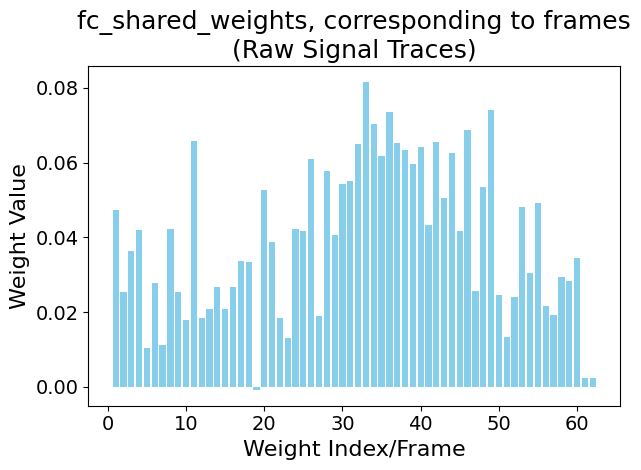

The mean the first 31 weight values of fc_shared_weights is 0.03313804045319557
The mean the last 31 weight values of fc_shared_weights is 0.045777320861816406


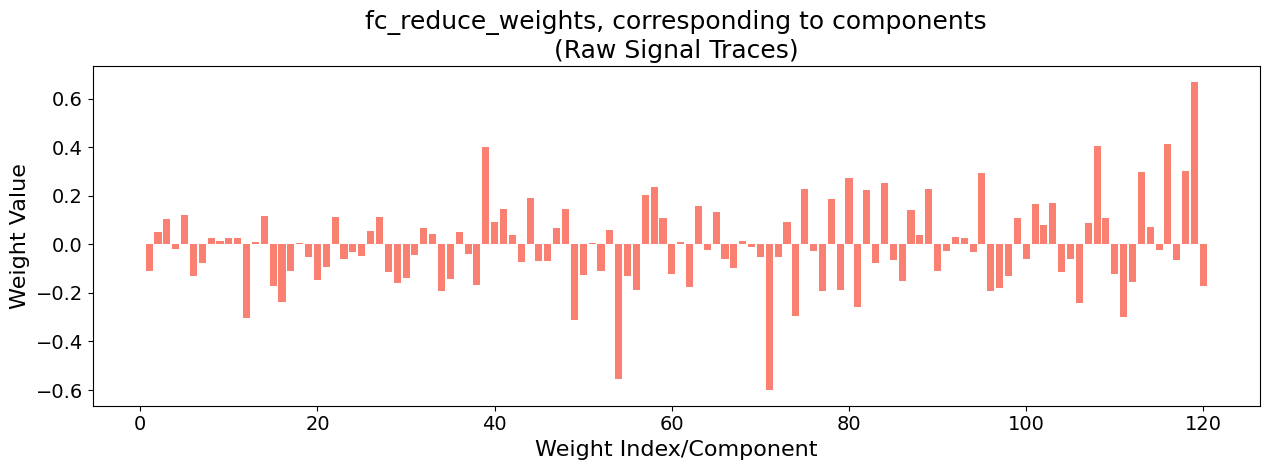

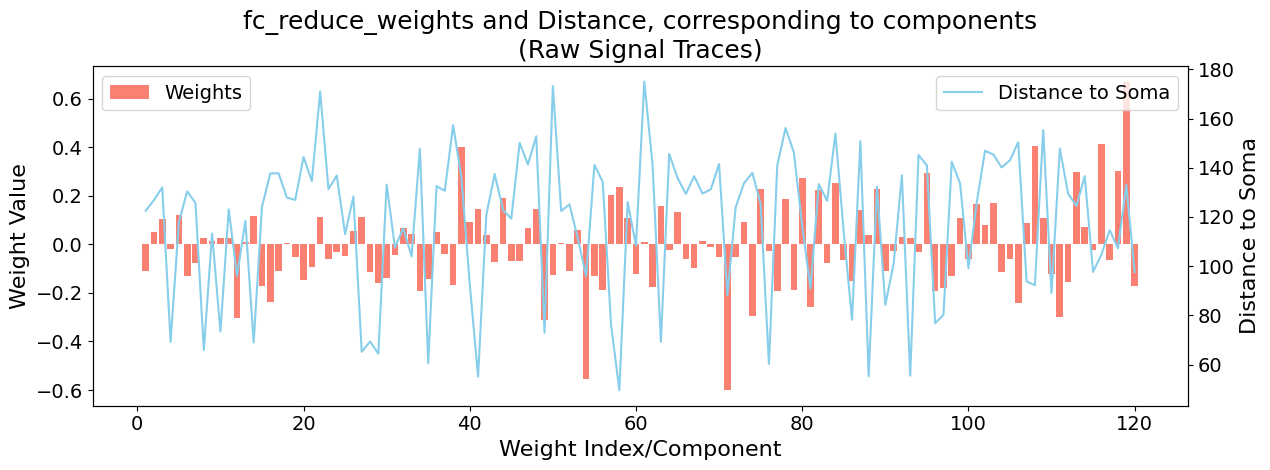

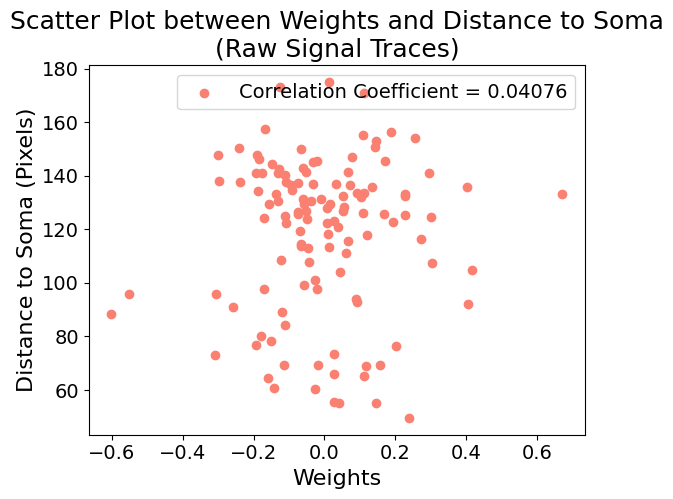

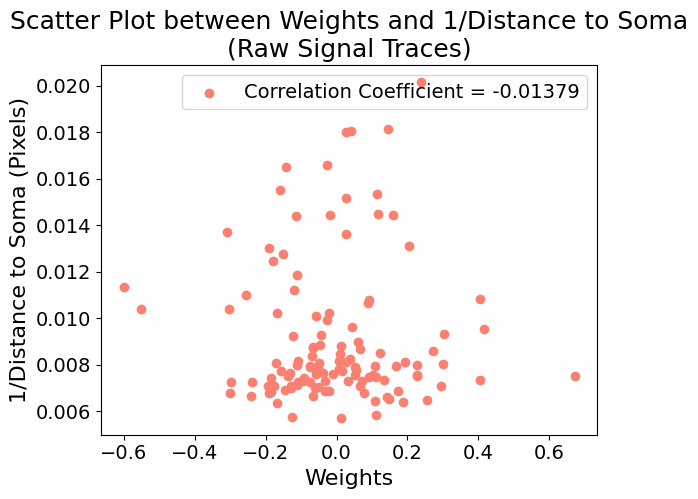

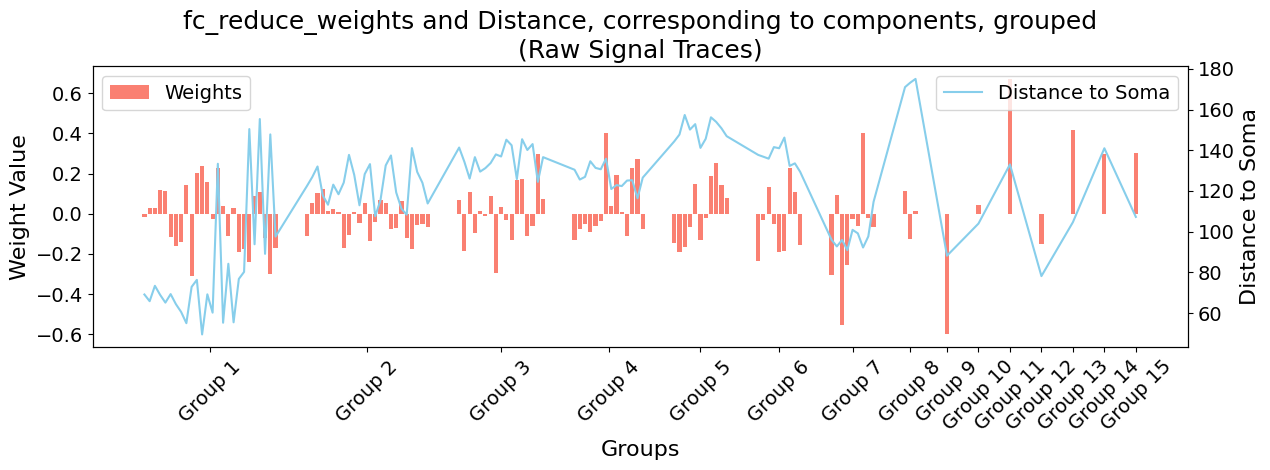

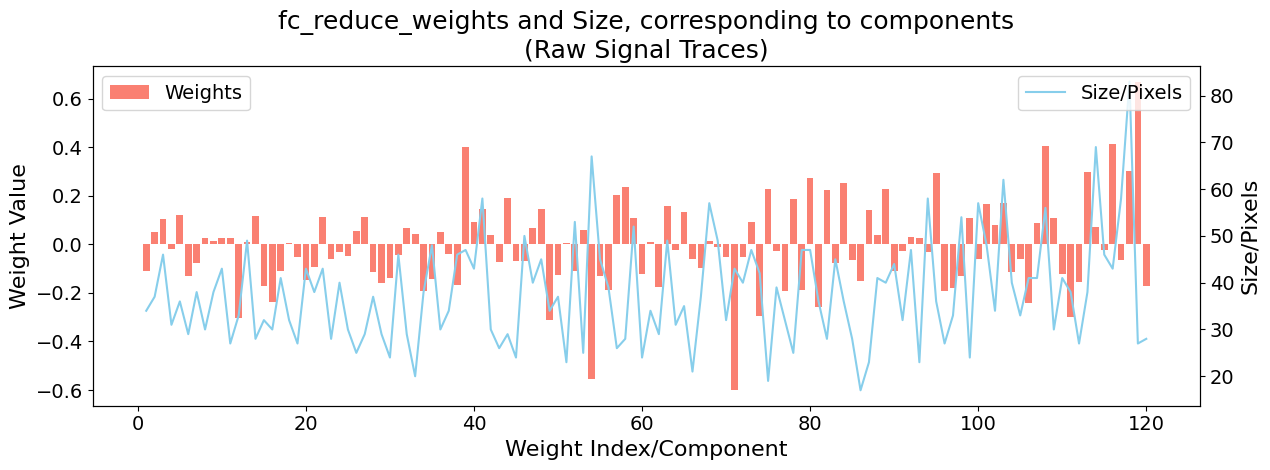

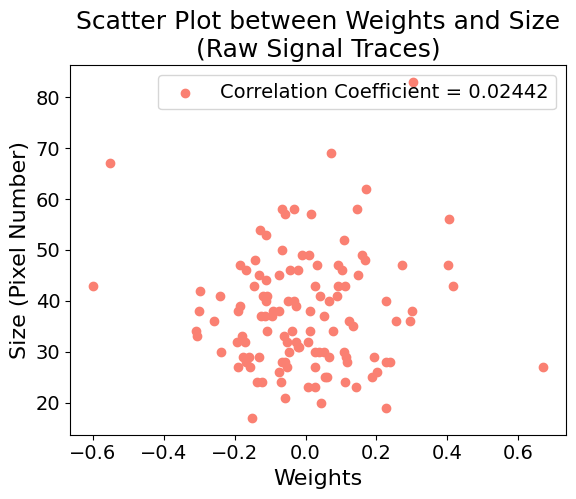

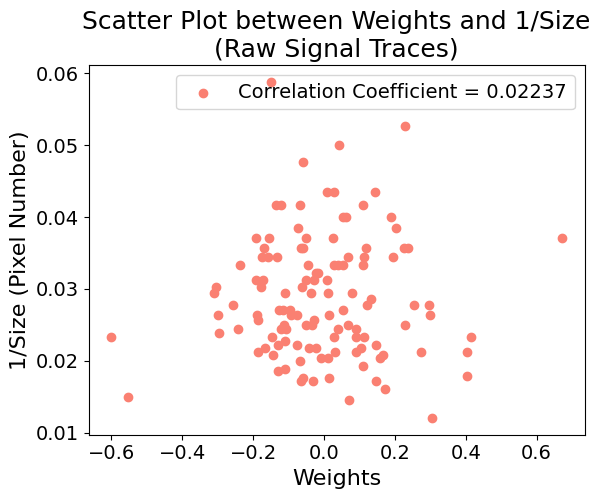

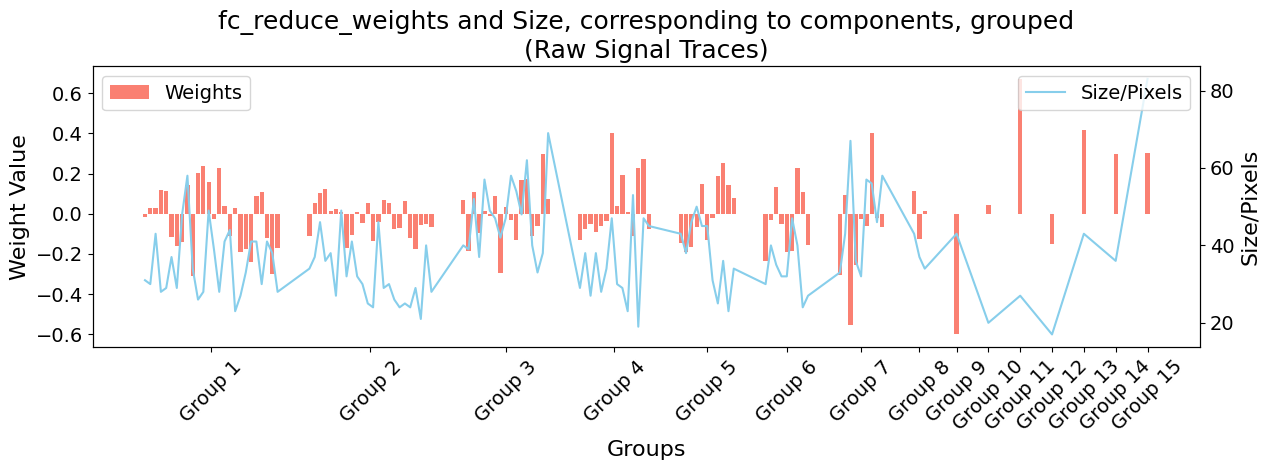

----- ----- -----
Mean Restored Signal Traces

fc_shared weights:
Parameter containing:
tensor([[-0.1661, -0.0890, -0.0365, -0.0250, -0.0335, -0.0394, -0.0801, -0.0314,
         -0.0722, -0.0938, -0.0132, -0.0533,  0.0194, -0.0698, -0.1088, -0.0975,
         -0.0342, -0.0887, -0.0645, -0.0850, -0.0736, -0.0860, -0.0518, -0.0990,
         -0.0982, -0.0171, -0.0874, -0.1612, -0.1127, -0.1177, -0.1207, -0.1614,
         -0.1158, -0.1414, -0.1509, -0.1570, -0.1185, -0.1091, -0.0942, -0.1027,
         -0.1387, -0.0982, -0.1004, -0.0628, -0.1292, -0.1135, -0.0731, -0.0855,
         -0.0807, -0.0923, -0.0891, -0.0880, -0.0584, -0.0426, -0.0452, -0.0449,
         -0.0412, -0.0527,  0.0029, -0.0645,  0.0229, -0.0436]],
       requires_grad=True)

fc_reduce weights:
Parameter containing:
tensor([[ 1.1271e-01,  2.2630e-02, -1.4179e-01,  8.8595e-03, -9.1806e-03,
          1.5094e-01,  2.0172e-01, -1.2389e-01, -1.9659e-01,  5.8235e-02,
         -1.2636e-01,  3.7439e-01,  8.6893e-02, -1.6878e-01,  1

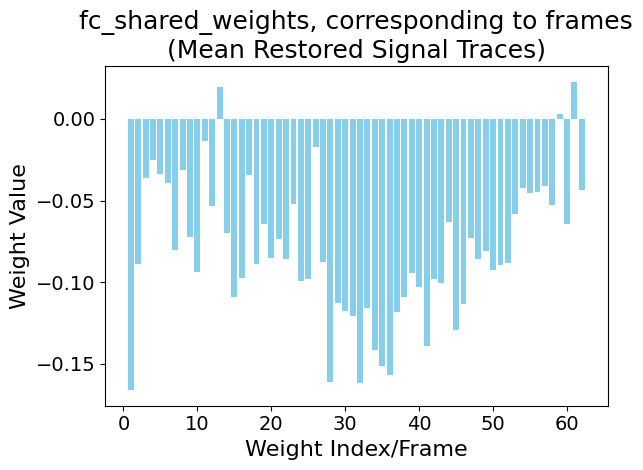

The mean the first 31 weight values of fc_shared_weights is -0.07380548119544983
The mean the last 31 weight values of fc_shared_weights is -0.08611967414617538


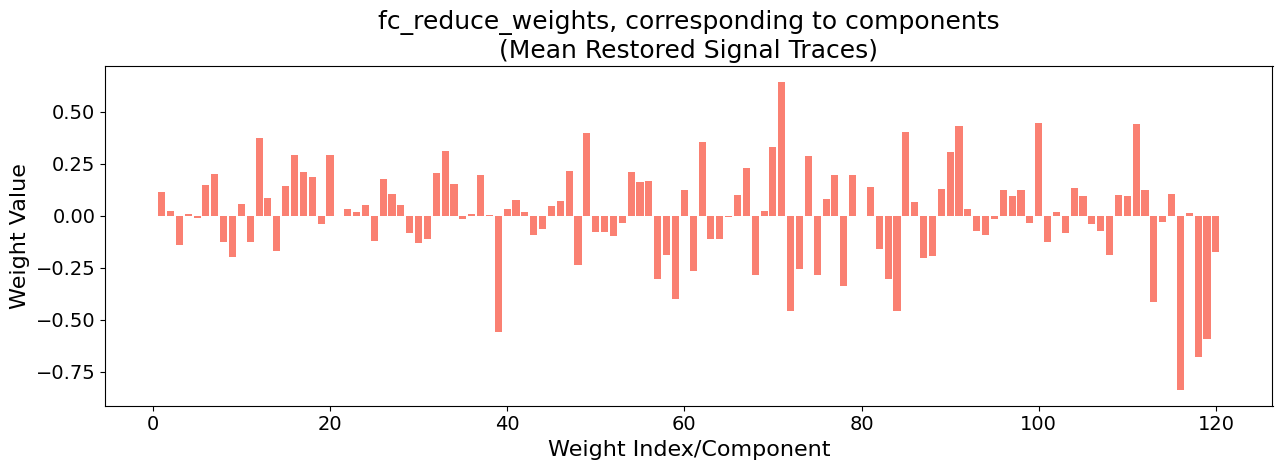

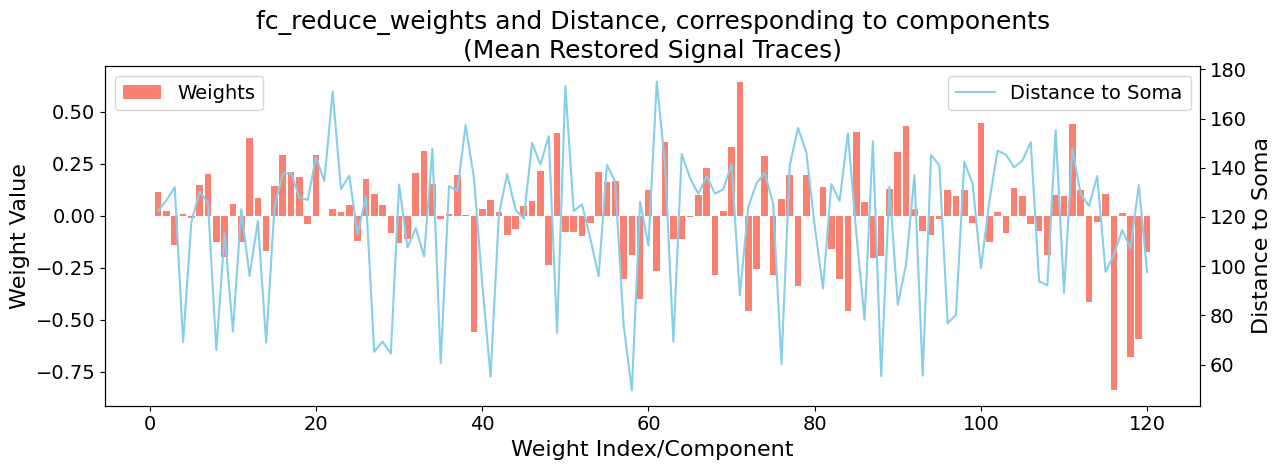

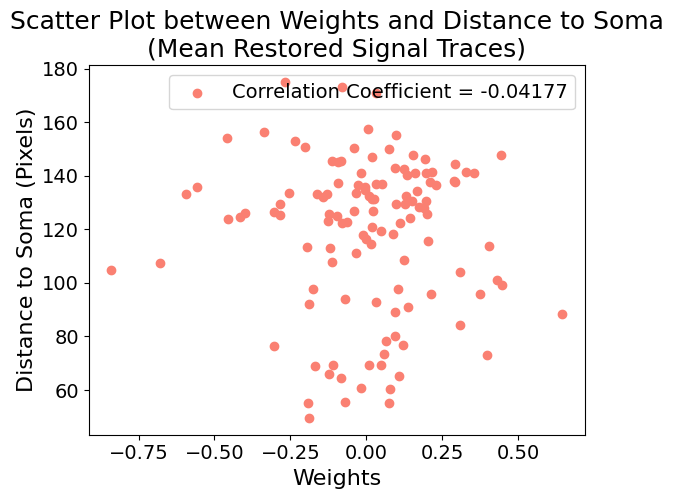

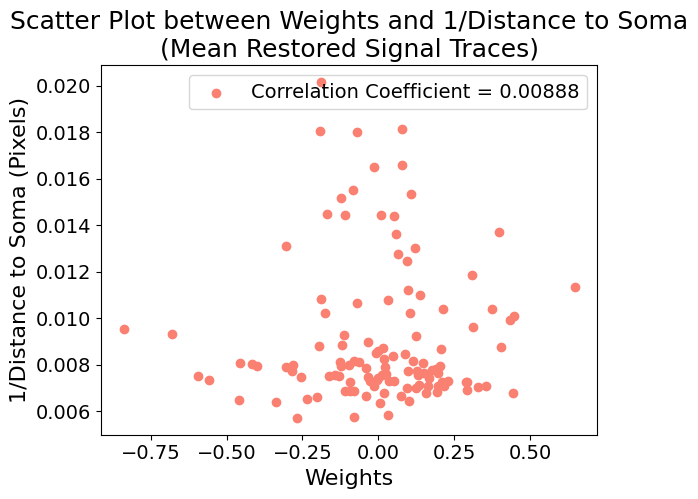

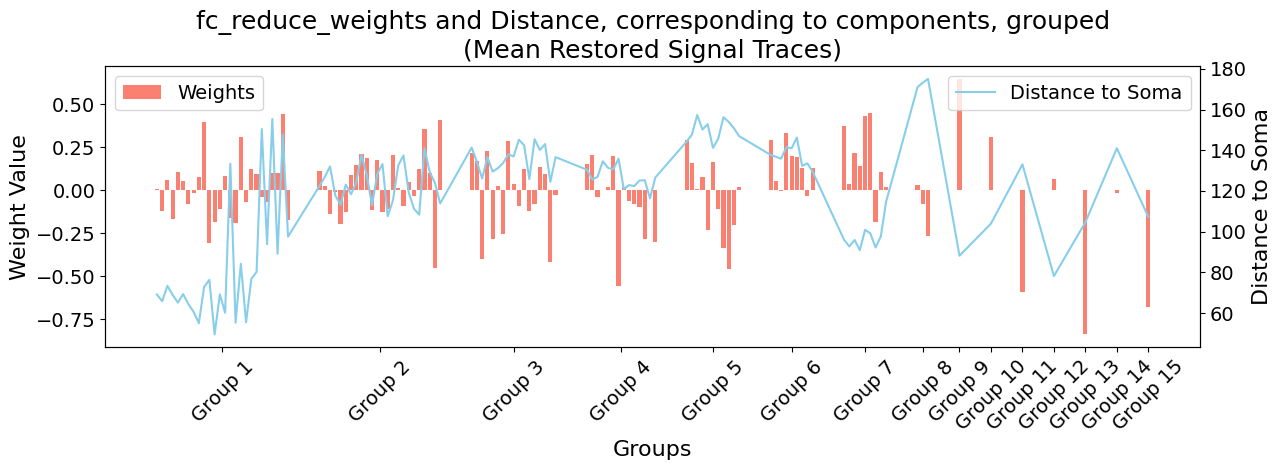

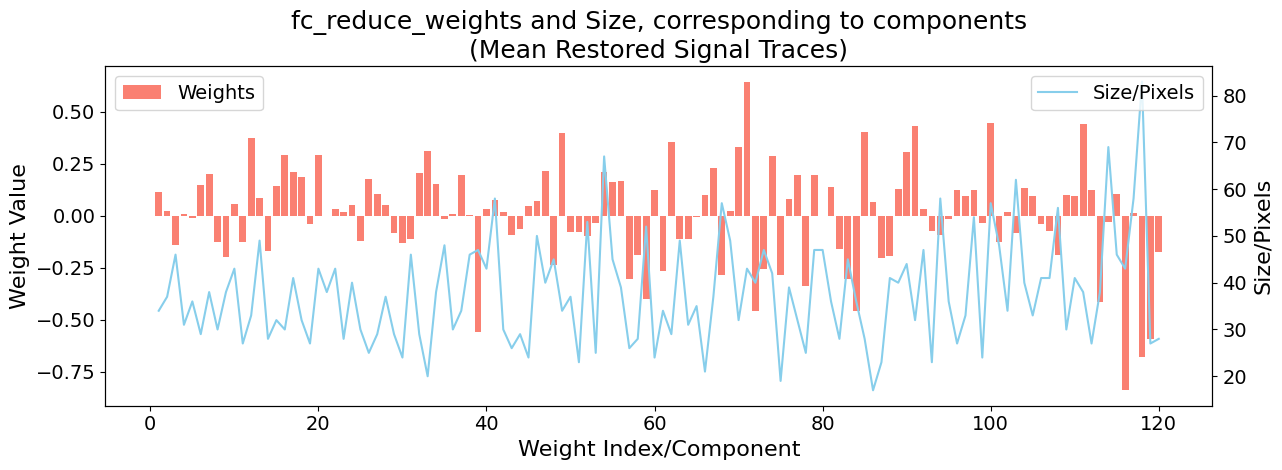

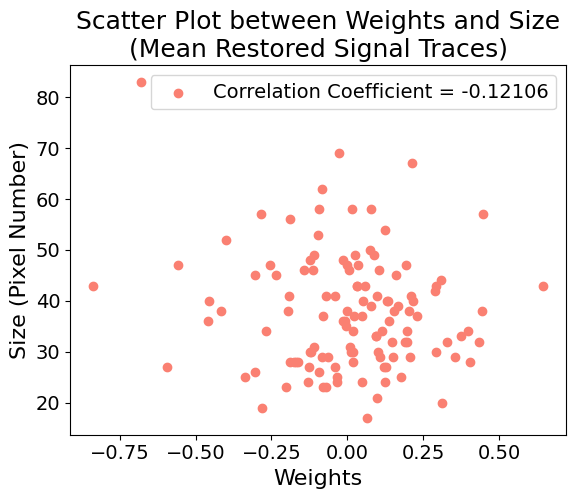

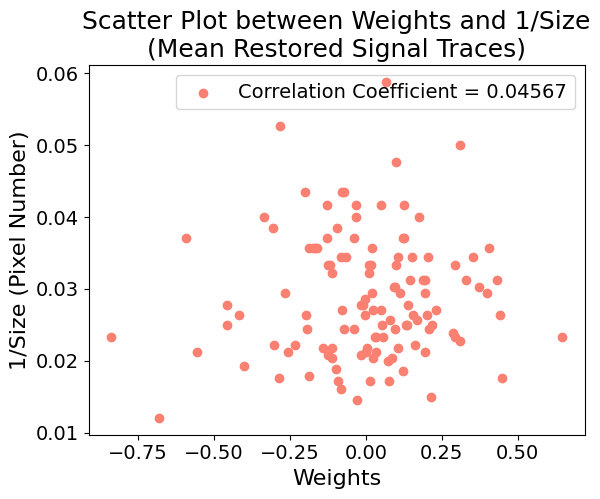

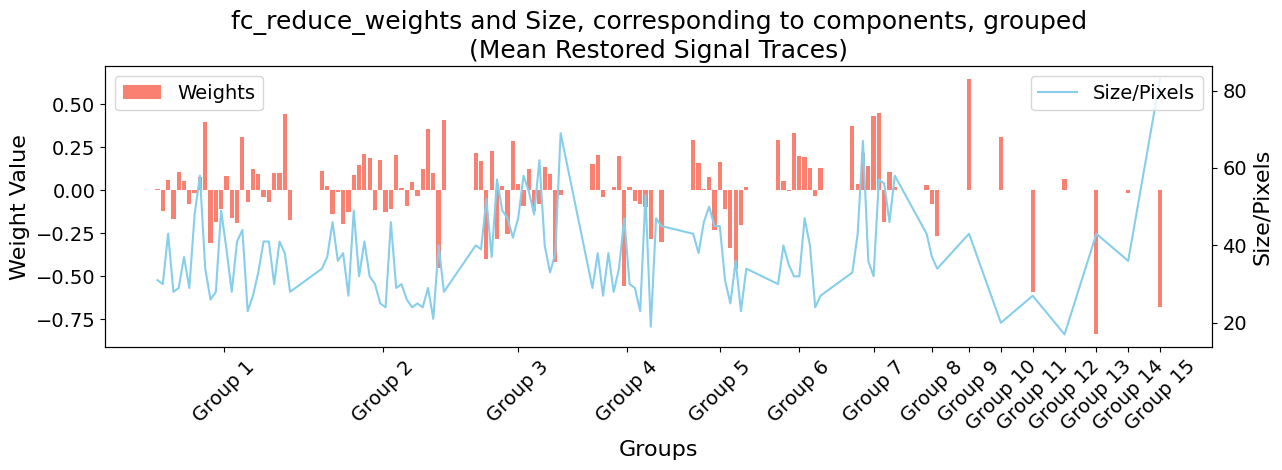

----- ----- -----
Mean and Std Restored Signal Traces

fc_shared weights:
Parameter containing:
tensor([[ 7.9239e-02,  7.2299e-02,  6.8413e-02,  7.8557e-02,  4.2781e-02,
          3.9813e-02,  4.4680e-02,  4.7113e-02,  1.3239e-04,  4.4230e-02,
          5.6159e-02,  9.8698e-02,  3.4265e-02,  5.9799e-02,  3.9487e-02,
          5.7112e-02,  6.8293e-02,  8.3845e-02,  4.4712e-02,  5.4811e-02,
          4.8702e-02,  7.2434e-02,  7.8465e-02,  7.5450e-02,  4.7750e-02,
          2.2796e-02,  1.1456e-01,  1.2514e-01,  4.8598e-02,  1.1791e-01,
          7.6882e-02,  1.2804e-01,  1.4114e-01,  7.4011e-02,  8.6242e-02,
          1.2889e-01,  1.0021e-01,  9.5642e-02,  1.3746e-01,  1.1343e-01,
          8.5867e-02,  9.3883e-02,  1.2320e-01,  6.2831e-02,  1.3131e-01,
          7.7071e-02,  8.7583e-02,  7.1529e-02,  1.9834e-02,  1.0703e-01,
          6.9010e-02,  1.0353e-01,  3.8770e-02,  5.8360e-02,  7.3240e-02,
         -1.8900e-02,  5.7890e-02,  5.2080e-04,  6.7304e-02,  1.2460e-02,
         -4.3821

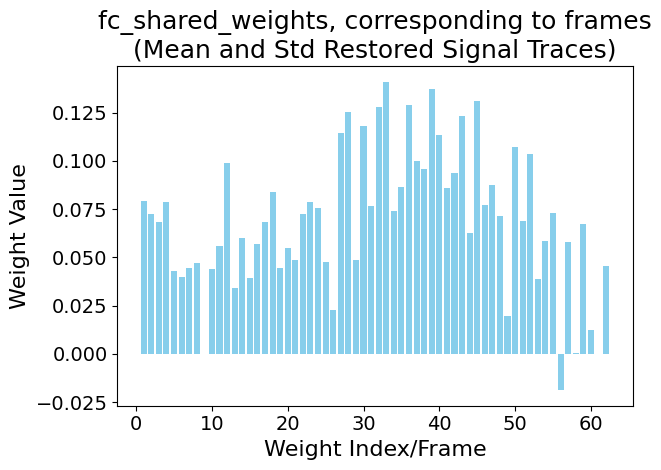

The mean the first 31 weight values of fc_shared_weights is 0.06268154084682465
The mean the last 31 weight values of fc_shared_weights is 0.07654988020658493


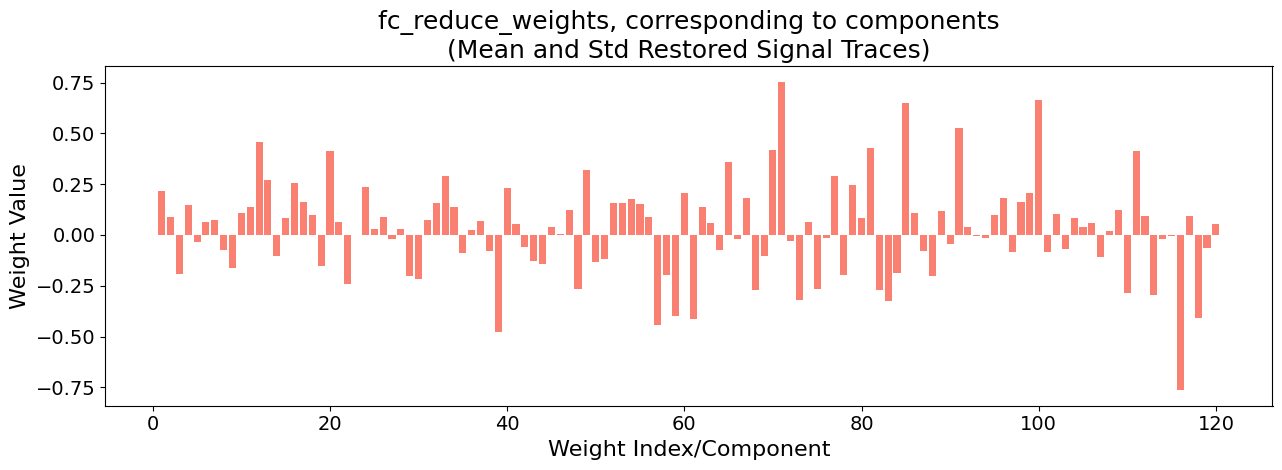

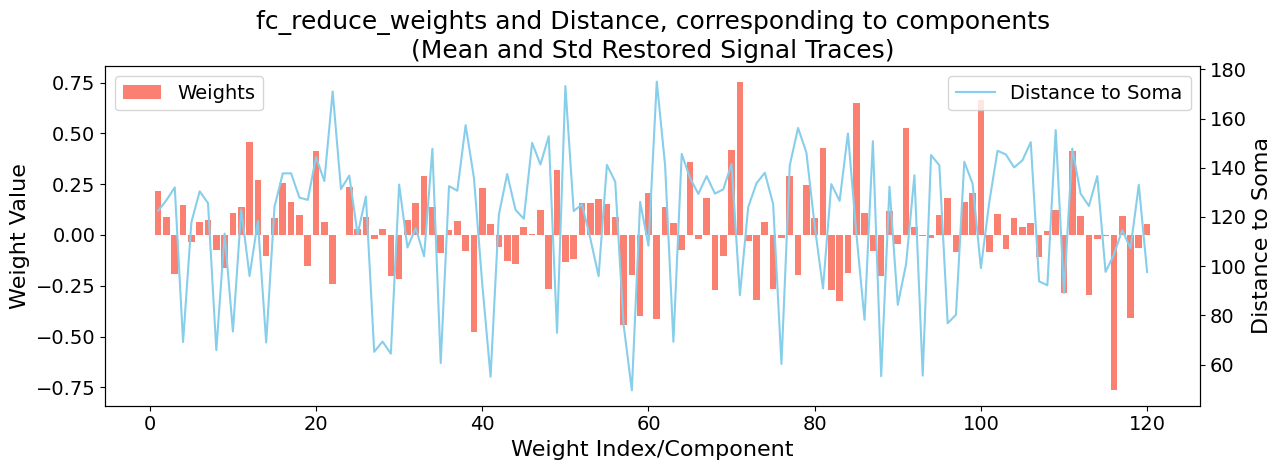

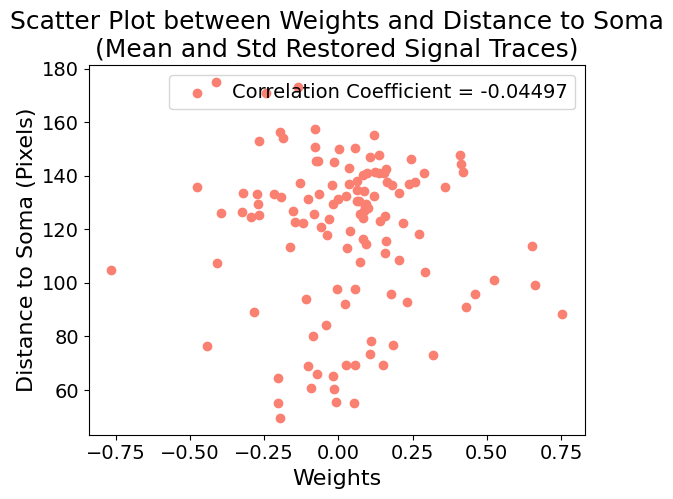

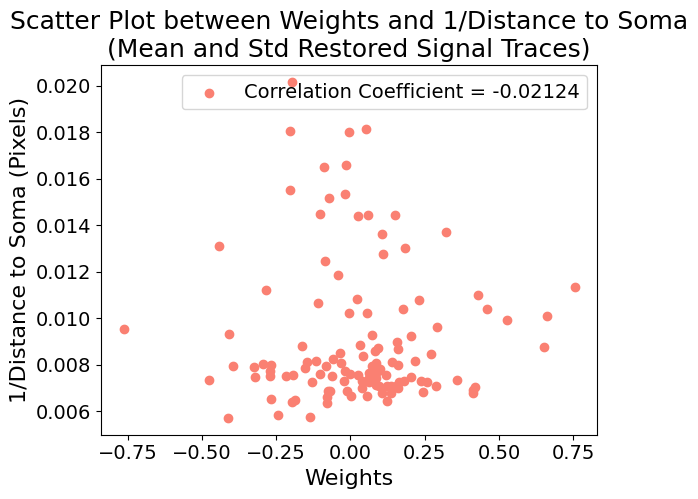

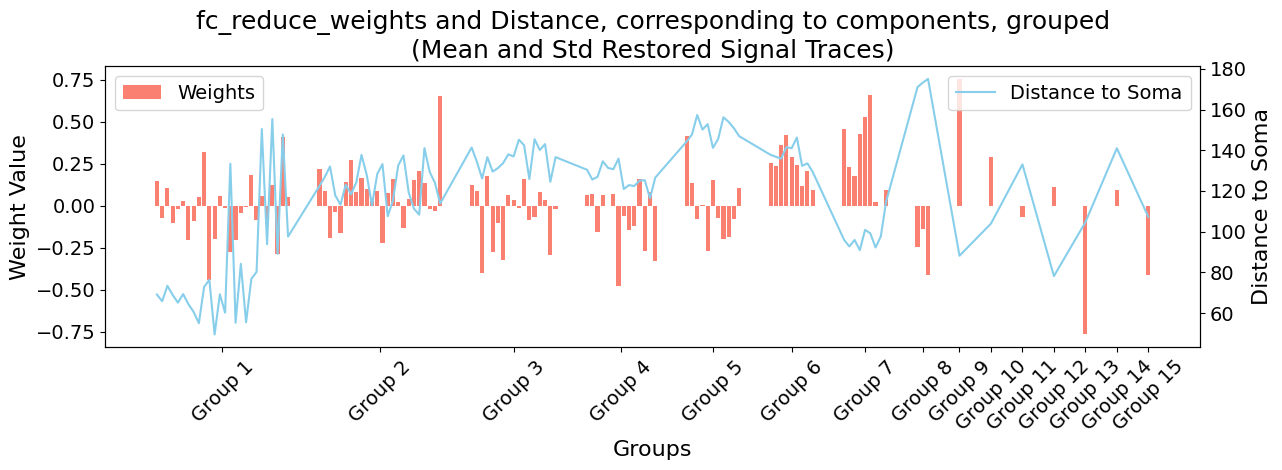

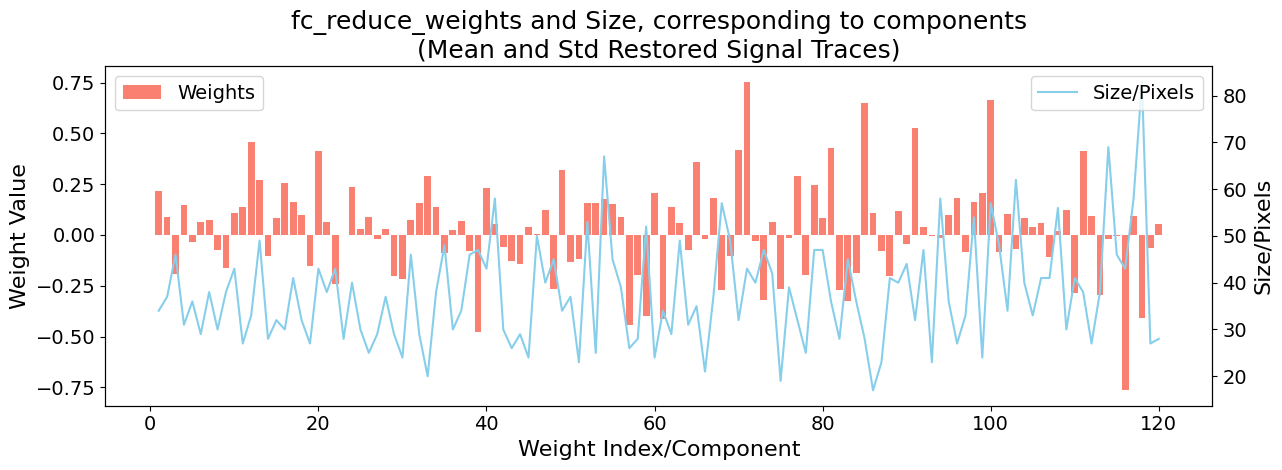

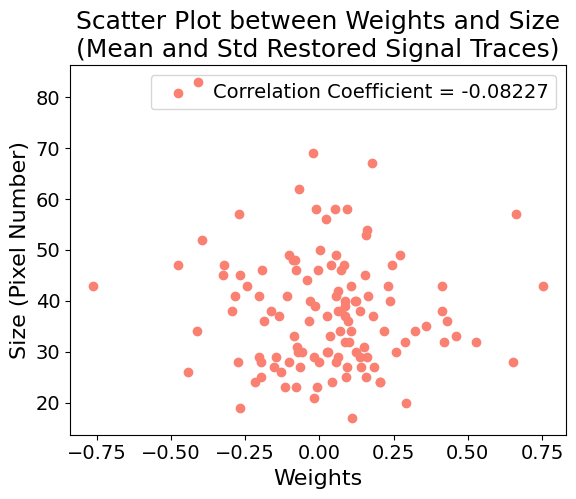

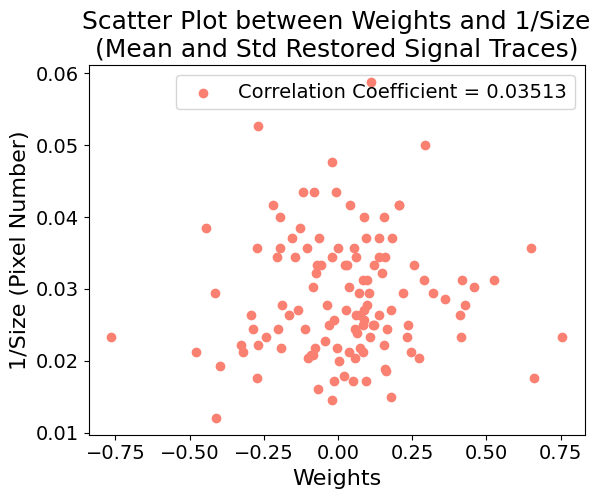

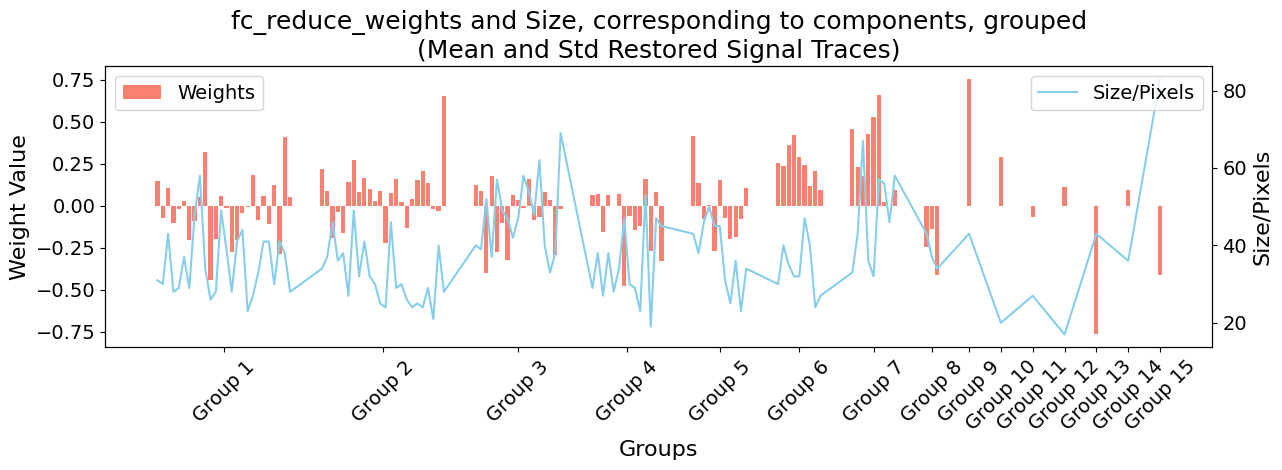

----- ----- -----


In [229]:
signal_trace_type_list = ["Raw Signal Traces", "Mean Restored Signal Traces", "Mean and Std Restored Signal Traces"]
# signal_trace_type_list = ["Mean Restored Signal Traces", "Mean and Std Restored Signal Traces"]
# signal_trace_type_list = ["Mean and Std Restored Signal Traces"]

root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"
path_ = os.path.join(root_path, cell_name, cell_name + 'green_Axon.mat')
mat_data = scipy.io.loadmat(path_)
axons = mat_data['Axons']
# Squeeze the outer array
axons = np.squeeze(axons, axis=0)
for i in range(len(axons)):
    # Squeeze the inner array and convert the data type to 'int'
    axons[i] = np.squeeze(axons[i].astype(int), axis=0)

valid_com_index_from_one_list = np.array(valid_com_index_list) + 1

# Convert axons to index form thereby consistent with the index of remained components
index_form_axons = copy.deepcopy(axons)
for i, axon in enumerate(axons):
    for j, bouton in enumerate(axon):
        index_form_axons[i][j] = np.where(valid_com_index_from_one_list == bouton)[0]
flat_index_form_axons = np.concatenate(index_form_axons)


for signal_trace_type in signal_trace_type_list:

    model = FluoModel(data_set.shape[1])

    if signal_trace_type == "Raw Signal Traces":
        model_path = f"./{cell_name}_model_with_raw.pth"
    elif signal_trace_type == "Mean Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored.pth"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored_std_restored.pth"

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    # access the weights for each layer
    fc_shared_weights = model.fc_shared.weight
    fc_reduce_weights = model.fc_reduce.weight
    fc_end_weights = model.fc_end.weight

    # access the biases if needed
    fc_shared_biases = model.fc_shared.bias
    fc_reduce_biases = model.fc_reduce.bias
    fc_end_biases = model.fc_end.bias

    print(f"{signal_trace_type}")

    # Weights
    print("\nfc_shared weights:")
    print(fc_shared_weights)

    print("\nfc_reduce weights:")
    print(fc_reduce_weights)

    print("\nfc_end weights:")
    print(fc_end_weights)

    # Biases
    print("\nfc_shared biases:")
    print(fc_shared_biases)

    print("\nfc_reduce biases:")
    print(fc_reduce_biases)

    print("\nfc_end biases:")
    print(fc_end_biases)

    # Access the weights
    fc_shared_weights = fc_shared_weights.detach().numpy().flatten()
    fc_reduce_weights = fc_reduce_weights.detach().numpy().flatten()



    ##### Create subplots (weights abs)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Plot fc_shared_weights
    ax1.bar(range(1,len(fc_shared_weights)+1), fc_shared_weights, color='skyblue')
    ax1.set_title(f'fc_shared_weights, corresponding to frames\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Weight Index/Frame', fontsize=16)
    ax1.set_ylabel('Weight Value', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()

    half_len = int(len(fc_shared_weights)/2)
    print(f"The mean the first {half_len} weight values of fc_shared_weights is {np.mean(fc_shared_weights[:half_len])}")
    print(f"The mean the last {half_len} weight values of fc_shared_weights is {np.mean(fc_shared_weights[half_len:])}")


    # Create subplots (1 y axis)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

    # Plot fc_reduce_weights
    ax1.bar(range(1,len(fc_reduce_weights)+1), fc_reduce_weights, color='salmon')
    ax1.set_title(f'fc_reduce_weights, corresponding to components\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Weight Index/Component', fontsize=16)
    ax1.set_ylabel('Weight Value', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()



    ##### Create subplots (2 y axes, weights abs and distance)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))
    x = np.arange(1, len(fc_reduce_weights) + 1)

    # Plot fc_reduce_weights
    ax1.bar(x, fc_reduce_weights, color='salmon', label = 'Weights')
    ax1.set_title(f'fc_reduce_weights and Distance, corresponding to components\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Weight Index/Component', fontsize=16)
    ax1.set_ylabel('Weight Value', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second curve
    ax2.plot(x, valid_dis_list, color='skyblue', label='Distance to Soma')
    ax2.set_ylabel('Distance to Soma', fontsize=16)
    ax2.tick_params(axis='y', labelsize=14)

    # Adding legend for the second curve
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()



    ##### Create subplots (correlation between weights abs and distance)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Calculate the correlation coefficient
    sorted_indices = np.argsort(fc_reduce_weights)
    sorted_valid_dis_list = np.array(valid_dis_list)[sorted_indices]
    sorted_fc_reduce_weights = fc_reduce_weights[sorted_indices]
    correlation_coefficient = np.corrcoef(sorted_fc_reduce_weights, np.transpose(sorted_valid_dis_list))[0, 1]

    # plot results
    ax1.scatter(sorted_fc_reduce_weights, sorted_valid_dis_list, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    ax1.set_xlabel('Weights', fontsize=16)
    ax1.set_ylabel('Distance to Soma (Pixels)', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(f"Scatter Plot between Weights and Distance to Soma\n({signal_trace_type})", fontsize=18)
    ax1.legend(fontsize=14, facecolor='none')
    plt.show()



    ##### Create subplots (correlation between weights abs and 1/distance)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Calculate the correlation coefficient
    sorted_indices = np.argsort(fc_reduce_weights)
    sorted_valid_dis_list = np.array(valid_dis_list)[sorted_indices]
    sorted_fc_reduce_weights = fc_reduce_weights[sorted_indices]
    correlation_coefficient = np.corrcoef(sorted_fc_reduce_weights, np.transpose(1/sorted_valid_dis_list))[0, 1]

    # plot results
    ax1.scatter(sorted_fc_reduce_weights, 1/sorted_valid_dis_list, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    ax1.set_xlabel('Weights', fontsize=16)
    ax1.set_ylabel('1/Distance to Soma (Pixels)', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(f"Scatter Plot between Weights and 1/Distance to Soma\n({signal_trace_type})", fontsize=18)
    ax1.legend(fontsize=14, facecolor='none')
    plt.show()



    ##### Create subplots (2 y axes, weights abs and distance, grouped)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

    # Reorder fc_reduce_weights and valid_dis_list based on group_indices
    reordered_fc_reduce_weights = [fc_reduce_weights[idx] for idx in flat_index_form_axons]
    reordered_valid_dis_list = [valid_dis_list[idx] for idx in flat_index_form_axons]

    # Create x-labels for groups
    x_labels = [f"Group {i+1}" for i in range(len(index_form_axons))]

    # Bar plot for fc_reduce_weights
    x = np.arange(1, len(flat_index_form_axons) + 1)
    index__ = 0
    for axon in index_form_axons:
        index__ = index__ + len(axon)
        if index__ < len(flat_index_form_axons):
            x[index__:] = x[index__:] + 5 # generate gap space on x axis between groups

    break_indices = np.where(np.diff(x) != 1)[0]
    x_labels_center = [(x[start] + x[end]) / 2 for start, end in zip(np.insert(break_indices + 1, 0, 0), break_indices)]
    x_labels_center.append((x[break_indices[-1]+1] + x[-1])/2)

    ax1.bar(x, reordered_fc_reduce_weights, color='salmon', label='Weights')
    ax1.set_title(f'fc_reduce_weights and Distance, corresponding to components, grouped\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Groups', fontsize=16)
    ax1.set_ylabel('Weight Value', fontsize=16)
    ax1.set_xticks(x_labels_center)
    ax1.set_xticklabels(x_labels, rotation=45, fontsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second curve (valid_dis_list)
    ax2.plot(x, reordered_valid_dis_list, color='skyblue', label='Distance to Soma')
    ax2.set_ylabel('Distance to Soma', fontsize=16)
    ax2.tick_params(axis='y', labelsize=14)

    # Adding legend for both curves
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()



    ##### Create subplots (2 y axes, weights abs and size)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))
    x = np.arange(1, len(fc_reduce_weights) + 1)

    # Plot fc_reduce_weights
    ax1.bar(x, fc_reduce_weights, color='salmon', label = 'Weights')
    ax1.set_title(f'fc_reduce_weights and Size, corresponding to components\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Weight Index/Component', fontsize=16)
    ax1.set_ylabel('Weight Value', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second curve
    ax2.plot(x, valid_size_list, color='skyblue', label='Size/Pixels')
    ax2.set_ylabel('Size/Pixels', fontsize=16)
    ax2.tick_params(axis='y', labelsize=14)

    # Adding legend for the second curve
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()



    ##### Create subplots (correlation between weights abs and size)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Calculate the correlation coefficient
    sorted_indices = np.argsort(fc_reduce_weights)
    sorted_valid_size_list = np.array(valid_size_list)[sorted_indices]
    sorted_fc_reduce_weights = fc_reduce_weights[sorted_indices]
    correlation_coefficient = np.corrcoef(sorted_fc_reduce_weights, np.transpose(sorted_valid_size_list))[0, 1]

    # plot results
    ax1.scatter(sorted_fc_reduce_weights, sorted_valid_size_list, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    ax1.set_xlabel('Weights', fontsize=16)
    ax1.set_ylabel('Size (Pixel Number)', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(f"Scatter Plot between Weights and Size\n({signal_trace_type})", fontsize=18)
    ax1.legend(fontsize=14, facecolor='none')
    plt.show()



    ##### Create subplots (correlation between weights abs and 1/size)
    fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

    # Calculate the correlation coefficient
    sorted_indices = np.argsort(fc_reduce_weights)
    sorted_valid_size_list = np.array(valid_size_list)[sorted_indices]
    sorted_fc_reduce_weights = fc_reduce_weights[sorted_indices]
    correlation_coefficient = np.corrcoef(sorted_fc_reduce_weights, np.transpose(1/sorted_valid_size_list))[0, 1]

    # plot results
    ax1.scatter(sorted_fc_reduce_weights, 1/sorted_valid_size_list, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    ax1.set_xlabel('Weights', fontsize=16)
    ax1.set_ylabel('1/Size (Pixel Number)', fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_title(f"Scatter Plot between Weights and 1/Size\n({signal_trace_type})", fontsize=18)
    ax1.legend(fontsize=14, facecolor='none')
    plt.show()



    ##### Create subplots (2 y axes, weight abs and size, grouped)
    fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

    # Reorder fc_reduce_weights and valid_dis_list based on group_indices
    reordered_fc_reduce_weights = [fc_reduce_weights[idx] for idx in flat_index_form_axons]
    reordered_valid_size_list = [valid_size_list[idx] for idx in flat_index_form_axons]

    # Create x-labels for groups
    x_labels = [f"Group {i+1}" for i in range(len(index_form_axons))]

    # Bar plot for fc_reduce_weights
    x = np.arange(1, len(flat_index_form_axons) + 1)
    index__ = 0
    for axon in index_form_axons:
        index__ = index__ + len(axon)
        if index__ < len(flat_index_form_axons):
            x[index__:] = x[index__:] + 5

    break_indices = np.where(np.diff(x) != 1)[0]
    x_labels_center = [(x[start] + x[end]) / 2 for start, end in zip(np.insert(break_indices + 1, 0, 0), break_indices)]
    x_labels_center.append((x[break_indices[-1]+1] + x[-1])/2)

    ax1.bar(x, reordered_fc_reduce_weights, color='salmon', label='Weights')
    ax1.set_title(f'fc_reduce_weights and Size, corresponding to components, grouped\n({signal_trace_type})', fontsize=18)
    ax1.set_xlabel('Groups', fontsize=16)
    ax1.set_ylabel('Weight Value', fontsize=16)
    ax1.set_xticks(x_labels_center)
    ax1.set_xticklabels(x_labels, rotation=45, fontsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second curve (valid_dis_list)
    ax2.plot(x, reordered_valid_size_list, color='skyblue', label='Size/Pixels')
    ax2.set_ylabel('Size/Pixels', fontsize=16)
    ax2.tick_params(axis='y', labelsize=14)

    # Adding legend for both curves
    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.show()

    print("----- ----- -----")


#### Plot weights with component locations

Raw Signal Traces

fc_reduce weights:
Parameter containing:
tensor([[-0.1093,  0.0523,  0.1034, -0.0183,  0.1213, -0.1321, -0.0753,  0.0274,
          0.0128,  0.0272,  0.0258, -0.3051,  0.0108,  0.1173, -0.1714, -0.2379,
         -0.1081,  0.0079, -0.0513, -0.1469, -0.0931,  0.1115, -0.0595, -0.0331,
         -0.0465,  0.0546,  0.1129, -0.1152, -0.1590, -0.1367, -0.0432,  0.0665,
          0.0427, -0.1906, -0.1429,  0.0528, -0.0373, -0.1679,  0.4033,  0.0913,
          0.1452,  0.0379, -0.0743,  0.1931, -0.0687, -0.0670,  0.0664,  0.1466,
         -0.3099, -0.1259,  0.0077, -0.1113,  0.0614, -0.5530, -0.1301, -0.1862,
          0.2030,  0.2381,  0.1093, -0.1219,  0.0119, -0.1759,  0.1579, -0.0216,
          0.1335, -0.0583, -0.0956,  0.0147, -0.0095, -0.0513, -0.6011, -0.0506,
          0.0905, -0.2968,  0.2276, -0.0276, -0.1924,  0.1887, -0.1857,  0.2729,
         -0.2571,  0.2263, -0.0758,  0.2542, -0.0660, -0.1508,  0.1424,  0.0399,
          0.2280, -0.1107, -0.0281,  0.0320,  0.0

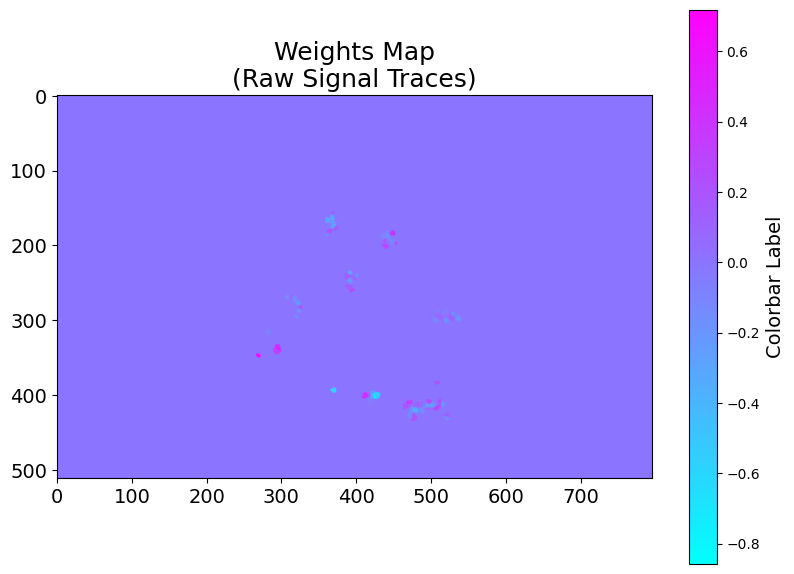

Mean Restored Signal Traces

fc_reduce weights:
Parameter containing:
tensor([[ 1.1271e-01,  2.2630e-02, -1.4179e-01,  8.8595e-03, -9.1806e-03,
          1.5094e-01,  2.0172e-01, -1.2389e-01, -1.9659e-01,  5.8235e-02,
         -1.2636e-01,  3.7439e-01,  8.6893e-02, -1.6878e-01,  1.4562e-01,
          2.9291e-01,  2.0939e-01,  1.8924e-01, -4.0085e-02,  2.9359e-01,
         -2.3938e-03,  3.1636e-02,  1.9743e-02,  5.2941e-02, -1.1872e-01,
          1.7552e-01,  1.0721e-01,  4.9973e-02, -8.2169e-02, -1.2827e-01,
         -1.1195e-01,  2.0516e-01,  3.1043e-01,  1.5538e-01, -1.5853e-02,
          1.0721e-02,  1.9583e-01,  4.5310e-03, -5.5776e-01,  3.3066e-02,
          7.6607e-02,  1.7594e-02, -9.3392e-02, -6.4931e-02,  4.9192e-02,
          7.3653e-02,  2.1771e-01, -2.3487e-01,  3.9852e-01, -7.9461e-02,
         -7.9865e-02, -9.7218e-02, -3.3956e-02,  2.1317e-01,  1.6204e-01,
          1.6826e-01, -3.0540e-01, -1.8834e-01, -4.0006e-01,  1.2510e-01,
         -2.6735e-01,  3.5360e-01, -1.1098

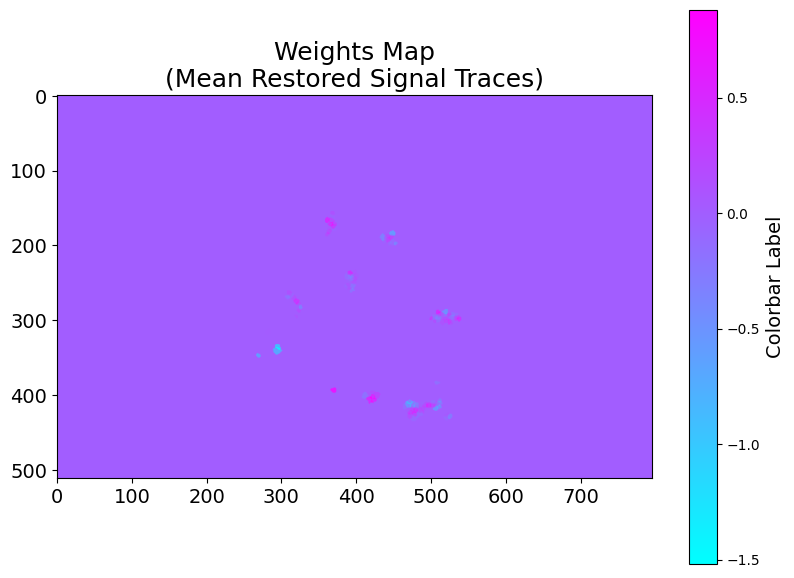

Mean and Std Restored Signal Traces

fc_reduce weights:
Parameter containing:
tensor([[ 0.2184,  0.0874, -0.1921,  0.1494, -0.0366,  0.0618,  0.0730, -0.0719,
         -0.1637,  0.1067,  0.1392,  0.4587,  0.2716, -0.1031,  0.0846,  0.2571,
          0.1642,  0.0985, -0.1542,  0.4144,  0.0618, -0.2436, -0.0009,  0.2370,
          0.0304,  0.0893, -0.0186,  0.0269, -0.2041, -0.2182,  0.0735,  0.1592,
          0.2918,  0.1376, -0.0908,  0.0251,  0.0704, -0.0775, -0.4769,  0.2319,
          0.0515, -0.0588, -0.1294, -0.1454,  0.0408,  0.0023,  0.1225, -0.2683,
          0.3205, -0.1354, -0.1176,  0.1584,  0.1566,  0.1785,  0.1537,  0.0862,
         -0.4436, -0.1954, -0.3968,  0.2048, -0.4127,  0.1372,  0.0574, -0.0749,
          0.3598, -0.0196,  0.1797, -0.2716, -0.1013,  0.4191,  0.7548, -0.0316,
         -0.3216,  0.0633, -0.2680, -0.0143,  0.2883, -0.1965,  0.2457,  0.0834,
          0.4295, -0.2728, -0.3253, -0.1877,  0.6518,  0.1100, -0.0797, -0.2024,
          0.1192, -0.0426,  0.5

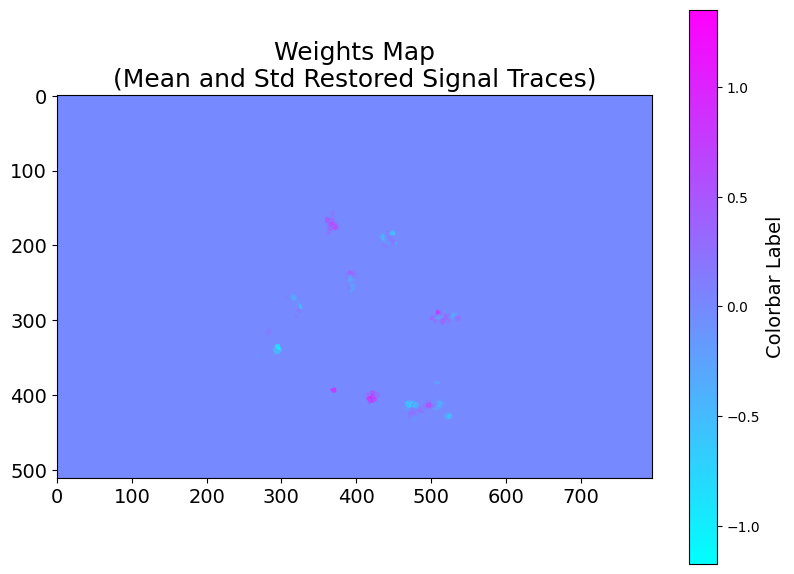

In [230]:
signal_trace_type_list = ["Raw Signal Traces", "Mean Restored Signal Traces", "Mean and Std Restored Signal Traces"]

root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"
path_ = os.path.join(root_path, cell_name, cell_name + 'green_BoutonMasks.mat')
data_ = h5py.File(path_, 'r') # Open the MATLAB v7.3 file
green_bouton_masks = copy.deepcopy(np.array(data_['BoutonMasks']))
green_bouton_masks = np.transpose(green_bouton_masks, (2, 1, 0))
data_.close()

for signal_trace_type in signal_trace_type_list:

    model = FluoModel(data_set.shape[1])

    if signal_trace_type == "Raw Signal Traces":
        model_path = f"./{cell_name}_model_with_raw.pth"
    elif signal_trace_type == "Mean Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored.pth"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored_std_restored.pth"

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    fc_reduce_weights = model.fc_reduce.weight

    print(f"{signal_trace_type}")

    print("\nfc_reduce weights:")
    print(fc_reduce_weights)

    fc_reduce_weights = fc_reduce_weights.detach().numpy().flatten()

    weights_map = copy.deepcopy(green_bouton_masks)

    for k, index_ in enumerate(valid_com_index_list):
        for i in range(weights_map.shape[0]):
            for j in range(weights_map.shape[1]):
                if weights_map[i, j, index_] == 1:
                    weights_map[i, j, index_] = fc_reduce_weights[k]

    weights_map = np.sum(weights_map[:,:,valid_com_index_list], axis=2)
    fig, ax = plt.subplots(figsize=(6.4*1.5, 4.8*1.5))
    cax = ax.imshow(weights_map, cmap='cool')
    colorbar = fig.colorbar(cax)
    colorbar.set_label('Colorbar Label', fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(f"Weights Map\n({signal_trace_type})", fontsize=18)
    plt.show()



In [ ]:
sys.exit()

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### Generate the data and label, and train and eval (hierarchy)

In [ ]:
median_value = np.median(valid_dis_list)
larger_half_indexes = []
for i, value in enumerate(valid_dis_list):
    if value >= median_value:
        larger_half_indexes.append(i)
print(np.array(larger_half_indexes).shape)
all_indexes = list(range(len(valid_dis_list)))
smaller_half_indexes = list(set(all_indexes) - set(larger_half_indexes))
# print(larger_half_indexes)
# print(smaller_half_indexes)

In [ ]:
signal_trace_type_list = ["Raw Signal Traces",
                          "Mean Restored Signal Traces",
                          "Mean and Std Restored Signal Traces"]

# signal_trace_type_list = ["Mean Restored Signal Traces",
#                           "Mean and Std Restored Signal Traces"]

# signal_trace_type_list = ["Raw Signal Traces"]
# signal_trace_type_list = ["Mean Restored Signal Traces"]
# signal_trace_type_list = ["Mean and Std Restored Signal Traces"]

list_of_train_loss_lists = []
list_of_test_loss_lists = []

for signal_trace_type in signal_trace_type_list:

    if signal_trace_type == "Raw Signal Traces":
        data_set = green_signal_traces.copy()
        label_set = red_signal_traces.copy()
    elif signal_trace_type == "Mean Restored Signal Traces":
        data_set = green_signal_traces_mean_restored.copy()
        label_set = red_signal_traces_mean_restored.copy()
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        data_set = green_signal_traces_mean_restored_std_restored.copy()
        label_set = red_signal_traces_mean_restored_std_restored.copy()

    data_set = data_set[:,valid_com_index_list,:]

    print(f"data_set.shape: {data_set.shape}")
    print(f"label_set.shape: {label_set.shape}")

    # Normalize data_set to [-1,1]
    data_set_min = np.min(data_set)
    data_set_max = np.max(data_set)
    data_set = ((data_set - data_set_min) / (data_set_max - data_set_min) - 0.5) * 2

    # Normalize label_set to [-1,1]
    label_set_min = np.min(label_set)
    label_set_max = np.max(label_set)
    label_set = ((label_set - label_set_min) / (label_set_max - label_set_min) - 0.5) * 2

    # Define dataset class
    class FluoDataset(Dataset):
        def __init__(self, data_set, label_set, z_indices, x_indices):
            self.data_set = data_set
            self.label_set = label_set
            self.z_indices = z_indices
            self.x_indices = x_indices

        def __len__(self):
            return len(self.z_indices)

        def __getitem__(self, idx):
            z = self.z_indices[idx]
            x = self.x_indices[idx]

            input_data = self.data_set[z, :, x-62:x]
            target_label = np.mean(self.label_set[z, :, x-31:x])

            return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_label, dtype=torch.float32)
            # or torch.from_numpy(input_data).float(), torch.from_numpy(target_label).float()

    # Set a random seed for reproducibility
    # np.random.seed(16)  # can use any integer as the seed value

    # Split the data into train and test sets
    length = 6400*2
    choices = range(3)
    # choices = range(2) # delete last run
    train_z_indices = np.random.choice(choices, size=length)
    # choices = range(62, 30000)
    choices = list(range(62, 10000)) + list(range(12000, 17000)) + list(range(18244, 32500)) # 90% for train
    # 10000-62+17000-12000+32500-18244=29194, 29194/(32500-62)=90%, 32500-62 is the all data pieces
    train_x_indices = np.random.choice(choices, size=length)

    length = 640
    choices = range(3)
    # choices = range(2) # delete last run
    test_z_indices = np.random.choice(choices, size=length)
    # choices = range(62, 30000)
    # choices = range(30000, 32500)
    choices = list(range(10000, 12000)) + list(range(17000, 18244)) # 10% for test
    # 12000-10000+18244-17000=3244, 3244/(32500-62)=10%, 32500-62 is the all data pieces
    test_x_indices = np.random.choice(choices, size=length)

    length = 640 # this is a subset of train data for test on train
    choices = range(3)
    # choices = range(2) # delete last run
    small_train_z_indices = np.random.choice(choices, size=length)
    choices = list(range(9000, 10000)) + list(range(12000, 17000)) + list(range(18244, 19000))
    small_train_x_indices = np.random.choice(choices, size=length)

    train_dataset = FluoDataset(data_set, label_set, train_z_indices, train_x_indices)
    test_dataset = FluoDataset(data_set, label_set, test_z_indices, test_x_indices)
    test_on_train_dataset = FluoDataset(data_set, label_set, small_train_z_indices, small_train_x_indices)

    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_on_train_loader = DataLoader(test_on_train_dataset, batch_size=batch_size, shuffle=False)
    # print(len(train_loader))
    # print(len(test_loader))


    # Define the model
    class FluoModel(nn.Module):
        def __init__(self, component_num, fisrt_branch_indexes):
            super(FluoModel, self).__init__()
            self.fc_shared = nn.Linear(62, 1)  # Shared fully connected layer
            self.fc_reduce_2nd_branch = nn.Linear(component_num - len(fisrt_branch_indexes), 1)
            self.fc_reduce_1st_branch = nn.Linear(len(fisrt_branch_indexes) + 1, 1)
            self.sigmoid = nn.Sigmoid()
            self.fc_end = nn.Linear(1, 1)

            all_indexes = list(range(component_num))
            self.second_branch_indexes = list(set(all_indexes) - set(fisrt_branch_indexes))
            self.first_branch_indexes = fisrt_branch_indexes

        def forward(self, x):
            x = x.view(x.size(0), -1, 62)  # Reshape to (batch_size, component_num, 62)

            # Apply the shared fully connected layer along the last dimension (62)
            shared_output = self.fc_shared(x).squeeze(2)
            # self.fc_shared(x) shape is (batch_size, component_num, 1), then squeeze the last dimension
            # In PyTorch, when you apply a fully connected layer (or any other linear
            # transformation) to a 3D tensor, by default, the operation is performed
            # along the last dimension of the tensor.

            # Reduce component_num (e.g., 281) channels to 1 using a separate fully connected layer
            reduced_output_1 = self.fc_reduce_2nd_branch(shared_output[:,self.second_branch_indexes])
            reduced_output_1_ = torch.cat((shared_output[:,self.first_branch_indexes], reduced_output_1), dim=1)
            reduced_output_2 = self.fc_reduce_1st_branch(reduced_output_1_)
            pre_output = self.sigmoid(reduced_output_2)
            output = self.fc_end(pre_output)

            return output

    train_loss_list = []
    test_loss_list = []
    for i_ in range(30): # try 8 times to get the best one
        model = FluoModel(data_set.shape[1], larger_half_indexes)

        # Define loss function and optimizer
        criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
        optimizer = optim.Adam(model.parameters(), lr=0.003)

        # optimizer = optim.Adam(model.parameters(), lr=0.005)
        # scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

        # Training loop
        num_epochs = 90
        print_interval = 10

        train_loss_list_ = []
        test_loss_list_ = []
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()
            # scheduler.step()

            # if epoch < 5 or (epoch + 1) % print_interval == 0:
            #     print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item():.6f}")

            # Testing on train and test sets
            model.eval()

            train_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_on_train_loader:
                    outputs = model(inputs)
                    train_loss += criterion(outputs.squeeze(), targets).item()

            average_train_loss = train_loss / len(test_on_train_dataset)
            train_loss_list_.append(average_train_loss)

            test_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    test_loss += criterion(outputs.squeeze(), targets).item()

            average_test_loss = test_loss / len(test_loader)
            if epoch == 5 and average_test_loss >= 0.9 * np.mean(np.array(test_loss_list_)[1:]):
                break; # kill trials with a low probability of convergence (terminate trials that are unlikely to converge)
            test_loss_list_.append(average_test_loss)

            if epoch < 5 or (epoch + 1) % print_interval == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_train_loss:.6f} | Test Loss: {average_test_loss:.6f}")

        if i_ == 0:
            train_loss_list, test_loss_list = train_loss_list_, test_loss_list_
            model_final = model
        elif test_loss_list_[-1] < test_loss_list[-1]:
            train_loss_list, test_loss_list = train_loss_list_, test_loss_list_
            model_final = model

    # plot results
    plt.figure(figsize=(6.4, 4.8))
    plt.plot(train_loss_list, color = 'skyblue', label='Train Loss', linewidth=2)
    plt.plot(test_loss_list, color = 'salmon', label='Test Loss', linewidth=2)
    plt.xlabel('Epoch Index', fontsize=16)
    plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.title(f"Train and Test Loss Curves\n({signal_trace_type})", fontsize=18)
    plt.legend(fontsize=14, facecolor='none')
    plt.show()

    list_of_train_loss_lists.append(train_loss_list)
    list_of_test_loss_lists.append(test_loss_list)

    if signal_trace_type == "Raw Signal Traces":
        model_path = f"./{cell_name}_model_with_raw_2level.pth"
    elif signal_trace_type == "Mean Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored_2level.pth"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        model_path = f"./{cell_name}_model_with_mean_restored_std_restored_2level.pth"

    with open(model_path, "wb") as f:
        torch.save(model_final.state_dict(), f)

    model = FluoModel(data_set.shape[1], larger_half_indexes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model in evaluation mode

    outputs_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            outputs_list.append(outputs.numpy())
            labels_list.append(targets.numpy())

    outputs_array = np.concatenate(outputs_list)
    labels_array = np.concatenate(labels_list)

    # Sort labels and corresponding outputs
    sorted_indices = np.argsort(labels_array)
    sorted_labels = labels_array[sorted_indices]
    sorted_outputs = outputs_array[sorted_indices]

    # plot results
    plt.figure(figsize=(6.4, 4.8))
    plt.plot(sorted_labels, color = 'skyblue', label='True Labels', linewidth=2)
    plt.plot(sorted_outputs, color = 'salmon', label='Model Outputs', linewidth=2)
    plt.xlabel('Sample Index', fontsize=16)
    plt.ylabel('Normalized Value', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.title(f"Comparison between True Labels and Model Outputs\n({signal_trace_type})", fontsize=18)
    plt.legend(fontsize=14, facecolor='none')
    plt.show()


    # Calculate the correlation coefficient
    correlation_coefficient = np.corrcoef(sorted_labels, np.transpose(sorted_outputs))[0, 1]

    # plot results
    plt.figure(figsize=(6.4, 4.8))
    plt.scatter(sorted_labels, sorted_outputs, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
    plt.xlabel('Normalized Value (Labels)', fontsize=16)
    plt.ylabel('Normalized Value (Outputs)', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.title(f"Scatter Plot between True Labels and Model Outputs\n({signal_trace_type})", fontsize=18)
    plt.legend(fontsize=14, facecolor='none')
    plt.show()

In [ ]:
# compare train losses and compare test loss between different types of signal traces

colors_list = [('deepskyblue', 'orangered'), ('royalblue', 'salmon'), ('cornflowerblue', 'violet')]
linestyle_list = ['dashed', 'dotted', 'solid']

plt.figure(figsize=(6.4, 4.8))
for (signal_trace_type, train_loss_list, test_loss_list, colors, linestyle) in zip(
    signal_trace_type_list, list_of_train_loss_lists, list_of_test_loss_lists,
    colors_list, linestyle_list
):
    if signal_trace_type == "Raw Signal Traces":
        type_ = "(Raw)"
    elif signal_trace_type == "Mean Restored Signal Traces":
        type_ = "(Mean Restored)"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        type_ = "(Mean and Std Restored)"
    plt.plot(train_loss_list, color = colors[0], linestyle = linestyle, label=f'Train Loss {type_}', linewidth=2)
    # plt.plot(train_loss_list[-10:], color = colors[0], linestyle = linestyle, label=f'Train Loss {type_}', linewidth=2)
plt.xlabel('Epoch Index', fontsize=16)
plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
plt.tick_params(labelsize=14)
plt.title(f"Train Loss Comparison Between Different Datasets", fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()

plt.figure(figsize=(6.4, 4.8))
for (signal_trace_type, train_loss_list, test_loss_list, colors, linestyle) in zip(
    signal_trace_type_list, list_of_train_loss_lists, list_of_test_loss_lists,
    colors_list, linestyle_list
):
    if signal_trace_type == "Raw Signal Traces":
        type_ = "(Raw)"
    elif signal_trace_type == "Mean Restored Signal Traces":
        type_ = "(Mean Restored)"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        type_ = "(Mean and Std Restored)"
    plt.plot(test_loss_list, color = colors[1], linestyle = linestyle, label=f'Test Loss {type_}', linewidth=2)
    # plt.plot(test_loss_list[-10:], color = colors[1], linestyle = linestyle, label=f'Test Loss {type_}', linewidth=2)
plt.xlabel('Epoch Index', fontsize=16)
plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
plt.tick_params(labelsize=14)
plt.title(f"Test Loss Comparison Between Different Datasets", fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()


# plot last epochs

plt.figure(figsize=(6.4, 4.8))
for (signal_trace_type, train_loss_list, test_loss_list, colors, linestyle) in zip(
    signal_trace_type_list, list_of_train_loss_lists, list_of_test_loss_lists,
    colors_list, linestyle_list
):
    if signal_trace_type == "Raw Signal Traces":
        type_ = "(Raw)"
    elif signal_trace_type == "Mean Restored Signal Traces":
        type_ = "(Mean Restored)"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        type_ = "(Mean and Std Restored)"
    plt.plot(np.arange(len(train_loss_list)+1-50, len(train_loss_list)+1), train_loss_list[-50:], color = colors[0], linestyle = linestyle, label=f'Train Loss {type_}', linewidth=2)
    # plt.plot(train_loss_list[-10:], color = colors[0], linestyle = linestyle, label=f'Train Loss {type_}', linewidth=2)
plt.xlabel('Epoch Index', fontsize=16)
plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
plt.tick_params(labelsize=14)
plt.title(f"Train Loss Comparison Between Different Datasets", fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()

plt.figure(figsize=(6.4, 4.8))
for (signal_trace_type, train_loss_list, test_loss_list, colors, linestyle) in zip(
    signal_trace_type_list, list_of_train_loss_lists, list_of_test_loss_lists,
    colors_list, linestyle_list
):
    if signal_trace_type == "Raw Signal Traces":
        type_ = "(Raw)"
    elif signal_trace_type == "Mean Restored Signal Traces":
        type_ = "(Mean Restored)"
    elif signal_trace_type == "Mean and Std Restored Signal Traces":
        type_ = "(Mean and Std Restored)"
    plt.plot(np.arange(len(test_loss_list)+1-50, len(test_loss_list)+1), test_loss_list[-50:], color = colors[1], linestyle = linestyle, label=f'Test Loss {type_}', linewidth=2)
    # plt.plot(test_loss_list[-10:], color = colors[1], linestyle = linestyle, label=f'Test Loss {type_}', linewidth=2)
plt.xlabel('Epoch Index', fontsize=16)
plt.ylabel('MSE Loss of Normalized Data', fontsize=16)
plt.tick_params(labelsize=14)
plt.title(f"Test Loss Comparison Between Different Datasets", fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()

In [ ]:
# signal_trace_type_list = ["Raw Signal Traces",
#                           "Mean Restored Signal Traces",
#                           "Mean and Std Restored Signal Traces"]

# # signal_trace_type_list = ["Mean Restored Signal Traces",
# #                           "Mean and Std Restored Signal Traces"]

# # signal_trace_type_list = ["Raw Signal Traces"]
# # signal_trace_type_list = ["Mean Restored Signal Traces"]
# # signal_trace_type_list = ["Mean and Std Restored Signal Traces"]

# for signal_trace_type in signal_trace_type_list:
#     if signal_trace_type == "Raw Signal Traces":
#         model_path = f"./{cell_name}_model_with_raw_2level.pth"
#     elif signal_trace_type == "Mean Restored Signal Traces":
#         model_path = f"./{cell_name}_model_with_mean_restored_2level.pth"
#     elif signal_trace_type == "Mean and Std Restored Signal Traces":
#         model_path = f"./{cell_name}_model_with_mean_restored_std_restored_2level.pth"

#     model = FluoModel(data_set.shape[1], larger_half_indexes)
#     model.load_state_dict(torch.load(model_path))
#     model.eval()  # Set the model in evaluation mode

#     outputs_list = []
#     labels_list = []

#     with torch.no_grad():
#         for inputs, targets in test_loader:
#             outputs = model(inputs)
#             outputs_list.append(outputs.numpy())
#             labels_list.append(targets.numpy())

#     outputs_array = np.concatenate(outputs_list)
#     labels_array = np.concatenate(labels_list)

#     # Sort labels and corresponding outputs
#     sorted_indices = np.argsort(labels_array)
#     sorted_labels = labels_array[sorted_indices]
#     sorted_outputs = outputs_array[sorted_indices]

#     # Calculate the correlation coefficient
#     correlation_coefficient = np.corrcoef(sorted_labels, np.transpose(sorted_outputs))[0, 1]

#     # plot results
#     plt.figure(figsize=(6.4, 4.8))
#     plt.scatter(sorted_labels, sorted_outputs, color = 'salmon', label=f'Correlation Coefficient = {correlation_coefficient:.5f}')
#     plt.xlabel('Normalized Value (Labels)', fontsize=16)
#     plt.ylabel('Normalized Value (Outputs)', fontsize=16)
#     plt.tick_params(labelsize=14)
#     plt.title(f"Scatter Plot between True Labels and Model Outputs\n({signal_trace_type})", fontsize=18)
#     plt.legend(fontsize=14, facecolor='none')
#     plt.show()

## =================================== Here is a the separator =================================== (The following section is currently unused and is unlikely to be utilized in the future.) ===================================

## Read pupil data

In [ ]:
root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"

### Read pupil F

In [ ]:
# fucntion for calculate pre 2s mean, stimulation 2s mean, and post 2s mean
def calculate_means_by_ranges(arr): # input shape is (93, 1, 10)
    range1_mean = np.mean(arr[0:31], axis=0)
    range2_mean = np.mean(arr[31:62], axis=0)
    range3_mean = np.mean(arr[62:93], axis=0)

    # Transpose
    range1_mean = np.transpose(range1_mean)
    range2_mean = np.transpose(range2_mean)
    range3_mean = np.transpose(range3_mean)

    # Combine means into a 10x3 array
    combined_means = np.concatenate((range1_mean, range2_mean, range3_mean), axis=1)

    return combined_means

#### sum/mean along conditions

In [ ]:
### read dFF values for pupil size for each run (round)

## run a

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[0] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run4 = mat_data['Master_f']
pupil_area_run4 = pupil_area_run4[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run4):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run4
    pupil_area_run4[index] = value # change original pupil_area_run4
# print(pupil_area_run4.shape)
# print(type(pupil_area_run4))
# print(type(pupil_area_run4[0,1]))
# print(pupil_area_run4[0,1].shape)

# sum and average red data to see the decay
sum_mat_pupil_run4 = np.zeros((pupil_area_run4.shape[0], 1), dtype=np.ndarray)
mean_mat_pupil_run4 = np.zeros((pupil_area_run4.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run4.shape[0]):
    sum = np.zeros((pupil_area_run4[0,0].shape[0], 1))
    for j in range(pupil_area_run4.shape[1]):
        sum = sum + pupil_area_run4[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run4[i, 0] = sum
    mean_mat_pupil_run4[i, 0] = sum / pupil_area_run4.shape[1]


## run b

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[1] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run5 = mat_data['Master_f']
pupil_area_run5 = pupil_area_run5[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run5):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run5
    pupil_area_run5[index] = value # change original pupil_area_run5
# print(pupil_area_run5.shape)
# print(type(pupil_area_run5))
# print(type(pupil_area_run5[0,1]))
# print(pupil_area_run5[0,1].shape)

# sum and average red data to see the decay
sum_mat_pupil_run5 = np.zeros((pupil_area_run5.shape[0], 1), dtype=np.ndarray)
mean_mat_pupil_run5 = np.zeros((pupil_area_run5.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run5.shape[0]):
    sum = np.zeros((pupil_area_run5[0,0].shape[0], 1))
    for j in range(pupil_area_run5.shape[1]):
        sum = sum + pupil_area_run5[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run5[i, 0] = sum
    mean_mat_pupil_run5[i, 0] = sum / pupil_area_run5.shape[1]


## run c

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[2] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run6 = mat_data['Master_f']
pupil_area_run6 = pupil_area_run6[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run6):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run6
    pupil_area_run6[index] = value # change original pupil_area_run6
# print(pupil_area_run6.shape)
# print(type(pupil_area_run6))
# print(type(pupil_area_run6[0,1]))
# print(pupil_area_run6[0,1].shape)

# sum and average red data to see the decay
sum_mat_pupil_run6 = np.zeros((pupil_area_run6.shape[0], 1), dtype=np.ndarray)
mean_mat_pupil_run6 = np.zeros((pupil_area_run6.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run6.shape[0]):
    sum = np.zeros((pupil_area_run6[0,0].shape[0], 1))
    for j in range(pupil_area_run6.shape[1]):
        sum = sum + pupil_area_run6[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run6[i, 0] = sum
    mean_mat_pupil_run6[i, 0] = sum / pupil_area_run6.shape[1]


# print(sum_mat_pupil_run4)
# print(sum_mat_pupil_run5)
# print(sum_mat_pupil_run6)
sum_mat_pupil = np.concatenate((sum_mat_pupil_run4[0,0], sum_mat_pupil_run5[0,0], sum_mat_pupil_run6[0,0]), axis=0)
mean_mat_pupil = np.concatenate((mean_mat_pupil_run4[0,0], mean_mat_pupil_run5[0,0], mean_mat_pupil_run6[0,0]), axis=0)
# print(sum_mat_pupil.T)
# print(mean_mat_pupil.T)


# plot
data = mean_mat_pupil
x = np.arange(1, 31)
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size as desired
ax.plot(x,data[:, 0], label='Pre-stimulation (2s)')
ax.plot(x,data[:, 1], label='During stimulation (2s)')
ax.plot(x,data[:, 2], label='Post-stimulation (2s)')
ax.legend(fontsize='medium')
ax.set_xlabel('Repeat', fontsize=12)  # Adjust the label size as desired
ax.set_ylabel('Pupil size in F', fontsize=12)  # Adjust the label size as desired
ax.axvline(x=10.5, color='orange', linestyle='--')
ax.axvline(x=20.5, color='orange', linestyle='--')
# ax.text(5, 7200, 'Round 4', ha='center', va='center', fontsize=12) # need to change coordinates specificly
# ax.text(15.5, 7200, 'Round 5', ha='center', va='center', fontsize=12)
# ax.text(25.5, 7200, 'Round 6', ha='center', va='center', fontsize=12)
ax.set_title('Pupil size curve (mean of conditions)', fontsize=14)  # Adjust the title size as desired
ax.tick_params(axis='both', labelsize=10)  # Adjust the tick size as desired
plt.show()


#### sum/mean along repeats

In [ ]:
### read dFF values for pupil size for each run (round)

## run 4

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[0] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run4 = mat_data['Master_f']
pupil_area_run4 = pupil_area_run4[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run4):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run4
    pupil_area_run4[index] = value # change original pupil_area_run4
# print(pupil_area_run4.shape)
# print(type(pupil_area_run4))
# print(type(pupil_area_run4[0,1]))
# print(pupil_area_run4[0,1].shape)

## run 5

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[1] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run5 = mat_data['Master_f']
pupil_area_run5 = pupil_area_run5[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run5):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run5
    pupil_area_run5[index] = value # change original pupil_area_run5
# print(pupil_area_run5.shape)
# print(type(pupil_area_run5))
# print(type(pupil_area_run5[0,1]))
# print(pupil_area_run5[0,1].shape)

## run 6

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[2] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run6 = mat_data['Master_f']
pupil_area_run6 = pupil_area_run6[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run6):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run6
    pupil_area_run6[index] = value # change original pupil_area_run6
# print(pupil_area_run6.shape)
# print(type(pupil_area_run6))
# print(type(pupil_area_run6[0,1]))
# print(pupil_area_run6[0,1].shape)

# stack/concatenate all conditions

# satstackck elements in pupil_area_run4 along the 0th axis
concatenated_run4 = np.stack(pupil_area_run4[0,:], axis=2)
# stack elements in pupil_area_run5 along the 0th axis
concatenated_run5 = np.stack(pupil_area_run5[0,:], axis=2)
# stack elements in pupil_area_run6 along the 0th axis
concatenated_run6 = np.stack(pupil_area_run6[0,:], axis=2)
# Concatenate the results from all three runs along the 1st axis
result = np.concatenate((concatenated_run4, concatenated_run5, concatenated_run6), axis=0)
# print(concatenated_run4.shape)
# print(result.shape)


# plot
data = np.mean(result, axis=0)
x = np.arange(1, 49)
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size as desired
ax.plot(x,data[0, :], label='Pre-stimulation (2s)')
ax.plot(x,data[1, :], label='During stimulation (2s)')
ax.plot(x,data[2, :], label='Post-stimulation (2s)')
ax.legend(fontsize='medium')
ax.set_xlabel('Conditions', fontsize=12)  # Adjust the label size as desired
ax.set_ylabel('Pupil size in F', fontsize=12)  # Adjust the label size as desired
ax.axvline(x=6.5, color='orange', linestyle='--')
ax.axvline(x=12.5, color='orange', linestyle='--')
ax.axvline(x=18.5, color='orange', linestyle='--')
ax.axvline(x=24.5, color='orange', linestyle='--')
ax.axvline(x=30.5, color='orange', linestyle='--')
ax.axvline(x=36.5, color='orange', linestyle='--')
ax.axvline(x=42.5, color='orange', linestyle='--')
ax.set_title('Pupil size curve (mean of repeats)', fontsize=14)  # Adjust the title size as desired
ax.tick_params(axis='both', labelsize=10)  # Adjust the tick size as desired
# Customize x-axis ticks
tick_positions = [1,5,10,15,20,25,30,35,40,45,48]
plt.xticks(tick_positions)
plt.show()


#### mean for each (condition, repeat)

In [ ]:
### read dFF values for pupil size for each run (round)

## run 4

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[0] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run4 = mat_data['Master_f']
pupil_area_run4 = pupil_area_run4[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run4):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run4
    pupil_area_run4[index] = value # change original pupil_area_run4
# print(pupil_area_run4.shape)
# print(type(pupil_area_run4))
# print(type(pupil_area_run4[0,1]))
# print(pupil_area_run4[0,1].shape)
fine_mean_mat_pupil_run4 = copy.deepcopy(pupil_area_run4)

## run 5

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[1] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run5 = mat_data['Master_f']
pupil_area_run5 = pupil_area_run5[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run5):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run5
    pupil_area_run5[index] = value # change original pupil_area_run5
# print(pupil_area_run5.shape)
# print(type(pupil_area_run5))
# print(type(pupil_area_run5[0,1]))
# print(pupil_area_run5[0,1].shape)
fine_mean_mat_pupil_run5 = copy.deepcopy(pupil_area_run5)

## run 6

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[2] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run6 = mat_data['Master_f']
pupil_area_run6 = pupil_area_run6[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run6):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run6
    pupil_area_run6[index] = value # change original pupil_area_run6
# print(pupil_area_run6.shape)
# print(type(pupil_area_run6))
# print(type(pupil_area_run6[0,1]))
# print(pupil_area_run6[0,1].shape)
fine_mean_mat_pupil_run6 = copy.deepcopy(pupil_area_run6)

# concatenate
fine_mean_mat_pupil = np.concatenate((fine_mean_mat_pupil_run4,
                    fine_mean_mat_pupil_run5,
                    fine_mean_mat_pupil_run6),
                    axis = 0)
print(fine_mean_mat_pupil.shape)
print(fine_mean_mat_pupil[0,1].shape)

### Read pupil dFF

In [ ]:
### read dFF values for pupil size for each run (round)

# run 4
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[0] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run4 = mat_data['Master_dFF_mean']
pupil_area_run4 = pupil_area_run4[:, :-1]
print(type(pupil_area_run4[0,1]))
print(pupil_area_run4[0,1].shape)
# sum red data to see the decay
sum_mat_pupil_run4 = np.zeros((pupil_area_run4.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run4.shape[0]):
    sum = np.zeros((pupil_area_run4[0,0].shape[0], 1))
    for j in range(pupil_area_run4.shape[1]):
        sum = sum + pupil_area_run4[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run4[i, 0] = sum

# run 5
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[1] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run5 = mat_data['Master_dFF_mean']
pupil_area_run5 = pupil_area_run5[:, :-1]
print(type(pupil_area_run5[0,1]))
print(pupil_area_run5[0,1].shape)
# sum red data to see the decay
sum_mat_pupil_run5 = np.zeros((pupil_area_run5.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run5.shape[0]):
    sum = np.zeros((pupil_area_run5[0,0].shape[0], 1))
    for j in range(pupil_area_run5.shape[1]):
        sum = sum + pupil_area_run5[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run5[i, 0] = sum

# run 6
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[2] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run6 = mat_data['Master_dFF_mean']
pupil_area_run6 = pupil_area_run6[:, :-1]
print(type(pupil_area_run6[0,1]))
print(pupil_area_run6[0,1].shape)
# sum red data to see the decay
sum_mat_pupil_run6 = np.zeros((pupil_area_run6.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run6.shape[0]):
    sum = np.zeros((pupil_area_run6[0,0].shape[0], 1))
    for j in range(pupil_area_run6.shape[1]):
        sum = sum + pupil_area_run6[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run6[i, 0] = sum


# print(sum_mat_pupil_run4)
# print(sum_mat_pupil_run5)
# print(sum_mat_pupil_run6)
sum_mat_pupil = np.concatenate((sum_mat_pupil_run4[0,0], sum_mat_pupil_run5[0,0], sum_mat_pupil_run6[0,0]), axis=0)
print(sum_mat_pupil.T)


data = sum_mat_pupil
x = np.arange(1, 31)
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size as desired
ax.plot(x, data)
ax.set_xlabel('Repeat', fontsize=12)  # Adjust the label size as desired
ax.set_ylabel('Pupil size in dFF', fontsize=12)  # Adjust the label size as desired
ax.axvline(x=10.5, color='orange', linestyle='--')
ax.axvline(x=20.5, color='orange', linestyle='--')
ax.text(5, -1.6, 'Round 4', ha='center', va='center', fontsize=12)
ax.text(15.5, -1.6, 'Round 5', ha='center', va='center', fontsize=12)
ax.text(25.5, -1.6, 'Round 6', ha='center', va='center', fontsize=12)
ax.set_title('Pupil size curve', fontsize=14)  # Adjust the title size as desired
ax.tick_params(axis='both', labelsize=10)  # Adjust the tick size as desired
plt.show()


## Read fluorescence dFF mean data into dicts

In [ ]:
root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"

# Get a list of all the subdirectories: subfolders are viewed as cell names
cell_names = [f for f in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, f))]
# for cell in cell_names:
#     print(cell)

# Create a dictionary with default values
default_value = 0
cell_data_dict = {cell: default_value for cell in cell_names}
# print(cell_data_dict)

file_suffixes = ['green_Axon.mat', 'green_dFFMeanValues.mat', 'red_dFFMeanValues.mat']

for cell in cell_names:
    print(cell)
    file_names = [cell + suffix for suffix in file_suffixes]

    path_ = file_names[0] # green_Axon.mat
    path_ = os.path.join(root_path, cell, path_)
    mat_data = scipy.io.loadmat(path_)
    axons = mat_data['Axons'] # array containing nested arrays/sub-arrays
    # Squeeze the outer array
    axons = np.squeeze(axons, axis=0)
    for i in range(len(axons)):
        # Squeeze the inner array and convert the data type to 'int'
        axons[i] = np.squeeze(axons[i].astype(int), axis=0)
    # final axons' length is the number of groups with
    # each elements being a nested array of components

    path_ = file_names[1] # green_dFFMeanValues.mat
    path_ = os.path.join(root_path, cell, path_)
    mat_data = scipy.io.loadmat(path_)
    dFFMeanValues_green = mat_data['dFFMeanValues'] # 3 by 49

    path_ = file_names[2] # red_dFFMeanValues.mat
    path_ = os.path.join(root_path, cell, path_)
    mat_data = scipy.io.loadmat(path_)
    dFFMeanValues_red = mat_data['dFFMeanValues'] # 3 by 49

    cell_data_dict[cell] = {'axons': axons,
                'green_dFFMeanValues': dFFMeanValues_green,
                'red_dFFMeanValues': dFFMeanValues_red}

# # Print keys and types
# for key, value in cell_data_dict.items():
#     print("-- * * * * * --")
#     print(key, type(value))
#     for key_, value_ in value.items():
#         print(key_, type(value_))
# print("-- * * * * * --")

## Decay restoration of red and trend visualization (including setting whether considering pupil size in regression)

In the following chunks, the code


```
# at most one of the following options is True
mean_pupil_size_along_conditions_multiply = False # mean
mean_pupil_size_each_condition_each_repeat_multiply = True # fine
```

are used for setting how to considering pupile size in regression.

In [ ]:
# at most one of the following options is True
mean_pupil_size_along_conditions_multiply = False # mean
mean_pupil_size_each_condition_each_repeat_multiply = True # fine

In [ ]:
cell_data = copy.deepcopy(cell_data_dict[cell_name])
# cell_data = copy.deepcopy(cell_data_dict['CL075_230303'])
# cell_data = cell_data_dict['CL090_230515']
# cell_data = cell_data_dict['CL075_230303']

# # the following 4 lines of code used for checking if cell_data and
# # cell_data_dict changed after running the code of this chunk; compare
# # with the printing at the end
# print(cell_data['red_dFFMeanValues'][1,1][0,-1])
# print(cell_data['green_dFFMeanValues'][1,1][0,-1])
# print(cell_data_dict['CL090_230515']['red_dFFMeanValues'][1,1][0,-1])
# print(cell_data_dict['CL090_230515']['green_dFFMeanValues'][1,1][0,-1])


delete_small_group = True # delete groups (axons) with less than 3 components

data_green = cell_data['green_dFFMeanValues'][:,:-1] # exclude 49th column
data_red = cell_data['red_dFFMeanValues'][:,:-1] # exclude 49th column
# data_red = cell_data['red_dFFMeanValues'][:,:-1].copy() # exclude 49th column
# the .copy() method is for a NumPy array. Using .copy() on a NumPy array,
# it creates a new copied array but it is a separate and independent object.
# Modifying the copied array will not affect the original array.
# # here uses .copy() to avoid cell_data and cell_data['red_dFFMeanValues'] be changed in
# # the later code line data_red[i,j] = red_recover_factor[i,0] * data_red[i,j], or we can use
# # cell_data = copy.deepcopy(cell_data_dict['CL090_230515']) to guarantee cell_data['red_dFFMeanValues']
# # will not be changed (cell_data will be changed).
# # copy.deepcopy will recursively copy all nested objects; copy.copy cannot do this.
data_axons = cell_data['axons']

# sum red data to see the decay
sum_mat_red = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
for i in range(data_red.shape[0]):
    sum = np.zeros((data_red[0,0].shape[0], 1))
    for j in range(data_red.shape[1]):
        sum = sum + data_red[i,j]
    # print(np.sum(sum))
    sum_mat_red[i, 0] = sum
# print("sum_mat_red:", sum_mat_red)

# Normalization of red
sum_mat_red_n = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
max_value = -np.inf
for i in range(sum_mat_red.shape[0]):
    for j in range(sum_mat_red.shape[1]):
        max_value = max(max_value, np.max(np.abs(sum_mat_red[i, j])))
for i in range(sum_mat_red.shape[0]):
    for j in range(sum_mat_red.shape[1]):
        element = sum_mat_red[i, j]
        sum_mat_red_n[i, j] = element / max_value
# print(sum_mat_red_n.shape)

# vstack sum_mat_red_n
stacked_sum_mat_red_n = np.empty((0, sum_mat_red_n[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(sum_mat_red_n):
    stacked_sum_mat_red_n = np.vstack((stacked_sum_mat_red_n, value))
stacked_sum_mat_red_n = np.squeeze(stacked_sum_mat_red_n)
# print(stacked_sum_mat_red_n.shape)


# sum green data to see the decay
sum_mat_green = np.zeros((data_green.shape[0], 1), dtype=np.ndarray)
for i in range(data_green.shape[0]):
    sum = np.zeros((data_green[0,0].shape[0], 1))
    for j in range(data_green.shape[1]):
        sum = sum + np.sum(data_green[i,j], axis=1, keepdims=True)
    # print(np.sum(sum))
    sum_mat_green[i, 0] = sum
# print(sum_mat_green)

# Normalization of green
sum_mat_green_n = np.zeros((data_green.shape[0], 1), dtype=np.ndarray)
max_value = -np.inf
for i in range(sum_mat_green.shape[0]):
    for j in range(sum_mat_green.shape[1]):
        max_value = max(max_value, np.max(np.abs(sum_mat_green[i, j])))
for i in range(sum_mat_green.shape[0]):
    for j in range(sum_mat_green.shape[1]):
        element = sum_mat_green[i, j]
        sum_mat_green_n[i, j] = element / max_value
# print(sum_mat_green_n.shape)

# vstack sum_mat_green_n
stacked_sum_mat_green_n = np.empty((0, sum_mat_green_n[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(sum_mat_green_n):
    stacked_sum_mat_green_n = np.vstack((stacked_sum_mat_green_n, value))
stacked_sum_mat_green_n = np.squeeze(stacked_sum_mat_green_n)
# print(stacked_sum_mat_green_n.shape)


# plot stacked_sum_mat_red_n and stacked_sum_mat_green_n
x = np.arange(1, stacked_sum_mat_green_n.shape[0] + 1)
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as desired
ax.plot(x, stacked_sum_mat_red_n, color='red', label='Red data decay')
ax.plot(x, stacked_sum_mat_green_n, color='green', label='Green data decay')
ax.axvline(x=10.5, color='orange', linestyle='--')
ax.axvline(x=20.5, color='orange', linestyle='--')
ax.text(5, 1, 'Round 4', ha='center', va='center', fontsize=12)
ax.text(15.5, 1, 'Round 5', ha='center', va='center', fontsize=12)
ax.text(25.5, 1, 'Round 6', ha='center', va='center', fontsize=12)
ax.set_title('Decay curves of red and green data')
ax.tick_params(axis='both', labelsize=12)  # Adjust the tick size as desired
ax.set_xlabel('Repeat', fontsize=14)  # Adjust the label size as desired
ax.set_ylabel('Normalized Value', fontsize=14)  # Adjust the label size as desired
ax.legend()
plt.show()


# Define the exponential function for regression of decay
def exponential_func(x, lambda_):
    return np.exp(lambda_ * x)
red_recover_factor = sum_mat_red_n.copy()
for i in range(sum_mat_red_n.shape[0]):
    for j in range(sum_mat_red_n.shape[1]): # sum_mat_red_n.shape[1] = 1
        y = sum_mat_red_n[i, j].copy()
        y = np.squeeze(y)
        multiplier = 1 / y[0]
        y = y * multiplier
        x = np.arange(10)
        popt, pcov = curve_fit(exponential_func, x, y)
        lambda_ = popt[0]
        print(f"round {i}, exponent in the exp func is {lambda_}")
        y_fit = exponential_func(x, lambda_)
        y = y.reshape(-1, 1)
        y_fit = y_fit.reshape(-1, 1)
        red_recover_factor[i, j] = (y / y_fit) * multiplier
print("red_recover_factor.shape:", red_recover_factor.shape)

for i in range(data_red.shape[0]):
    for j in range(data_red.shape[1]):
        data_red[i,j] = red_recover_factor[i,0] * data_red[i,j]

# sum red data to see the decay
sum_mat_red = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
for i in range(data_red.shape[0]):
    sum = np.zeros((data_red[0,0].shape[0], 1))
    for j in range(data_red.shape[1]):
        sum = sum + data_red[i,j]
    # print(np.sum(sum))
    sum_mat_red[i, 0] = sum
# print(sum_mat_red)

# Normalization of red
sum_mat_red_n = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
max_value = -np.inf
for i in range(sum_mat_red.shape[0]):
    for j in range(sum_mat_red.shape[1]):
        max_value = max(max_value, np.max(np.abs(sum_mat_red[i, j])))
for i in range(sum_mat_red.shape[0]):
    for j in range(sum_mat_red.shape[1]):
        element = sum_mat_red[i, j]
        sum_mat_red_n[i, j] = element / max_value
# print("sum_mat_red_n.shape:", sum_mat_red_n.shape)
# print("sum_mat_red_n[0,0].shape:", sum_mat_red_n[0,0].shape)

# vstack sum_mat_red_n
stacked_sum_mat_red_n = np.empty((0, sum_mat_red_n[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(sum_mat_red_n):
    stacked_sum_mat_red_n = np.vstack((stacked_sum_mat_red_n, value))
stacked_sum_mat_red_n = np.squeeze(stacked_sum_mat_red_n)
# print(stacked_sum_mat_red_n.shape)


# plot stacked_sum_mat_red_n and stacked_sum_mat_green_n
x = np.arange(1, stacked_sum_mat_green_n.shape[0] + 1)
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as desired
ax.plot(x, stacked_sum_mat_red_n, color='red', label='Red data decay')
ax.plot(x, stacked_sum_mat_green_n, color='green', label='Green data decay')
ax.axvline(x=10.5, color='orange', linestyle='--')
ax.axvline(x=20.5, color='orange', linestyle='--')
ax.text(5, 1, 'Round 4', ha='center', va='center', fontsize=12)
ax.text(15.5, 1, 'Round 5', ha='center', va='center', fontsize=12)
ax.text(25.5, 1, 'Round 6', ha='center', va='center', fontsize=12)
ax.set_title('Decay curves of red and green data (after recovering)')
ax.tick_params(axis='both', labelsize=12)  # Adjust the tick size as desired
ax.set_xlabel('Repeat', fontsize=14)  # Adjust the label size as desired
ax.set_ylabel('Normalized Value', fontsize=14)  # Adjust the label size as desired
ax.legend()
plt.show()


if mean_pupil_size_along_conditions_multiply:
    for i in range(data_green.shape[0]):
        if i == 0:
            mul_mat = mean_mat_pupil[:10,[1]] / np.mean(mean_mat_pupil)
        if i == 1:
            mul_mat = mean_mat_pupil[10:20,[1]] / np.mean(mean_mat_pupil)
        if i == 2:
            mul_mat = mean_mat_pupil[20:30,[1]] / np.mean(mean_mat_pupil)
        for j in range(data_green.shape[1]):
            data_green[i,j] = data_green[i,j] * mul_mat
if mean_pupil_size_each_condition_each_repeat_multiply:
    for i in range(data_green.shape[0]):
        for j in range(data_green.shape[1]):
            data_green[i,j] = data_green[i,j] * fine_mean_mat_pupil[i,j][:,[1]] / np.mean(mean_mat_pupil)


### the following is stacking opearion to make green and red data both 2-D
### so that thery are prepared for later regression

# print(data_axons)
# print(type(data_axons),len(data_axons))
if delete_small_group:
    data_axons = np.array([axons_ for axons_ in data_axons if len(axons_) >= 3], dtype=object)
# print(data_axons)
# print(type(data_axons),len(data_axons))

# vstack green data
stacked_green = np.empty((0, data_green[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(data_green):
    stacked_green = np.vstack((stacked_green, value))
print(f"stacked_green.shape is {stacked_green.shape} (compare with 48*3*10={48*3*10})")

# group columns of green data
group_num = data_axons.shape[0]
group_satcked_green = np.zeros((stacked_green.shape[0], group_num))
for i, cols in enumerate(data_axons):
    group_satcked_green[:, i] = np.sum(stacked_green[:, cols-1], axis=1)
print("group_satcked_green.shape, data_axons.shape are:", group_satcked_green.shape, data_axons.shape)

# vstack red data
stacked_red = np.empty((0, data_red[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(data_red):
    stacked_red = np.vstack((stacked_red, value))
print(f"stacked_red.shape is {stacked_red.shape} (compare with 48*3*10={48*3*10})")

print("np.max(group_satcked_green), np.min(group_satcked_green) are:", np.max(group_satcked_green), np.min(group_satcked_green))
print("np.max(stacked_red), np.min(stacked_red) are:", np.max(stacked_red), np.min(stacked_red))

# # the following 4 lines of code used for checking if cell_data and
# # cell_data_dict changed after running the code of this chunk; compare
# # with the beginning printing
# print(cell_data['red_dFFMeanValues'][1,1][0,-1])
# print(cell_data['green_dFFMeanValues'][1,1][0,-1])
# print(cell_data_dict['CL090_230515']['red_dFFMeanValues'][1,1][0,-1])
# print(cell_data_dict['CL090_230515']['green_dFFMeanValues'][1,1][0,-1])


## Set for no decay restoration

In [ ]:
# if wants to use the decay_restoration = False situation, reset data_red and data_green
decay_restoration = True
if decay_restoration == False: # if decay_restoration = False situation, reset data_red and data_green
    print("decay_restoration is False")
    cell_data = copy.deepcopy(cell_data_dict[cell_name])
    data_green = cell_data['green_dFFMeanValues'][:,:-1] # exclude 49th column
    data_red = cell_data['red_dFFMeanValues'][:,:-1] # exclude 49th column
    data_axons = cell_data['axons']

    ### the following is stacking opearion to make green and red data both 2-D
    ### so that thery are prepared for later regression

    # print(data_axons)
    # print(type(data_axons),len(data_axons))
    if delete_small_group:
        data_axons = np.array([axons_ for axons_ in data_axons if len(axons_) >= 3], dtype=object)
    # print(data_axons)
    # print(type(data_axons),len(data_axons))

    # vstack green data
    stacked_green = np.empty((0, data_green[0,0].shape[1]))
    # Enumerate the elements in the np array and vstack them
    for index, value in np.ndenumerate(data_green):
        stacked_green = np.vstack((stacked_green, value))
    print(f"stacked_green.shape is {stacked_green.shape} (compare with 48*3*10={48*3*10})")

    # group columns of green data
    group_num = data_axons.shape[0]
    group_satcked_green = np.zeros((stacked_green.shape[0], group_num))
    for i, cols in enumerate(data_axons):
        group_satcked_green[:, i] = np.sum(stacked_green[:, cols-1], axis=1)
    print("group_satcked_green.shape, data_axons.shape are:", group_satcked_green.shape, data_axons.shape)

    # vstack red data
    stacked_red = np.empty((0, data_red[0,0].shape[1]))
    # Enumerate the elements in the np array and vstack them
    for index, value in np.ndenumerate(data_red):
        stacked_red = np.vstack((stacked_red, value))
    print(f"stacked_red.shape is {stacked_red.shape} (compare with 48*3*10={48*3*10})")

    print("np.max(group_satcked_green), np.min(group_satcked_green) are:", np.max(group_satcked_green), np.min(group_satcked_green))
    print("np.max(stacked_red), np.min(stacked_red) are:", np.max(stacked_red), np.min(stacked_red))

## Analysis for pupil and fluorescence

### Prepare data

In [ ]:
cell_data = copy.deepcopy(cell_data_dict[cell_name])
# cell_data = copy.deepcopy(cell_data_dict['CL075_230303'])
# cell_data = cell_data_dict['CL090_230515']
# cell_data = cell_data_dict['CL075_230303']

data_green = cell_data['green_dFFMeanValues'][:,:-1] # exclude 49th column
data_red = cell_data['red_dFFMeanValues'][:,:-1] # exclude 49th column

data_axons = cell_data['axons']
delete_small_group = True # delete groups (axons) with less than 3 components
if delete_small_group:
    data_axons = np.array([axons_ for axons_ in data_axons if len(axons_) >= 3], dtype=object)

decay_restoration = True
if decay_restoration:
    # sum red data to see the decay
    sum_mat_red = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
    for i in range(data_red.shape[0]):
        sum = np.zeros((data_red[0,0].shape[0], 1))
        for j in range(data_red.shape[1]):
            sum = sum + data_red[i,j]
        # print(np.sum(sum))
        sum_mat_red[i, 0] = sum
    # print("sum_mat_red:", sum_mat_red)

    # Normalization of red
    sum_mat_red_n = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
    max_value = -np.inf
    for i in range(sum_mat_red.shape[0]):
        for j in range(sum_mat_red.shape[1]):
            max_value = max(max_value, np.max(np.abs(sum_mat_red[i, j])))
    for i in range(sum_mat_red.shape[0]):
        for j in range(sum_mat_red.shape[1]):
            element = sum_mat_red[i, j]
            sum_mat_red_n[i, j] = element / max_value
    # print(sum_mat_red_n.shape)

    # Define the exponential function for regression of decay
    def exponential_func(x, lambda_):
        return np.exp(lambda_ * x)
    red_recover_factor = sum_mat_red_n.copy()
    for i in range(sum_mat_red_n.shape[0]):
        for j in range(sum_mat_red_n.shape[1]): # sum_mat_red_n.shape[1] = 1
            y = sum_mat_red_n[i, j].copy()
            y = np.squeeze(y)
            multiplier = 1 / y[0]
            y = y * multiplier
            x = np.arange(10)
            popt, pcov = curve_fit(exponential_func, x, y)
            lambda_ = popt[0]
            print(f"round {i}, exponent in the exp func is {lambda_}")
            y_fit = exponential_func(x, lambda_)
            y = y.reshape(-1, 1)
            y_fit = y_fit.reshape(-1, 1)
            red_recover_factor[i, j] = (y / y_fit) * multiplier
    print("red_recover_factor.shape:", red_recover_factor.shape)

    for i in range(data_red.shape[0]):
        for j in range(data_red.shape[1]):
            data_red[i,j] = red_recover_factor[i,0] * data_red[i,j]

print("green:")
print(type(data_green))
print(data_green.shape)
print(data_green[1,1].shape)

print("red:")
print(type(data_red))
print(data_red.shape)
print(data_red[1,1].shape)

print("fine_mean_mat_pupil:")
print(fine_mean_mat_pupil.shape)
print(fine_mean_mat_pupil[0,1].shape)


data_green_mean = copy.deepcopy(data_green)
data_green_std = copy.deepcopy(data_green)

green_mean_vstack_array = np.empty((0, 1))
green_std_vstack_array = np.empty((0, 1))
red_vstack_array = np.empty((0, 1))
mean_pupil_vstack_array = np.empty((0, 1))

num_column = data_green.shape[1]
green_mean_vstack_array_condition = np.empty((0, num_column))
green_std_vstack_array_condition = np.empty((0, num_column))
red_vstack_array_condition = np.empty((0, num_column))
mean_pupil_vstack_array_condition = np.empty((0, num_column))

num_group = len(data_axons)
print("num_group:", num_group)
green_mean_vstack_array_condition_groups = [np.empty((0, num_column)) for _ in range(num_group)]
green_std_vstack_array_condition_groups = [np.empty((0, num_column)) for _ in range(num_group)]

for i in range(data_green.shape[0]):
    data_green_mean_condition = np.empty((data_green[0,0].shape[0], 0))
    data_green_std_condition = np.empty((data_green[0,0].shape[0], 0))
    data_red_condition = np.empty((data_red[0,0].shape[0], 0))
    fine_mean_mat_pupil_condition = np.empty((fine_mean_mat_pupil[0,0].shape[0], 0))

    data_green_mean_condition_groups = [np.empty((data_green[0,0].shape[0], 0)) for _ in range(num_group)]
    data_green_std_condition_groups = [np.empty((data_green[0,0].shape[0], 0)) for _ in range(num_group)]
    for j in range(data_green.shape[1]):
        data_green_mean[i,j] = np.mean(data_green[i,j], axis=1, keepdims=True)
        data_green_std[i,j] = np.std(data_green[i,j], axis=1, keepdims=True)
        green_mean_vstack_array = np.vstack((green_mean_vstack_array, data_green_mean[i,j]))
        green_std_vstack_array = np.vstack((green_std_vstack_array, data_green_std[i,j]))
        red_vstack_array = np.vstack((red_vstack_array, data_red[i,j]))
        mean_pupil_vstack_array = np.vstack((mean_pupil_vstack_array, fine_mean_mat_pupil[i,j][:,[1]]))

        data_green_mean_condition = np.hstack((data_green_mean_condition, data_green_mean[i,j]))
        data_green_std_condition = np.hstack((data_green_std_condition, data_green_std[i,j]))
        data_red_condition = np.hstack((data_red_condition, data_red[i,j]))
        fine_mean_mat_pupil_condition = np.hstack((fine_mean_mat_pupil_condition, fine_mean_mat_pupil[i,j][:,[1]]))

        for ii, cols in enumerate(data_axons):
            data_green_group_mean = np.mean(data_green[i,j][:, cols-1], axis=1, keepdims=True)
            data_green_group_std = np.std(data_green[i,j][:, cols-1], axis=1, keepdims=True)
            data_green_mean_condition_groups[ii] = np.hstack((data_green_mean_condition_groups[ii], data_green_group_mean))
            data_green_std_condition_groups[ii] = np.hstack((data_green_std_condition_groups[ii], data_green_group_std))

    green_mean_vstack_array_condition = np.vstack((green_mean_vstack_array_condition, data_green_mean_condition))
    green_std_vstack_array_condition = np.vstack((green_std_vstack_array_condition, data_green_std_condition))
    red_vstack_array_condition = np.vstack((red_vstack_array_condition, data_red_condition))
    mean_pupil_vstack_array_condition = np.vstack((mean_pupil_vstack_array_condition, fine_mean_mat_pupil_condition))

    for ii in range(num_group):
        green_mean_vstack_array_condition_groups[ii] = np.vstack((green_mean_vstack_array_condition_groups[ii],
                                                                  data_green_mean_condition_groups[ii]))
        green_std_vstack_array_condition_groups[ii] = np.vstack((green_std_vstack_array_condition_groups[ii],
                                                                 data_green_std_condition_groups[ii]))

## Overall Charactreistics of All Components Under All Conditions
## statistics without distinguishing components and conditions

print("green_mean_vstack_array:")
print(type(green_mean_vstack_array))
print(green_mean_vstack_array.shape)

print("green_std_vstack_array:")
print(type(green_std_vstack_array))
print(green_std_vstack_array.shape)

print("red_vstack_array:")
print(type(red_vstack_array))
print(red_vstack_array.shape)

print("mean_pupil_vstack_array:")
print(type(mean_pupil_vstack_array))
print(mean_pupil_vstack_array.shape)

pupil_fluorescence = np.hstack((mean_pupil_vstack_array, green_mean_vstack_array, green_std_vstack_array, red_vstack_array))

print("pupil_fluorescence:")
print(type(pupil_fluorescence))
print(pupil_fluorescence.shape)

## Charactreistics of All Components Across Different Conditions
## statistics distinguishing conditions but not components

print("green_mean_vstack_array_condition:")
print(type(green_mean_vstack_array_condition))
print(green_mean_vstack_array_condition.shape)

print("green_std_vstack_array_condition:")
print(type(green_std_vstack_array_condition))
print(green_std_vstack_array_condition.shape)

print("red_vstack_array_condition:")
print(type(red_vstack_array_condition))
print(red_vstack_array_condition.shape)

print("mean_pupil_vstack_array_condition:")
print(type(mean_pupil_vstack_array_condition))
print(mean_pupil_vstack_array_condition.shape)

pupil_fluorescence_condition = np.stack((mean_pupil_vstack_array_condition, green_mean_vstack_array_condition, green_std_vstack_array_condition,
                red_vstack_array_condition), axis=0)

print("pupil_fluorescence_condition:")
print(type(pupil_fluorescence_condition))
print(pupil_fluorescence_condition.shape)

## Charactreistics of Different Components Across Different Conditions
## statistics distinguishing conditions and components
## components are grouped with small groups (<3 components) neglected

data_list_to_be_stacked = [mean_pupil_vstack_array_condition, green_mean_vstack_array_condition, green_std_vstack_array_condition]
for i, (arr1, arr2) in enumerate(zip(green_mean_vstack_array_condition_groups, green_std_vstack_array_condition_groups)):
    data_list_to_be_stacked.append(arr1)
    data_list_to_be_stacked.append(arr2)
data_list_to_be_stacked.append(red_vstack_array_condition)

pupil_fluorescence_condition_groups = np.stack(data_list_to_be_stacked, axis=0)

print("pupil_fluorescence_condition_groups:")
print(type(pupil_fluorescence_condition_groups))
print(pupil_fluorescence_condition_groups.shape)

# print(green_mean_vstack_array_condition_groups[0].shape)
# print(data_axons)

### Plot graphs (condition not separately)

In [ ]:
# Get the indices that would sort the first column
sorted_indices = np.argsort(pupil_fluorescence[:, 0])

# Use the sorted indices to sort the entire array
sorted_pupil_fluorescence = pupil_fluorescence[sorted_indices]

# Separate the columns
p_size = sorted_pupil_fluorescence[:, 0]
green_m = sorted_pupil_fluorescence[:, 1]
green_s = sorted_pupil_fluorescence[:, 2]
red = sorted_pupil_fluorescence[:, 3]

# Set the figure size (width=10, height=6) and create subplots with 3 rows
fig, axes = plt.subplots(3, 1, figsize=(10, 7.5), sharex=True)

if decay_restoration:
    red_label = 'Red (bleach correction)'
else:
    red_label = 'Red'

# Plot the data on each subplot
axes[0].plot(p_size, green_m, label='Green Mean', color='green')
axes[1].plot(p_size, green_s, label='Green Std', color='lime')
axes[2].plot(p_size, red, label=red_label, color='red')

# Add labels, legends, and title to each subplot
axes[2].set_xlabel('Pupil Size')
for ax in axes:
    ax.set_ylabel('Fluorescence')
    ax.legend()
    ax.tick_params(axis='both', labelsize=10)  # Adjust tick size as desired
    # ax.set_title('Plot of Green and Red against Pupil Size', fontsize=14)  # Adjust title size as desired

# Add the title for the entire figure
fig.suptitle('Plot of Green and Red against Pupil Size', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set the figure size (width=10, height=6) and create subplots with 3 rows
fig, axes = plt.subplots(3, 1, figsize=(10, 7.5), sharex=True)

if decay_restoration:
    red_label = 'Red (bleach correction)'
else:
    red_label = 'Red'

# Size of the points for scatter plots
point_size = 10
# Scatter plots on each subplot
axes[0].scatter(p_size, green_m, label='Green Mean', color='green', s=point_size)
axes[1].scatter(p_size, green_s, label='Green Std', color='lime', s=point_size)
axes[2].scatter(p_size, red, label=red_label, color='red', s=point_size)

# Add linear fitted lines to each subplot
for ax, y_data, label in zip(axes, [green_m, green_s, red], ['Green Mean', 'Green Std', 'Red']):

    # Calculate R-squared and p-value
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, _ = linregress(p_size, y_data)
    r_squared = r_value ** 2

    coeffs = np.polyfit(p_size, y_data, 1)
    fitted_line = np.polyval(coeffs, p_size)
    ax.plot(p_size, fitted_line, color='blue', linestyle='dashed',
            label=f'Fitted Line ({label}): y = {coeffs[0]:.8f}x + {coeffs[1]:.4f}\n(R² = {r_squared:.3f}, p = {p_value:.3f})')


# Add labels, legends, and title to each subplot
axes[2].set_xlabel('Pupil Size')
for ax in axes:
    ax.set_ylabel('Fluorescence')
    ax.legend()
    ax.tick_params(axis='both', labelsize=10)  # Adjust tick size as desired
    # ax.set_title('Plot of Green and Red against Pupil Size', fontsize=14)  # Adjust title size as desired

# Add the title for the entire figure
fig.suptitle('Plot of Green and Red against Pupil Size', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Plot graphs (condition separately)

#### Set sf, tf, and ori

In [ ]:
# Create sf array
sf = np.tile([0.02, 0.08, 0.32], 16)

# Create tf array
tf = np.tile([1, 1, 1, 4, 4, 4], 8)

# Create orientation array
orientation = np.repeat(np.arange(0, 360, 45), 6)

print("sf:", sf)
print("tf:", tf)
print("orientation:", orientation)

#### Statistics of all

(1 )Overall Charactreistics of All Components Under All Conditions

statistics without distinguishing components and conditions


(2) Charactreistics of All Components Across Different Conditions

statistics distinguishing conditions but not components

In [ ]:
point_size = 30  # Adjust the point size as desired

# Create a big figure with 48x3 subplots
fig, axes = plt.subplots(nrows=48, ncols=3, figsize=(15, 150), constrained_layout=True)  # Adjust the figure size as desired

data_types = ['Green Mean', 'Green Std', 'Red']
if decay_restoration:
    data_types = ['Green Mean', 'Green Std', 'Red (bleach correction)']
colors = ['green', 'lime', 'red']

# Create 48 rows of figures
for x in range(48):
    for i, y_data_idx in enumerate([1, 2, 3]):
        y_data = pupil_fluorescence_condition[y_data_idx, :, x]
        x_data = pupil_fluorescence_condition[0, :, x]
        if i == 0:
            x_data_min = np.min(x_data)
            x_data_max = np.max(x_data)
            y_data_min = np.min(y_data)
            y_data_max = np.max(y_data)
            x_text = x_data_min - 0.6 * (x_data_max - x_data_min)
            y_text = 0.5 * (y_data_max + y_data_min)

        # Scatter plots on each subplot
        axes[x, i].scatter(x_data, y_data, label='Scatter Plot', color=colors[i], s=point_size)

        # Calculate R-squared and p-value
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, _ = linregress(x_data, y_data)
        r_squared = r_value ** 2

        # Add linear fitted line to each subplot
        coeffs = np.polyfit(x_data, y_data, 1)
        fitted_line = np.polyval(coeffs, x_data)
        axes[x, i].plot(x_data, fitted_line, color='#1f77b4', linestyle='solid',
                         label=f'Fitted Line: y = {coeffs[0]:.8f}x + {coeffs[1]:.4f}\n(R² = {r_squared:.2f}, p = {p_value:.2f})')

        # Customize the plot
        axes[x, i].set_xlabel('Pupil Size', fontsize=12)  # Adjust the label size as desired
        axes[x, i].set_ylabel('Fluorescence', fontsize=12)  # Adjust the label size as desired
        axes[x, i].set_title(data_types[i], fontsize=14)  # Adjust the title size as desired
        axes[x, i].legend(fontsize='medium')

    # Write the group information to the right of each row
    axes[x, 0].text(x_text, y_text, f'Ori: {orientation[x]}° \nTF: {tf[x]} \nSF: {sf[x]}', fontsize=14, va='center')  # Adjust the position and font size as desired

fig.suptitle(f'Scatter Plots and Fitted lines of Green Mean, Green Std, and Red against Pupil Size ({cell_name})', fontsize=16)
# plt.tight_layout()  # Adjust the spacing between subplots
# using plt.tight_layout() will let fig.suptitle overlap the plots, so use constrained_layout=True in plt.subplots instead.
# filename = f'Scatter_Plots_Green_Mean_Std_Red_against_Pupil_{cell_name}.pdf'
# plt.savefig(filename)
# filename = f'Scatter_Plots_Green_Mean_Std_Red_against_Pupil_{cell_name}.png'
# plt.savefig(filename)
plt.show()


#### Statistics of groups

(3) Overall Charactreistics of Different Components Across Different Conditions

statistics distinguishing conditions and components

components are grouped with small groups (<3 components) neglected

In [ ]:
point_size = 30  # Adjust the point size as desired

# Create a big figure with 48-row subplots
n_cols = pupil_fluorescence_condition_groups.shape[0] - 1
figsize_width = 15 / 3 * n_cols
fig, axes = plt.subplots(nrows=48, ncols=n_cols, figsize=(figsize_width, 150), constrained_layout=True)  # Adjust the figure size as desired

data_types = ['Green Mean (all)', 'Green Std (all)']
for i in range(num_group):
    data_types.append(f"Green Mean (group {i+1})")
    data_types.append(f"Green Std (group {i+1})")
if decay_restoration:
    data_types.append('Red (bleach correction)')
else:
    data_types.append('Red')

colors = ['green' if i % 2 == 0 else 'lime' for i in range(2 * (num_group + 1))]
colors.append('red')

# print(data_types)
# print(colors)

# Create 48 rows of figures
for x in range(48):
    for i, y_data_idx in enumerate([_ for _ in range(1, n_cols + 1)]):
        y_data = pupil_fluorescence_condition_groups[y_data_idx, :, x]
        x_data = pupil_fluorescence_condition_groups[0, :, x]
        if i == 0:
            x_data_min = np.min(x_data)
            x_data_max = np.max(x_data)
            y_data_min = np.min(y_data)
            y_data_max = np.max(y_data)
            x_text = x_data_min - 0.6 * (x_data_max - x_data_min)
            y_text = 0.5 * (y_data_max + y_data_min)

        # Scatter plots on each subplot
        axes[x, i].scatter(x_data, y_data, label='Scatter Plot', color=colors[i], s=point_size)

        # Calculate R-squared and p-value
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, _ = linregress(x_data, y_data)
        r_squared = r_value ** 2

        # Add linear fitted line to each subplot
        coeffs = np.polyfit(x_data, y_data, 1)
        fitted_line = np.polyval(coeffs, x_data)
        axes[x, i].plot(x_data, fitted_line, color='#1f77b4', linestyle='solid',
                         label=f'Fitted Line: y = {coeffs[0]:.8f}x + {coeffs[1]:.4f}\n(R² = {r_squared:.2f}, p = {p_value:.2f})')

        # Customize the plot
        axes[x, i].set_xlabel('Pupil Size', fontsize=12)  # Adjust the label size as desired
        axes[x, i].set_ylabel('Fluorescence', fontsize=12)  # Adjust the label size as desired
        axes[x, i].set_title(data_types[i], fontsize=14)  # Adjust the title size as desired
        axes[x, i].legend(fontsize='medium')

    # Write the group information to the right of each row
    axes[x, 0].text(x_text, y_text, f'Ori: {orientation[x]}° \nTF: {tf[x]} \nSF: {sf[x]}', fontsize=14, va='center')  # Adjust the position and font size as desired

fig.suptitle(f'Scatter Plots and Fitted lines of Green Mean, Green Std, and Red against Pupil Size ({cell_name})', fontsize=16)
# plt.tight_layout()  # Adjust the spacing between subplots
# using plt.tight_layout() will let fig.suptitle overlap the plots, so use constrained_layout=True in plt.subplots instead.
filename = f'Scatter_Plots_Green_Mean_Std_Red_against_Pupil_in_groups_{cell_name}.pdf'
plt.savefig(filename)
# filename = f'Scatter_Plots_Green_Mean_Std_Red_against_Pupil_in_groups_{cell_name}.png'
# plt.savefig(filename)
plt.show()


## Regression

### Logistic regression

In [ ]:
import os
import numpy as np
import scipy.io
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import sys

In [ ]:
def plot_comparison(y_test, y_pred, subtitle = ''):
    # Sort y_pred and y_test based on y_test
    sorted_indices = np.argsort(y_test)
    sorted_y_pred = y_pred[sorted_indices]
    sorted_y_test = y_test[sorted_indices]
    # Plot sorted_y_pred and sorted_y_test
    plt.plot(sorted_y_pred, label='Sorted Predictions')
    plt.plot(sorted_y_test, label='Sorted Ground Truth')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Comparison of Sorted Predictions and Sorted Ground Truth \n ({subtitle})')
    plt.legend()
    plt.savefig(f'Comparison ({subtitle}).png', bbox_inches='tight')
    # bbox_inches='tight' will adjust the figure's bounding box to fit all the content, ensuring that
    # the complete words are visible in the saved figure. Otherwise, the saved figure may not show the
    # complete words, e.g., for x-label, or for the long title.
    # The default setting can sometimes result in cutoff or clipped text. It tries to include the entire
    # figure within the saved image, but there may be cases where the default behavior is not sufficient
    # to capture all the content. The default behavior assumes the figure content fits within the predefined
    # margins and padding.
    plt.show()

#### Divide train and val datasets

In [ ]:
# independent data
x = group_satcked_green

class_num = 480

# dependent data (labels/targets)
y = np.squeeze(stacked_red)
# print(np.max(y), np.min(y))

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)
# Calculate the minimum and maximum values
infinitesimal = np.finfo(float).eps
min_val = np.min(y) - infinitesimal # to guarantee to include min
max_val = np.max(y) + infinitesimal # to guarantee to include max
# Generate class_num+1 evenly spaced intervals
intervals = np.linspace(min_val, max_val, num=class_num+1) # num = class num + 1
# print(intervals)
# Digitize the array to get the indices of the intervals
y_train = np.digitize(y_train, intervals) - 1
y_test = np.digitize(y_test, intervals) - 1
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# to see unique elements (see if we have all 0, 1,..., class_num-1 classes, better close to all)
unique_elements = np.unique(y_train)
print("Unique elements:", unique_elements)
print("Number of unique elements:", len(unique_elements))


#### Fit and predict

'multinomial' (default option for multi-calss) achieves better performance than 'ovr'.

In [ ]:
# fit
model = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, multi_class='multinomial')
# model = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, multi_class='ovr')

fit_result = model.fit(x_train, y_train)
print(fit_result.intercept_.shape, fit_result.coef_.shape)
# print("Coefficients:", model.coef_[0,:])
# print("Intercept:", model.intercept_[0])
print('--- --- ---')

# predict
# Use the trained model to make predictions
y_pred = model.predict(x_test)
# Alternatively, you can get the predicted probabilities for each class
y_prob = model.predict_proba(x_test)

print('y_prob.shape:', y_prob.shape)
print(np.sum(y_prob, axis = 1))
# print(y_prob[0,:])

# Print the predicted class labels
print('y_pred:', y_pred)
print('y_test:', y_test)
print('y_pred shape:', y_pred.shape, 'y_test shape:', y_test.shape)
# Print the predicted probabilities
# print(y_prob)

#### Evaluate

##### Evaluate (normal)

In previous data division, I classify data into class_num (e.g., class_num = 160) intervals (histogram, by np.digitize). Here, evaluate the results with the same number of classes (e.g., class_num = 160).

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:") # y_test doesn't include all classes, so confusion matrix is less than num_class by num_class
# print(cm)
# the columns represent the predicted labels (predictions)
# the rows represent the true labels (ground truth)
#                Predicted Class
#           |   Class 1   |   Class 2   |   Class 3   |
# -----------------------------------------------------
# True Class   |     TP1     |     FN1     |     FN1     |
# -----------------------------------------------------
# True Class   |     FP2     |     TP2     |     FN2     |
# -----------------------------------------------------
# True Class   |     FN3     |     FP3     |     TP3     |

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

# Calculate the correlation coefficient
correlation = np.corrcoef(y_pred, y_test)[0, 1]
print("Correlation coefficient:", correlation)

r_squared = r2_score(y_test, y_pred)
print("Coefficient of determination (R-squared score, R2 score):", r_squared)


# Sort y_pred and y_test based on y_test
plot_comparison(y_test, y_pred, 'Logistic Linear Regression, Test Set')

In [ ]:
# predict on train
# Use the trained model to make predictions
y_pred_ = model.predict(x_train)
# Alternatively, you can get the predicted probabilities for each class
y_prob_ = model.predict_proba(x_train)

accuracy = accuracy_score(y_train, y_pred_)
print("Accuracy:", accuracy)

# cm = confusion_matrix(y_train, y_pred_)
# print("Confusion Matrix:")
# print(cm)
# the columns represent the predicted labels (predictions)
# the rows represent the true labels (ground truth)
#                Predicted Class
#              |   Class 1   |   Class 2   |   Class 3   |
# -----------------------------------------------------
# True Class   |     TP1     |     FN1     |     FN1     |
# -----------------------------------------------------
# True Class   |     FP2     |     TP2     |     FN2     |
# -----------------------------------------------------
# True Class   |     FN3     |     FP3     |     TP3     |

mse = mean_squared_error(y_train, y_pred_)
print("Mean squared error:", mse)

# Calculate the correlation coefficient
correlation = np.corrcoef(y_pred_, y_train)[0, 1]
print("Correlation coefficient:", correlation)

r_squared = r2_score(y_train, y_pred_)
print("Coefficient of determination (R-squared score, R2 score):", r_squared)

plot_comparison(y_train, y_pred_, 'Logistic Linear Regression, Train Set')

##### Evaluate (reduced)

The model is based on classifying data into class_num (e.g., class_num = 160) intervals (histogram, by np.digitize). Here, evaluate the results a smaller number of classes (e.g., reduced_class_num = 16), that is, for the example of class_num = 160 and reduced_class_num = 16, classes 0, 1, ..., 15 become one class, i.e., 0; ...; classes 144, 145, ..., 159 become one class, i.e., 15.

In [ ]:
print("---- ---- ----")
# Define the boundaries for digitization
reduced_class_num = 16
intervals = np.arange(0, class_num + 1, class_num / reduced_class_num)
print(intervals)

y_train_digital = np.digitize(y_train, intervals) - 1
y_test_digital = np.digitize(y_test, intervals) - 1
y_pred_train_digital = np.digitize(y_pred_, intervals) - 1
y_pred_test_digital = np.digitize(y_pred, intervals) - 1
print(y_pred)
print(y_pred_test_digital)
mse = mean_squared_error(y_test_digital, y_pred_test_digital)
print("Mean squared error:", mse)
correlation = np.corrcoef(y_pred_test_digital, y_test_digital)[0, 1]
print("Correlation coefficient:", correlation)
r_squared = r2_score(y_test_digital, y_pred_test_digital)
print("Coefficient of determination (R-squared score, R2 score):", r_squared)
mse = mean_squared_error(y_train_digital, y_pred_train_digital)
print("Mean squared error:", mse)
correlation = np.corrcoef(y_pred_train_digital, y_train_digital)[0, 1]
print("Correlation coefficient:", correlation)
r_squared = r2_score(y_train_digital, y_pred_train_digital)
print("Coefficient of determination (R-squared score, R2 score):", r_squared)

Fixing the reduced class number, I enumerate the original class number to see what a original class number is better.

In [ ]:
# independent data
x = group_satcked_green
# dependent data (labels/targets)
y = np.squeeze(stacked_red)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)
# Calculate the minimum and maximum values
infinitesimal = np.finfo(float).eps
min_val = np.min(y) - infinitesimal # to guarantee to include min
max_val = np.max(y) + infinitesimal # to guarantee to include max

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

reduced_class_num = 16
class_num_array = np.arange(reduced_class_num, reduced_class_num * 100 + 1, reduced_class_num)
# class_num_array = np.arange(reduced_class_num * 5, reduced_class_num * 40 + 1, reduced_class_num)
mse_test_list = []
correlation_test_list = []
r_squared_test_list = []
mse_train_list = []
correlation_train_list = []
r_squared_train_list = []

for class_num in class_num_array:
    print('---- ---- ----')
    print(f'class_num = {class_num}')

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

    # Generate class_num+1 evenly spaced intervals
    intervals = np.linspace(min_val, max_val, num=class_num+1) # num = class num + 1
    # print(intervals)
    # Digitize the array to get the indices of the intervals
    y_train = np.digitize(y_train, intervals) - 1
    y_test = np.digitize(y_test, intervals) - 1

    # to see unique elements (see if we have all 0, 1,..., class_num-1 classes, better close to all)
    unique_elements = np.unique(y_train)
    # print("Unique elements:", unique_elements)
    print("Number of unique elements:", len(unique_elements))

    model = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, multi_class='multinomial')
    fit_result = model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_pred_ = model.predict(x_train)

    # Define the boundaries for digitization
    intervals = np.arange(0, class_num+1, class_num/16)
    print(intervals)

    y_train_digital = np.digitize(y_train, intervals) - 1
    y_test_digital = np.digitize(y_test, intervals) - 1
    y_pred_train_digital = np.digitize(y_pred_, intervals) - 1
    y_pred_test_digital = np.digitize(y_pred, intervals) - 1
    # print(y_pred)
    # print(y_pred_test_digital)
    print("test eval:")
    mse = mean_squared_error(y_test_digital, y_pred_test_digital)
    print("Mean squared error:", mse)
    correlation = np.corrcoef(y_pred_test_digital, y_test_digital)[0, 1]
    print("Correlation coefficient:", correlation)
    r_squared = r2_score(y_test_digital, y_pred_test_digital)
    print("Coefficient of determination (R-squared score, R2 score):", r_squared)
    mse_test_list.append(mse)
    correlation_test_list.append(correlation)
    r_squared_test_list.append(r_squared)

    print("train eval:")
    mse = mean_squared_error(y_train_digital, y_pred_train_digital)
    print("Mean squared error:", mse)
    correlation = np.corrcoef(y_pred_train_digital, y_train_digital)[0, 1]
    print("Correlation coefficient:", correlation)
    r_squared = r2_score(y_train_digital, y_pred_train_digital)
    print("Coefficient of determination (R-squared score, R2 score):", r_squared)
    mse_train_list.append(mse)
    correlation_train_list.append(correlation)
    r_squared_train_list.append(r_squared)

    plot_comparison(y_test, y_pred, f'Logistic Linear Regression Reduced Evaluation {class_num} to {reduced_class_num}, Test Set')
    plot_comparison(y_train, y_pred_, f'Logistic Linear Regression Reduced Evaluation {class_num} to {reduced_class_num}, Train Set')



In [ ]:
# plot the trend figures of mse, correlation, and r2

# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Plot MSE
ax1.plot(class_num_array, mse_test_list, label='MSE (Test)')
ax1.plot(class_num_array, mse_train_list, label='MSE (Train)')
ax1.set_ylabel('MSE')
ax1.set_xlabel('Original Class Number')
ax1.set_title(f'MSE Curve (reduced class num is {reduced_class_num})')
ax1.legend()

# Plot Correlation
ax2.plot(class_num_array, correlation_test_list, label='Correlation (Test)')
ax2.plot(class_num_array, correlation_train_list, label='Correlation (Train)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Original Class Number')
ax2.set_title(f'Correlation Curve (reduced class num is {reduced_class_num})')
ax2.legend()

# Plot R-squared
ax3.plot(class_num_array, r_squared_test_list, label='R-squared (Test)')
ax3.plot(class_num_array, r_squared_train_list, label='R-squared (Train)')
ax3.set_ylabel('R-squared')
ax3.set_xlabel('Original Class Number')
ax3.set_title(f'R-squared Curve (reduced class num is {reduced_class_num})')
ax3.legend()

# Increase the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Adjust tick, label, title, and legend font sizes
plt.rcParams.update({'font.size': 12})
ax1.tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
ax3.tick_params(labelsize=10)

# Save the figure
plt.savefig(f'mse_correlation_r2_trend_curve_reduced_eval_reduced_class_num_{reduced_class_num}.png', bbox_inches='tight')

# Show the figure
plt.show()

# Convert r_squared_test_list to a NumPy array
r_squared_test_array = np.array(r_squared_test_list)
# Find the index of the maximum value
max_index = np.argmax(r_squared_test_array)
# Get the corresponding class_num value
max_class_num = class_num_array[max_index]

# Print the index and corresponding class_num
print("Max Index:", max_index)
print("Max Original Class Num:", max_class_num)

In [ ]:
# calculate the mean value for the metrics in all situations
mse_test_array = np.array(mse_test_list)
r_squared_test_array = np.array(r_squared_test_list)
mse_train_array = np.array(mse_train_list)
r_squared_train_array = np.array(r_squared_train_list)
mse_test_mean = np.mean(mse_test_array)
r_squared_test_mean = np.mean(r_squared_test_array)
mse_train_mean = np.mean(mse_train_array)
r_squared_train_mean = np.mean(r_squared_train_array)

# Print the index and corresponding class_num
print("mean of mse test:", mse_test_mean)
print("mean of r2 score test:", r_squared_test_mean)
print("mean of mse train:", mse_train_mean)
print("mean of r2 score train:", r_squared_train_mean)
